# Imports

In [49]:
import os
import warnings
import logging
import pickle
import sys
import time
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import sklearn
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, SVMSMOTE, BorderlineSMOTE, SMOTENC
from imblearn.over_sampling import ADASYN

import config
del sys.modules['feutils']
from feutils import DataHandler

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
logger = logging.getLogger()
warnings.filterwarnings("ignore")

## Data loading

In [5]:
#matrix_subject_phases = os.path.join('..', 'features', 'matrix-2019-0226_15-16-44Features-157015.xlsx')
matrix_subject_phases = os.path.join('..', 'features', 'matrix-2019-0409_14-52-24Features-157015.xlsx')
#matrix_agent_phases = os.path.join('..', 'features', 'matrix-2019-0226_17-18-28Features-agent-157015.xlsx')
matrix_agent_phases = os.path.join('..', 'features', 'matrix-2019-0410_17-50-48Features-agent-157015.xlsx')
#matrix_subject_nophase = os.path.join('..', 'features', 'matrix-2019-0227_20-11-53Features-nophase.xlsx')
matrix_subject_nophase = os.path.join('..', 'features', 'matrix-2019-0411_14-05-24Features-nophase.xlsx')
#matrix_agent_nophase = os.path.join('..', 'features', 'matrix-2019-0227_22-43-15Features-agent-nophase.xlsx') 
matrix_agent_nophase = os.path.join('..', 'features', 'matrix-2019-0411_15-30-16Features-agent-nophase.xlsx') 

def prepare_df(df):
    df = df.drop(['Presence Score', 'Co-presence Score'], axis=1)
    df = df.rename(index=str,
                   columns={"Presence Class": "PresenceClass", "Co-presence Class": "CopresenceClass"})
    return df

def prepare_agent_df(df):
    df = prepare_df(df)
    df = df.drop(['PresenceClass', 'CopresenceClass', 'Duration', 'Expert'], axis=1)
    agent_cols_rename = {}
    for col in df.columns:
        if col not in ['Candidate', 'Environment']:
            agent_cols_rename[col] = col + '_agent'
    df = df.rename(index=str, columns=agent_cols_rename)
    return df
    
def dfval(df, candidate, environment, column):
    return df.query("Candidate == '%s' & Environment == '%s'" % (candidate, environment))[column].values

print("Loading data - phases split ...")

subject_p_df = pd.read_excel(matrix_subject_phases)
subject_p_df = prepare_df(subject_p_df)
print("   Subject(phases): %d samples" % len(subject_p_df))
agent_p_df = pd.read_excel(matrix_agent_phases)
agent_p_df = prepare_agent_df(agent_p_df)
print("   Agent(phases): %d samples" % len(agent_p_df))
# add Duration feature from subject to agent - requires to first merge both datasets
agent_p_df = pd.merge(agent_p_df, subject_p_df[['Candidate', 'Environment', 'Duration', 'PresenceClass', 'CopresenceClass']], on=['Candidate', 'Environment'], 
                      how='inner', suffixes=(False, False))
print("   Agent(phases-merged): %d samples" % len(agent_p_df))

# no phase

subject_np_df = pd.read_excel(matrix_subject_nophase)
subject_np_df = prepare_df(subject_np_df)
print("   Subject(no phase): %d samples" % len(subject_np_df))
agent_np_df = pd.read_excel(matrix_agent_nophase)
agent_np_df = prepare_agent_df(agent_np_df)
print("   Agent(no phase): %d samples" % len(agent_p_df))
# add Duration feature from subject to agent - requires to first merge both datasets
agent_np_df = pd.merge(agent_np_df, subject_np_df[['Candidate', 'Environment', 'Duration', 'PresenceClass', 'CopresenceClass']], on=['Candidate', 'Environment'], 
                      how='inner', suffixes=(False, False))
print("   Agent(no phase-merged): %d samples" % len(agent_np_df))

subject_p_df.index = [subject_p_df['Candidate'], subject_p_df['Environment']]
agent_p_df.index = [agent_p_df['Candidate'], agent_p_df['Environment']]
subject_np_df.index = [subject_np_df['Candidate'], subject_np_df['Environment']]
agent_np_df.index = [agent_np_df['Candidate'], agent_np_df['Environment']]

intersect = set(subject_p_df.index) & set(agent_p_df.index) & set(subject_np_df.index) & set(agent_np_df.index)
print("  samples intersection %d" % len(intersect))

rejected_from_subject_p_df = set(subject_p_df.index) - intersect
rejected_from_subject_np_df = set(subject_np_df.index) - intersect
rejected_from_agent_p_df = set(agent_p_df.index) - intersect
rejected_from_agent_np_df = set(agent_np_df.index) - intersect

# restrict each dataset to the common samples
subject_p_df = subject_p_df.loc[list(intersect)].reset_index(drop=True)
subject_np_df = subject_np_df.loc[list(intersect)].reset_index(drop=True)
agent_p_df = agent_p_df.loc[list(intersect)].reset_index(drop=True)
agent_np_df = agent_np_df.loc[list(intersect)].reset_index(drop=True)

all_p_df = pd.merge(subject_p_df, agent_p_df.drop(['Duration', 'PresenceClass', 'CopresenceClass'], axis=1), on=['Candidate', 'Environment'], 
                    how='inner', suffixes=(False, False))
#all_p_df = all_p_df.drop(['PresenceClass_agent', 'CopresenceClass_agent', 'Duration_agent', 'Expert_agent'], axis=1)
print("   Merge(phases): %d samples " % len(all_p_df))

all_np_df = pd.merge(subject_np_df, agent_np_df.drop(['Duration', 'PresenceClass', 'CopresenceClass'], axis=1), on=['Candidate', 'Environment'], 
                     how='inner', suffixes=(False, False))
#all_np_df = all_np_df.drop(['PresenceClass_agent', 'CopresenceClass_agent', 'Duration_agent', 'Expert_agent'], axis=1)
print("   Merge(no phase): %d samples " % len(all_np_df))

print("")
print("Additional info:")
print("   samples rejected from subject / phases   %d" % len(rejected_from_subject_p_df))
for item in sorted(list(rejected_from_subject_p_df)) : print("     %s / %s" % (item[0], item[1]))
print("   samples rejected from subject / no phase %d" % len(rejected_from_subject_np_df))
for item in sorted(list(rejected_from_subject_np_df)) : print("     %s / %s" % (item[0], item[1]))
print("   samples rejected from agent / phases     %d" % len(rejected_from_agent_p_df))
for item in sorted(list(rejected_from_agent_p_df)) : print("     %s / %s" % (item[0], item[1]))
print("   samples rejected from agent / no phase   %d" % len(rejected_from_agent_np_df))
for item in sorted(list(rejected_from_agent_np_df)) : print("     %s / %s" % (item[0], item[1]))


Loading data - phases split ...
   Subject(phases): 99 samples
   Agent(phases): 103 samples
   Agent(phases-merged): 98 samples
   Subject(no phase): 99 samples
   Agent(no phase): 98 samples
   Agent(no phase-merged): 97 samples
  samples intersection 96
   Merge(phases): 96 samples 
   Merge(no phase): 96 samples 

Additional info:
   samples rejected from subject / phases   3
     E11E / Cave
     E3C / Cave
     N22D / Casque
   samples rejected from subject / no phase 3
     E11E / Cave
     E3C / Cave
     N22D / Casque
   samples rejected from agent / phases     2
     E11E / Cave
     E3C / Cave
   samples rejected from agent / no phase   1
     N22D / Casque


In [54]:
test_size = 0.25

sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=RANDOM_STATE)

print('Support:')
print('presence: %s' % str(np.unique(all_p_df['PresenceClass'], return_counts=True)[1]))
for split in sss.split(np.zeros(len(all_p_df)), all_p_df['PresenceClass']):
    train_pres_idx, test_pres_idx = split[0], split[1]
print('   Train %s' % str(np.unique(all_p_df.loc[train_pres_idx]['PresenceClass'], return_counts=True)[1]))
print('   Test %s' % str(np.unique(all_p_df.loc[test_pres_idx]['PresenceClass'], return_counts=True)[1]))

print('co-presence %s' % str(np.unique(all_p_df['CopresenceClass'], return_counts=True)[1]))
for split in sss.split(np.zeros(len(all_p_df)), all_p_df['CopresenceClass']):
    train_copres_idx, test_copres_idx = split[0], split[1]
print('   Train %s' 
      % str(np.unique(all_p_df.loc[train_copres_idx]['CopresenceClass'], return_counts=True)[1]))
print('   Test %s' 
      % str(np.unique(all_p_df.loc[test_copres_idx]['CopresenceClass'], return_counts=True)[1]))

Support:
presence: [18 35 43]
   Train [14 26 32]
   Test [ 4  9 11]
co-presence [12 43 41]
   Train [ 9 32 31]
   Test [ 3 11 10]


## Features definition

In [55]:
# features including phases

features_df_index = [
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['No Phase', '157015', 'Verbal', 'Non-Verbal', 'Multimodal']#, 'Multimodal+Duration']
            ]
features_df_columns = ['precision', 'f1', 'recall', 'params']
features_df_multiindex = pd.MultiIndex.from_product(features_df_index, 
                                                  names=['Subject', 'Feature Set'])

features_df = pd.DataFrame(index=features_df_multiindex)
features_df

Empty DataFrame
Columns: []
Index: [(Doctor, No Phase), (Doctor, 157015), (Doctor, Verbal), (Doctor, Non-Verbal), (Doctor, Multimodal), (Agent, No Phase), (Agent, 157015), (Agent, Verbal), (Agent, Non-Verbal), (Agent, Multimodal), (Doctor+Agent, No Phase), (Doctor+Agent, 157015), (Doctor+Agent, Verbal), (Doctor+Agent, Non-Verbal), (Doctor+Agent, Multimodal)]

In [56]:
def get_features_set(subject_name, set_name):
    row = features_df.loc[(subject_name, set_name)]
    return features_df.columns[row == True]

# Load features sets definition
features_df = pd.read_excel(os.path.join(config.OUT_PATH, 'features_sets.xlsx'))
features_df.index = features_df_multiindex
features_df = features_df.drop(['Subject', 'Feature Set'], axis=1)
features_df

Expert  Head_Entropy_Start  Head_Entropy_Mid  \
Subject      Feature Set                                                 
Doctor       No Phase       True               False              True   
             157015         True                True              True   
             Verbal        False               False             False   
             Non-Verbal    False               False              True   
             Multimodal    False               False              True   
Agent        No Phase      False               False             False   
             157015        False               False             False   
             Verbal        False               False             False   
             Non-Verbal    False               False             False   
             Multimodal    False               False             False   
Doctor+Agent No Phase       True               False              True   
             157015         True                True              True   
             Verbal        False               False             False   
             Non-Verbal    False               False              True   
             Multimodal    False               False              True   

                          Head_Entropy_End  Avg_HandEntropy_Begin  \
Subject      Feature Set                                            
Doctor       No Phase                False                  False   
             157015                   True                   True   
             Verbal                  False                  False   
             Non-Verbal              False                  False   
             Multimodal              False                  False   
Agent        No Phase                False                  False   
             157015                  False                  False   
             Verbal                  False                  False   
             Non-Verbal              False                  False   
             Multimodal              False                  False   
Doctor+Agent No Phase                False                  False   
             157015                   True                   True   
             Verbal                  False                  False   
             Non-Verbal              False                  False   
             Multimodal              False                  False   

                          Avg_HandEntropy_Mid  Avg_HandEntropy_End  \
Subject      Feature Set                                             
Doctor       No Phase                    True                False   
             157015                      True                 True   
             Verbal                     False                False   
             Non-Verbal                  True                False   
             Multimodal                  True                False   
Agent        No Phase                   False                False   
             157015                     False                False   
             Verbal                     False                False   
             Non-Verbal                 False                False   
             Multimodal                 False                False   
Doctor+Agent No Phase                    True                False   
             157015                      True                 True   
             Verbal                     False                False   
             Non-Verbal                  True                False   
             Multimodal                  True                False   

                          Avg_SentenceLength_Begin  Avg_SentenceLength_Mid  \
Subject      Feature Set                                                     
Doctor       No Phase                        False                    True   
             157015                           True                    True   
             Verbal                          False                    True   
            

In [184]:
### Optional - (re)initialize features sets if necessary

# todo "Avg_IPUlen_Begin", "Avg_IPUlen_Middle", "Avg_IPUlen_End" removed because of wrong values
#__features = ["Expert", "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
#             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
#             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
#                    "Ratio2_End", "Duration"]
subject_features = ['Expert', "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration"]
agent_features = [feat+'_agent' for feat in subject_features if feat not in ['Expert', 'Duration']] + ['Duration']
# not using "Expert" feature for agent features
#agent_features = subject_features - {"Expert"}
all_features = subject_features + agent_features[:-1]

features_df = pd.DataFrame(index=features_df_multiindex, columns=all_features)


# features - no phase

subject_features_nophase = [feat for feat in subject_features if not (feat.endswith('_Begin') 
                            or feat.endswith('_End') or feat.endswith('_Start'))]
#["Expert", "Head_Entropy_Mid", "Avg_HandEntropy_Mid", "Avg_SentenceLength_Mid", "Ratio1_Mid", 
#                            "Ratio2_Mid", "Duration"]
agent_features_nophase = [feat for feat in agent_features if not (feat.endswith('_Begin_agent') 
                            or feat.endswith('_End_agent') or feat.endswith('_Start_agent'))]
print(agent_features)
print(agent_features_nophase)
all_features_nophase = subject_features_nophase + agent_features_nophase[:-1]


# for modalities verbal, non-verbal etc, we do not consider phases
# verbal features

subject_features_verbal = ["Avg_SentenceLength_Mid", "Ratio1_Mid", "Ratio2_Mid"]
agent_features_verbal = [feat+'_agent' for feat in subject_features_verbal]
all_features_verbal = subject_features_verbal + agent_features_verbal

# non-verbal features

subject_features_nonverbal = ["Head_Entropy_Mid", "Avg_HandEntropy_Mid"]
agent_features_nonverbal = [feat+'_agent' for feat in subject_features_nonverbal]
all_features_nonverbal = subject_features_nonverbal + agent_features_nonverbal

# multimodal features

subject_features_multimodal = subject_features_verbal + subject_features_nonverbal
agent_features_multimodal = [feat+'_agent' for feat in subject_features_multimodal]
all_features_multimodal = subject_features_multimodal + agent_features_multimodal

# multimodal + duration features

#subject_features_multimodal_duration = subject_features_multimodal + ['Duration']
#agent_features_multimodal_duration = agent_features_multimodal + ['Duration']
#all_features_multimodal_duration = subject_features_multimodal_duration + agent_features_multimodal

for feat in features_df.columns:
    features_df.loc[('Doctor', 'No Phase'), feat] = True if feat in subject_features_nophase else False
    features_df.loc[('Doctor', '157015'), feat] = True if feat in subject_features else False
    features_df.loc[('Doctor', 'Verbal'), feat] = True if feat in subject_features_verbal else False
    features_df.loc[('Doctor', 'Non-Verbal'), feat] = True if feat in subject_features_nonverbal else False
    features_df.loc[('Doctor', 'Multimodal'), feat] = True if feat in subject_features_multimodal else False
    #features_df.loc[('Doctor', 'Multimodal+Duration'), feat] = True if feat in subject_features_multimodal_duration else False
    features_df.loc[('Agent', 'No Phase'), feat] = True if feat in agent_features_nophase else False
    features_df.loc[('Agent', '157015'), feat] = True if feat in agent_features else False
    features_df.loc[('Agent', 'Verbal'), feat] = True if feat in agent_features_verbal else False
    features_df.loc[('Agent', 'Non-Verbal'), feat] = True if feat in agent_features_nonverbal else False
    features_df.loc[('Agent', 'Multimodal'), feat] = True if feat in agent_features_multimodal else False
    #features_df.loc[('Agent', 'Multimodal+Duration'), feat] = True if feat in agent_features_multimodal_duration else False
    features_df.loc[('Doctor+Agent', 'No Phase'), feat] = True if feat in all_features_nophase else False
    features_df.loc[('Doctor+Agent', '157015'), feat] = True if feat in all_features else False
    features_df.loc[('Doctor+Agent', 'Verbal'), feat] = True if feat in all_features_verbal else False
    features_df.loc[('Doctor+Agent', 'Non-Verbal'), feat] = True if feat in all_features_nonverbal else False
    features_df.loc[('Doctor+Agent', 'Multimodal'), feat] = True if feat in all_features_multimodal else False
    #features_df.loc[('Doctor+Agent', 'Multimodal+Duration'), feat] = True if feat in all_features_multimodal_duration else False

features_df.to_excel(os.path.join(config.OUT_PATH, 'features_sets.xlsx'))

['Head_Entropy_Start_agent', 'Head_Entropy_Mid_agent', 'Head_Entropy_End_agent', 'Avg_HandEntropy_Begin_agent', 'Avg_HandEntropy_Mid_agent', 'Avg_HandEntropy_End_agent', 'Avg_SentenceLength_Begin_agent', 'Avg_SentenceLength_Mid_agent', 'Avg_SentenceLength_End_agent', 'Ratio1_Begin_agent', 'Ratio1_Mid_agent', 'Ratio1_End_agent', 'Ratio2_Begin_agent', 'Ratio2_Mid_agent', 'Ratio2_End_agent', 'Duration']
['Head_Entropy_Mid_agent', 'Avg_HandEntropy_Mid_agent', 'Avg_SentenceLength_Mid_agent', 'Ratio1_Mid_agent', 'Ratio2_Mid_agent', 'Duration']


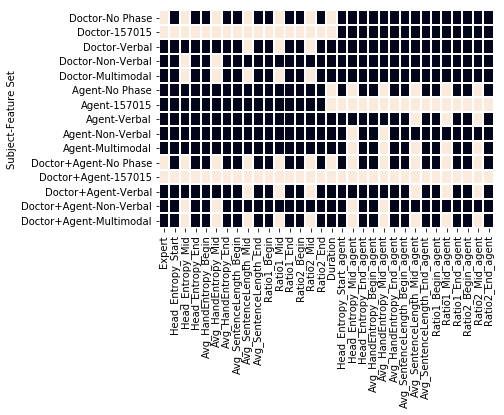

In [67]:


sns.heatmap(features_df.fillna(0).astype('int'), linecolor='white', linewidth=1, annot=False, cbar=False)
plt.savefig(os.path.join(config.OUT_PATH, 'features_sets.png'), bbox_inches = "tight")
plt.show()

# to avoid updating everything below for now

subject_features = get_features_set('Doctor', '157015')
agent_features = get_features_set('Agent', '157015')
all_features = get_features_set('Doctor+Agent', '157015')
subject_features_nophase = get_features_set('Doctor', 'No Phase')
agent_features_nophase = get_features_set('Agent', 'No Phase')
all_features_nophase = get_features_set('Doctor+Agent', 'No Phase')
subject_features_verbal = get_features_set('Doctor', 'Verbal')
agent_features_verbal = get_features_set('Agent', 'Verbal')
all_features_verbal = get_features_set('Doctor+Agent', 'Verbal')
subject_features_nonverbal = get_features_set('Doctor', 'Non-Verbal')
agent_features_nonverbal = get_features_set('Agent', 'Non-Verbal')
all_features_nonverbal = get_features_set('Doctor+Agent', 'Non-Verbal')
subject_features_multimodal = get_features_set('Doctor', 'Multimodal')
agent_features_multimodal = get_features_set('Agent', 'Multimodal')
all_features_multimodal = get_features_set('Doctor+Agent', 'Multimodal')
#subject_features_multimodal_duration = get_features_set('Doctor', 'Multimodal+Duration')
#agent_features_multimodal_duration = get_features_set('Agent', 'Multimodal+Duration')
#all_features_multimodal_duration = get_features_set('Doctor+Agent', 'Multimodal+Duration')


## Utilities

In [61]:


out_path = os.path.join(config.OUT_PATH, 'gridsearchcv')
if not os.path.exists(out_path): os.makedirs(out_path)
    
OUT_PATH=os.path.join(config.OUT_PATH, 'cleaned-20190422')


def prepare_train_data(samples, features, target_model, upsample=None, test_set=True, verbose=0):
    """
    Prepares a dataset for ML.
    
    Parameters
    ----------
    
    samples: DataFrame
    
    features: list
    
    target_model: str
        'presence' or 'copresence'
        
    upsample: None or str
        None: no oversampling
        For description of other oversampling method see https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html
        imb_random
        imb_smote
        imb_adasyn
        imb_smotenc
        imb_borderlinesmote1
        imb_borderlinesmote2
        imb_svmsmote
    
    """
    if verbose > 0:
        print('prepare_train_data: target_model=%s, features=%s, upsamples=%s' % (target_model, features, upsample))
        print('prepare_train_data: unique %d' %  len(np.unique(samples.loc[:, features], return_counts=True, axis=0)[1]))
    names = features
    
    samples_split = []
    if (target_model == "presence"):
        samples_split.append(samples[samples.PresenceClass == 1])
        samples_split.append(samples[samples.PresenceClass == 2])
        samples_split.append(samples[samples.PresenceClass == 3])

    elif (target_model == "copresence"):
        samples_split.append(samples[samples.CopresenceClass == 1])
        samples_split.append(samples[samples.CopresenceClass == 2])
        samples_split.append(samples[samples.CopresenceClass == 3])
    else:
        sys.exit("Invalid input for target_model %s. Please pick between presence and copresence" % target_model)


    """    if upsample == 'random':
        # default upsampling method kept for history but should not be used (does not guarantee presence of all samples
        # from minority class)
        maxClassSize = max(samples_split[0].shape[0], samples_split[1].shape[0], samples_split[2].shape[0])
        upsampled = []
        for idx, samples in enumerate(samples_split):
            if (samples.shape[0] == maxClassSize):
                upsampled.append(samples)
            else:
                if verbose > 1:
                    logger.debug("prepare_train_data: adding " + str(maxClassSize - samples.shape[0]) + " samples to class " + str(
                        idx + 1) + " to reach " + str(maxClassSize))
                upsampled.append(resample(samples, replace=True, n_samples=maxClassSize, random_state=RANDOM_STATE))

        balanced_set = pd.concat(upsampled)
        X = np.nan_to_num(balanced_set.as_matrix(names))

        if (target_model == "presence"):
            y = np.array(balanced_set["PresenceClass"].tolist())

        else:
            y = np.array(balanced_set["CopresenceClass"].tolist())"""

    if target_model == "presence":
        if test_set:
            X = np.nan_to_num(samples.loc[train_pres_idx, features])
            X_test = np.nan_to_num(samples.loc[test_pres_idx, features])
            y = samples.loc[train_pres_idx].PresenceClass
            y_test = samples.loc[test_pres_idx].PresenceClass
        else:
            X = np.nan_to_num(samples.loc[:, features])
            y = samples.PresenceClass

    else:
        if test_set:
            X = np.nan_to_num(samples.loc[train_copres_idx, features])
            X_test = np.nan_to_num(samples.loc[test_copres_idx, features])
            y = samples.loc[train_copres_idx].CopresenceClass
            y_test = samples.loc[test_copres_idx].CopresenceClass
        else:
            X = np.nan_to_num(samples.loc[:, features])
            y = samples.CopresenceClass
       
    ros = None
    if upsample == 'imb_random':
        ros = RandomOverSampler(random_state=RANDOM_STATE)
        print("prepare_train_data: Applying RANDOM oversampling to data %d / %s / unique %d" 
              % (len(X), collections.Counter(y), len(np.unique(X, return_counts=True, axis=0)[1])))    

    elif upsample == 'imb_smote':
        # https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html
        ros = SMOTE(random_state=RANDOM_STATE)
        print("prepare_train_data: Applying SMOTE oversampling to data %d / %s / unique %d" 
              % (len(X), collections.Counter(y), len(np.unique(X, return_counts=True, axis=0)[1])))   
        
    elif upsample == 'imb_adasyn':
        ros = ADASYN(random_state=RANDOM_STATE)
        print("prepare_train_data: Applying ADASYN oversampling to data %d / %s / unique %d" 
              % (len(X), collections.Counter(y), len(np.unique(X, return_counts=True, axis=0)[1])))   
        
    elif upsample == 'imb_smotenc':
        # SMOTENC is the only one dealing properly with categorical data (ie 'Expert' feature)
        ros = SMOTENC(random_state=RANDOM_STATE)
        print("prepare_train_data: Applying SMOTENC oversampling to data %d / %s / unique %d" 
              % (len(X), collections.Counter(y), len(np.unique(X, return_counts=True, axis=0)[1])))          
        
    elif upsample == 'imb_borderlinesmote1':
        ros = BorderlineSMOTE(kind='borderline-1', random_state=RANDOM_STATE)
        print("prepare_train_data: Applying BorderlineSMOTE-1 oversampling to data %d / %s / unique %d" 
              % (len(X), collections.Counter(y), len(np.unique(X, return_counts=True, axis=0)[1])))    
        
    elif upsample == 'imb_borderlinesmote2':
        ros = BorderlineSMOTE(kind='borderline-2', random_state=RANDOM_STATE)
        print("prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data %d / %s / unique %d" 
              % (len(X), collections.Counter(y), len(np.unique(X, return_counts=True, axis=0)[1])))    
        
    elif upsample == 'imb_svmsmote':
        ros = SVMSMOTE(random_state=RANDOM_STATE)
        print("prepare_train_data: Applying SVMSMOTE oversampling to data %d / %s / unique %d" 
              % (len(X), collections.Counter(y), len(np.unique(X, return_counts=True, axis=0)[1])))    
            
    if ros is not None:
        # test set is never oversampled
        X, y = ros.fit_resample(X, y)     
    
    if verbose > 0:
        print("prepare_train_data: Resampled data %d / %s / unique %d" 
              % (len(X), collections.Counter(y), len(np.unique(X, return_counts=True, axis=0)[1])))
    
    if test_set:
        return X, y, X_test, y_test
    else:
        return X, y

def gridsearch(clf, X, y, modelTarget, param_grid, features, verbose=0):
    if verbose > 0:
        print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s)" 
              % (type(clf), modelTarget, param_grid, features))

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    #logger.debug("X_train ", X_train.shape, "X_test", X_test.shape, "y_train", y_train.shape, "y_test", y_test.shape)


    #n_estimators = np.concatenate((np.arange(1,10), np.arange(10,100,10)))
    print(np.unique(y, return_counts=True))
    grid = GridSearchCV(estimator=clf, param_grid=param_grid,
                        scoring=['f1_macro', 'precision_macro', 'recall_macro'],
                        refit='f1_macro',
                        cv=10,
                        return_train_score=True,
                        verbose=verbose)
    grid = grid.fit(X, y)

    results = grid.cv_results_
    # print("best params ", grid.best_params_)
    # print("best score ", grid.best_score_)

    return grid

# prepare results
def update_results_from_gridsearch(rdf, cv_results_, p1, p2, p3, p4, p5):
    df = pd.DataFrame(cv_results_)
    best_precision = df.mean_test_precision_macro.max()
    df_best = df.loc[df['mean_test_precision_macro'] == best_precision]
    if p5 == 'score':
        cols = [col for col in df_best.columns if ('mean_test_' in col)]
    elif p5 == 'err':
        cols = [col for col in df_best.columns if ('mean_std_' in col)]
    print('update_results_from_gridsearch: cols %s' % cols)
    update_results(rdf, df_best[cols], p1, p2, p3, p4, p5)
    return rdf

def update_results(rdf, df, p1, p2, p3, p4, p5):
    for i, col in enumerate(df.columns):
        rdf.loc[(p1, p2, p3, p4, p5), col] = df.iloc[0].loc[col]
    return rdf


def update_results_single(rdf, df, p1, p2, p3, p4, p5):
    for i, col in enumerate(df.columns):
        rdf.loc[(p1, p2, p3, p4, p5), col] = df.loc[col]
    return rdf

In [60]:
# from rfpimp

def dropcol_importances_sklearn(model, X_train, y_train, X_valid=None, y_valid=None, metric=None, sample_weights=None):
    """
    Compute drop-column feature importances for scikit-learn.

    Given a classifier or regression in model
    and training X and y data, return a data frame with columns
    Feature and Importance sorted in reverse order by importance.

    A clone of model is trained once to get the baseline score and then
    again, once per feature to compute the drop in either the model's .score() output
    or a custom metric callable in the form of metric(model, X_valid, y_valid).
    In case of a custom metric the X_valid and y_valid parameters should be set.
    return: A data frame with Feature, Importance columns

    SAMPLE CODE
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
    X_train, y_train = ..., ...
    rf.fit(X_train, y_train)
    imp = dropcol_importances(rf, X_train, y_train)
    """

    if X_valid is None: X_valid = X_train
    if y_valid is None: y_valid = y_train
    model_ = clone(model)
    #model_.random_state = RANDOM_STATE
    model_.fit(X_train, y_train)

    if callable(metric):
        baseline = metric(model_, X_valid, y_valid)
    else:
        baseline = model_.score(X_valid, y_valid)
    print("baseline " + str(baseline))
    imp = []
    for col in X_train.columns:
        print("column " + col)
        model__ = clone(model)
        #model__.random_state = RANDOM_STATE
        X_tr = X_train.drop(col, axis=1)
        X_va = X_valid.drop(col, axis=1)
        model__.fit(X_tr, y_train)
        if callable(metric):
            s = metric(model__, X_va, y_valid)
        else:
            s = model__.score(X_va, y_valid)
        print("new score " + str(s))
        drop_in_score = baseline - s
        imp.append(drop_in_score)

    imp = np.array(imp)

    #I = pd.DataFrame(data={'Feature':X_train.columns, 'Importance':imp})
    #I = I.set_index('Feature')
    #I = I.sort_values('Importance', ascending=False)
    
    return imp #I

def dropcol_importances(rf, X_train, y_train, random_state):
    rf_ = clone(rf)
    rf_.random_state = random_state
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    #print("baseline " + str(baseline))
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = random_state
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    imp = np.array(imp)
    #I = pd.DataFrame(
    #        data={'Feature':X_train.columns,
    #              'Importance':imp})
    #I = I.set_index('Feature')
    #I = I.sort_values('Importance', ascending=True)
    return imp #I

### Random Forests - n_estimators evaluation
First for Random Forests Classifier, we study when out of bag score stabilizes for a range of n_estimators values.
We will use found n_estimator value with good balance between score and reliability, and performances.

Note: we hypothetize that we can find this value on a specific feature set (subject doctor, no phase) and use it for other sets of features, given overall domain and task remain similar.

In [7]:
def oob_score(estimator, X, y):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    We add to this the 
    """
    score = estimator.oob_score_
    return score


X, y = prepare_train_data(subject_np_df, 'presence', subject_features_nophase, upsample=True)

n_estimators_range = np.arange(1,1000)#np.unique(np.logspace(0, 3, 300, dtype=int))
scores = []
errs = []
scoring = {
    'oob' : oob_score,
    'f1_macro' : 'f1_macro',
    'precision_macro' : 'precision_macro',
    'recall_macro' : 'recall_macro'         
}

from tqdm import tqdm, tqdm_notebook

pbar = tqdm_notebook(n_estimators_range, desc='n_estimators')
for i in pbar:
    pbar.set_description('n_estimators = %d / %s' % (i, n_estimators_range[-1]))
    clf = RandomForestClassifier(n_estimators=int(i), oob_score=True)
    result = cross_validate(clf, X, y, scoring=scoring, return_train_score=False, cv=10, verbose=0)
    scores.append(pd.DataFrame(result).mean().values)
    errs.append(pd.DataFrame(result).std().values)

SystemExit: Invalid input for target_model ['Expert', 'Head_Entropy_Mid', 'Avg_HandEntropy_Mid', 'Avg_SentenceLength_Mid', 'Ratio1_Mid', 'Ratio2_Mid', 'Duration']. Please pick between presence and copresence

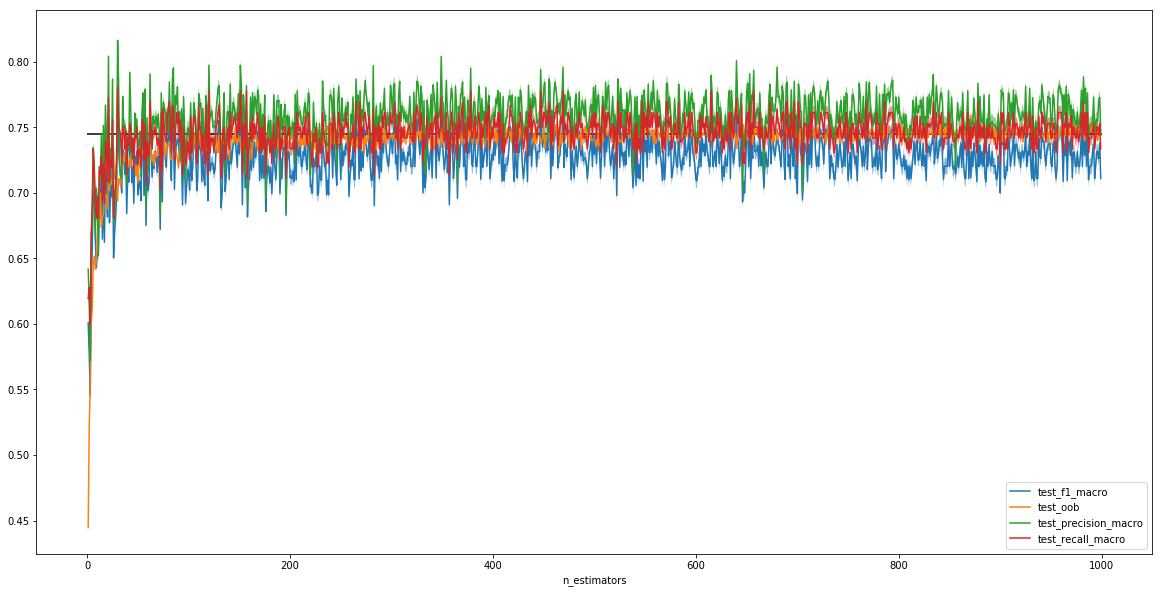

In [109]:
df = pd.DataFrame(scores, columns=pd.DataFrame(result).columns)
dferr = pd.DataFrame(errs, columns=pd.DataFrame(result).columns)
df = df.drop(['fit_time', 'score_time'], axis=1)
dferr = dferr.drop(['fit_time', 'score_time'], axis=1)
plt.figure(figsize=(20,10))
plt.hlines(y=df['test_oob'][400:].mean(), xmin=0.0, xmax=1000, color='black')
for key in df.columns:
    plt.plot(n_estimators_range, df[key], label=key)
    plt.fill_between(n_estimators_range, 
                     df[key]+(dferr[key]/np.sqrt(len(dferr))), 
                     df[key]-(dferr[key]/np.sqrt(len(dferr))),
                     alpha=0.5)
    plt.legend()
    plt.xlabel('n_estimators')

n_estimators = 300 seems to be an appropriate value, we will use it for further tests on random forests.

# Classification

In [94]:
def score_forest(estimator, X_, y_):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    """
    all_feature_importances.append(estimator.feature_importances_) # global variable - ugly trick
    score = estimator.oob_score_
    #print "oob_score_:", score
    return score

def svm_fi(estimator, X_, y_):
    # for SVM dropcol feature importances computation, we use validation data (X_, y_) and train data (X, y) are global.
    #X_train_df = pd.DataFrame(X, columns=feats)
    #y_train_df = pd.DataFrame(y)
    #X_valid_df = pd.DataFrame(X_, columns=feats)
    #y_valid_df = pd.DataFrame(y_)
    #dcs = dropcol_importances_sklearn(clf, X_train_df, y_train_df, X_valid_df, y_valid_df)
    #all_dropcol_feature_importances.append(dcs)
    #print(dcs)
    return 0

def run_cross_val_score(clf, X, y, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    scoring = {
        'f1_macro' : 'f1_macro',
        'f1_macro_class_1': make_scorer(f1_score, labels=[1], average='macro'),
        'f1_macro_class_2': make_scorer(f1_score, labels=[2], average='macro'),
        'f1_macro_class_3': make_scorer(f1_score, labels=[3], average='macro'),
        'precision_macro' : 'precision_macro',
        'precision_macro_class_1': make_scorer(precision_score, labels=[1], average='macro'),
        'precision_macro_class_2': make_scorer(precision_score, labels=[2], average='macro'),
        'precision_macro_class_3': make_scorer(precision_score, labels=[3], average='macro'),
        'recall_macro' : 'recall_macro',
        'recall_macro_class_1': make_scorer(recall_score, labels=[1], average='macro'),
        'recall_macro_class_2': make_scorer(recall_score, labels=[2], average='macro'),
        'recall_macro_class_3': make_scorer(recall_score, labels=[3], average='macro')           
    }
    
    if type(clf) == RandomForestClassifier:
        scoring ['oob'] = score_forest
    else:
        scoring['fi'] = svm_fi
    
    return cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False, verbose=verbose)


def run_gridsearch(clf, param_grid, data, features, target_model, repeat=10, repeat_dc=300, test_set=False, upsample=None, fi=False, verbose=0):

    if test_set:
        X, y, X_test, y_test = prepare_train_data(samples=data, features=features, target_model=target_model, test_set=test_set,
                                                  upsample=upsample, verbose=verbose) 
    else:
        X, y = prepare_train_data(samples=data, features=features, target_model=target_model, test_set=test_set,
                                  upsample=upsample, verbose=verbose) 
    
    # first evaluate best params through grid search for this particular dataset/featureset
    grid = gridsearch(clf, 
                      X, y, 
                      'presence', 
                      param_grid=param_grid, 
                      features=features, 
                      verbose=verbose)
    best_params = grid.best_params_
    single_best_score = grid.best_score_

    print('  Gridsearch evaluated best score %s' % (single_best_score))
    print('    Running %d iterations on best classifier %s ...' % (repeat, best_params))

    all_scores=None
    
    if test_set:
        clf.set_params(**best_params)
        clf.fit(X, y)
        y_pred = clf.predict(X_test)
        from sklearn.metrics import balanced_accuracy_score
        print('Balanced accuracy score: %d' % balanced_accuracy_score(y_test, y_pred))
        
        from sklearn.metrics import classification_report
        print(classification_report(y_test, y_pred))
        
        from sklearn.metrics import roc_curve, auc

        y_predict_proba = clf.predict_proba(X_test)

        # Compute ROC curve and ROC AUC for each class
        n_classes = 3
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        all_y_test_i = np.array([])
        all_y_predict_proba = np.array([])
        for i in range(n_classes):
            y_test_i = map(lambda x: 1 if x == i else 0, y_test)
            all_y_test_i = np.concatenate([all_y_test_i, y_test_i])
            all_y_predict_proba = np.concatenate([all_y_predict_proba, y_predict_proba[:, i]])
            fpr[i], tpr[i], _ = roc_curve(y_test_i, y_predict_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["average"], tpr["average"], _ = roc_curve(all_y_test_i, all_y_predict_proba)
        roc_auc["average"] = auc(fpr["average"], tpr["average"])


        # Plot average ROC Curve
        plt.figure()
        plt.plot(fpr["average"], tpr["average"],
                 label='Average ROC curve (area = {0:0.2f})'
                       ''.format(roc_auc["average"]),
                 color='deeppink', linestyle=':', linewidth=4)

        # Plot each individual ROC curve
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], lw=2,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(i, roc_auc[i]))

        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve %s / %s / test set ? %s / oversampling %s' % (clf.__class__.__name__, target_model, 
                                                                           test_set, upsample))
        plt.legend(loc="lower right")
        plt.show()
        
    else:
        all_scores = []
        global all_feature_importances
        global all_dropcol_feature_importances
        for i in np.arange(repeat):
            #forest = RandomForestClassifier(oob_score=True)
            # set best params to classifier

            clf.set_params(**best_params)

            scores = run_cross_val_score(clf, 
                              X, y,  
                              verbose=verbose)
            print("iter # %d" % i)
            #    print(scores)
            scores_df = pd.DataFrame(scores)
            #print(scores_df)
            #print(scores_df.columns)
            all_scores.append(scores_df)

    support = np.unique(y, return_counts=True)
    
    if not test_set:
        # compute feature importance for random forest : we don't need validation data as it relies on oob score
        if type(clf) == RandomForestClassifier:
            all_feature_importances = pd.DataFrame(all_feature_importances, columns=features)        
            if fi:
                X_ = pd.DataFrame(X, columns=features)
                y_ = pd.DataFrame(y)        
                for i in np.arange(repeat_dc):
                    # alternative computation for feature importance
                    all_dropcol_feature_importances.append(dropcol_importances(clf, X_, y_, RANDOM_STATE+i))
        else:
            all_feature_importances = None
            all_dropcol_feature_importances = None
            '''print(X, y)
            skf = StratifiedKFold(n_splits=repeat, random_state=RANDOM_STATE, shuffle=True)
            for i in np.arange(repeat_dc):
                for train_index, test_index in skf.split(X, y):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]
                    X_train = pd.DataFrame(X_train, columns=features)
                    X_test = pd.DataFrame(X_test, columns=features)
                    y_train = pd.DataFrame(y_train)
                    y_test = pd.DataFrame(y_test)
                    # alternative computation for feature importance
                    dcs = dropcol_importances_sklearn(clf, X_train, y_train, X_test, y_test, RANDOM_STATE+i)
                    print("X_train %s X_test %s y_train %s y_test %s" % (len(X_train), len(X_test), len(y_train), len(y_test)))
                    print(dcs)
                    all_dropcol_feature_importances.append(dcs)'''

        all_scores = pd.concat(all_scores)
        if all_dropcol_feature_importances is not None:
            all_dropcol_feature_importances = pd.DataFrame(all_dropcol_feature_importances, columns=features)

    return grid, all_scores, all_dropcol_feature_importances, all_feature_importances, support


In [63]:
def plot_importance(title, importances, importances_err, feature_names, sort=True):
    # Sort feature importances in descending order
    if sort:
        indices = np.argsort(importances)[::-1]
    else:
        indices = np.arange(len(feature_names))

    # Rearrange feature names so they match the sorted feature importances
    names = [feature_names[i] for i in indices]
    if importances_err is not None:
        errs = [importances_err[i] for i in indices]

    # Create plot
    plt.figure()

    # Create plot title
    plt.title("Feature Importance - " + title)

    # Add bars
    if importances_err is not None:
        plt.bar(range(len(feature_names)), importances[indices], yerr=errs, xerr=0.1)
    else:
        plt.bar(range(len(feature_names)), importances[indices])

    # Add feature names as x-axis labels
    plt.xticks(range(len(feature_names)), names, rotation=90)

    dh.save_fig(title)
    #plt.savefig(os.path.join(dh.root_path, 'figures', title+'.png'))
    plt.show()


# Subject and Agent features, phases and no phase

In [64]:
# prepare results dataframes

dh = DataHandler('imb_random', 'phases-nophase', 0)

scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['No Phase', '157015'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_columns = ['precision', 'f1', 'recall', 'params']
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Target', 'Subject', 'Phases', 'Classifier', 'Metric'])

scores_df = dh.load_obj('results', 'scores')
print(len(scores_df_multiindex.to_flat_index()))
if scores_df is None:
    scores_df = pd.DataFrame(index=scores_df_multiindex)
    #scores_df = pd.DataFrame(np.zeros((len(scores_df_multiindex.to_flat_index()),4)), 
    #                         index=scores_df_multiindex, 
    #                         columns=scores_df_columns)
    #scores_df['params'] = scores_df['params'].apply(str)
    #scores_df['params'] = ''
    dh.save_obj(scores_df, 'results', 'scores')
    
context_df = dh.load_obj('.', 'context')
if context_df is None:
    context_df = pd.DataFrame(index=scores_df_multiindex)
    context_df['Best Params'] = ''
    context_df['Best Params'] = context_df['Best Params'].apply(str)
    dh.save_obj(context_df, '.', 'context')
    
scores_df

file does not yet exist C:\IAAA\TER\_output\imb_random\phases-nophase-0\results\scores.pkl
48
file does not yet exist C:\IAAA\TER\_output\imb_random\phases-nophase-0\.\context.pkl


Empty DataFrame
Columns: []
Index: [(Presence, Doctor, No Phase, Random Forests, score), (Presence, Doctor, No Phase, Random Forests, err), (Presence, Doctor, No Phase, SVM, score), (Presence, Doctor, No Phase, SVM, err), (Presence, Doctor, 157015, Random Forests, score), (Presence, Doctor, 157015, Random Forests, err), (Presence, Doctor, 157015, SVM, score), (Presence, Doctor, 157015, SVM, err), (Presence, Agent, No Phase, Random Forests, score), (Presence, Agent, No Phase, Random Forests, err), (Presence, Agent, No Phase, SVM, score), (Presence, Agent, No Phase, SVM, err), (Presence, Agent, 157015, Random Forests, score), (Presence, Agent, 157015, Random Forests, err), (Presence, Agent, 157015, SVM, score), (Presence, Agent, 157015, SVM, err), (Presence, Doctor+Agent, No Phase, Random Forests, score), (Presence, Doctor+Agent, No Phase, Random Forests, err), (Presence, Doctor+Agent, No Phase, SVM, score), (Presence, Doctor+Agent, No Phase, SVM, err), (Presence, Doctor+Agent, 157015, Random Forests, score), (Presence, Doctor+Agent, 157015, Random Forests, err), (Presence, Doctor+Agent, 157015, SVM, score), (Presence, Doctor+Agent, 157015, SVM, err), (Co-Presence, Doctor, No Phase, Random Forests, score), (Co-Presence, Doctor, No Phase, Random Forests, err), (Co-Presence, Doctor, No Phase, SVM, score), (Co-Presence, Doctor, No Phase, SVM, err), (Co-Presence, Doctor, 157015, Random Forests, score), (Co-Presence, Doctor, 157015, Random Forests, err), (Co-Presence, Doctor, 157015, SVM, score), (Co-Presence, Doctor, 157015, SVM, err), (Co-Presence, Agent, No Phase, Random Forests, score), (Co-Presence, Agent, No Phase, Random Forests, err), (Co-Presence, Agent, No Phase, SVM, score), (Co-Presence, Agent, No Phase, SVM, err), (Co-Presence, Agent, 157015, Random Forests, score), (Co-Presence, Agent, 157015, Random Forests, err), (Co-Presence, Agent, 157015, SVM, score), (Co-Presence, Agent, 157015, SVM, err), (Co-Presence, Doctor+Agent, No Phase, Random Forests, score), (Co-Presence, Doctor+Agent, No Phase, Random Forests, err), (Co-Presence, Doctor+Agent, No Phase, SVM, score), (Co-Presence, Doctor+Agent, No Phase, SVM, err), (Co-Presence, Doctor+Agent, 157015, Random Forests, score), (Co-Presence, Doctor+Agent, 157015, Random Forests, err), (Co-Presence, Doctor+Agent, 157015, SVM, score), (Co-Presence, Doctor+Agent, 157015, SVM, err)]

### Test plan definition

In [28]:
test_plan_params = {
    'classifier': ['forest', 'svm'],
    'subject': ['doctor+agent', 'doctor', 'agent'],
    'target': ['presence', 'copresence'],
    'phases': [(0,1,0), (0.15,0.70,0.15)]
}
test_plan = list(ParameterGrid(test_plan_params))
print("%d tests to be performed" % len(test_plan))
for test in test_plan:
    print(test)

24 tests to be performed
{'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor+agent'}
{'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor+agent'}
{'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor'}
{'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor'}
{'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'agent'}
{'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'forest', 'subject': 'agent'}
{'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor+agent'}
{'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor+agent'}
{'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor'}
{'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor'}
{'phases': (0.15, 0.7

## Gridsearch hyper-parameters ranges

In [107]:
# random forests
param_grid_rf =  {
    'n_estimators' : [300],
    'max_features': [None, 'sqrt', 'log2'],
    "max_depth": [None, 2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}
# for quickly testing the loops
param_grid_rf_tests = {
    'n_estimators' : [10],
    'max_features': [None],
    "max_depth": [None],
    "min_samples_leaf": [1]
}

# SVM
param_grid_svm = {
    'svc__kernel': ['linear', 'rbf', 'sigmoid'],
    'svc__C': np.logspace(-2, 1, 4),
    'svc__gamma': np.logspace(-3, 1, 5)
}

# Gaussian Naive Bayes
param_grid_gnb = {
    'gaussiannb__priors': [None], 
    'gaussiannb__var_smoothing': [1e-09]
}


### Run

Test 0 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor+agent'}
No phase
prepare_train_data: target_model=presence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration',
       u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({3L: 43, 2L: 35, 1L: 18}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, modelTarget=presence, param_grid={'n_estimators': [300], 'max_features': [None, 'sqrt', 'log2'], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 5, 10]}, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntrop

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.8min finished


  Gridsearch evaluated best score 0.6060203362528944
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 1} ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished


iter # 9
      updating scores for presence_doctoragent_nophase_forest


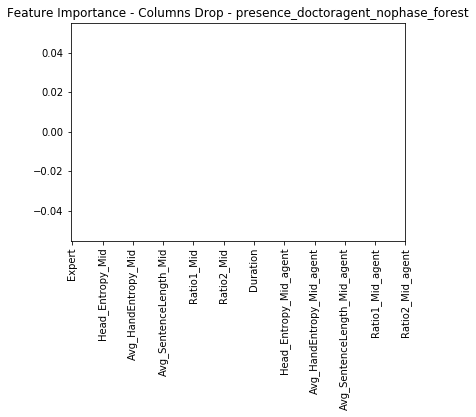

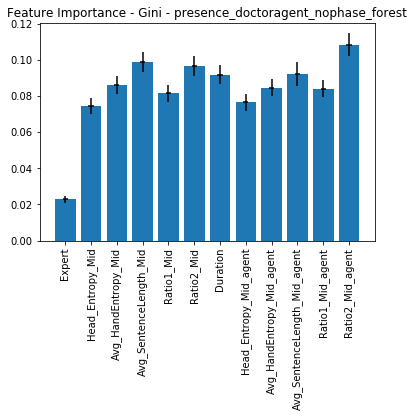

Test 1 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor+agent'}
No phase
prepare_train_data: target_model=copresence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration',
       u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({2L: 43, 3L: 41, 1L: 12}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, modelTarget=presence, param_grid={'n_estimators': [300], 'max_features': [None, 'sqrt', 'log2'], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 5, 10]}, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEn

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.5min finished


  Gridsearch evaluated best score 0.7065511146906496
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.2s finished


iter # 9
      updating scores for presence_doctoragent_nophase_forest


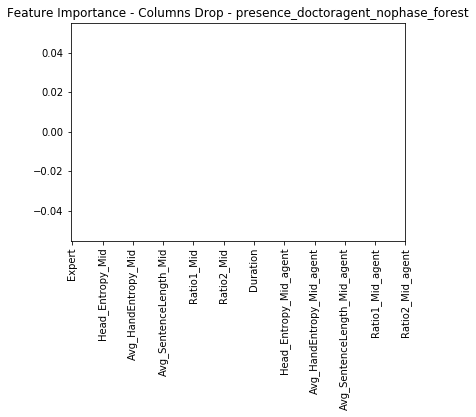

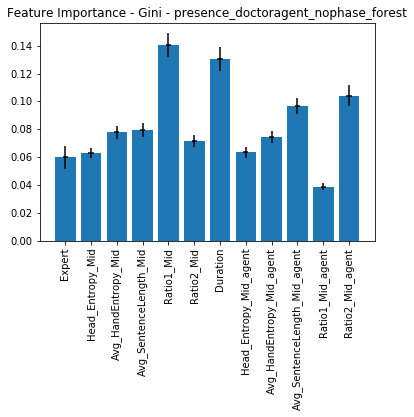

Test 2 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor'}
No phase
prepare_train_data: target_model=presence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({3L: 43, 2L: 35, 1L: 18}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, modelTarget=presence, param_grid={'n_estimators': [300], 'max_features': [None, 'sqrt', 'log2'], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 5, 10]}, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration'],
      dtype='object'), upsample=True)
(array([1, 2, 3], dtype=int64), arr

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.4min finished


  Gridsearch evaluated best score 0.5193362623595182
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished


iter # 9
      updating scores for presence_doctor_nophase_forest


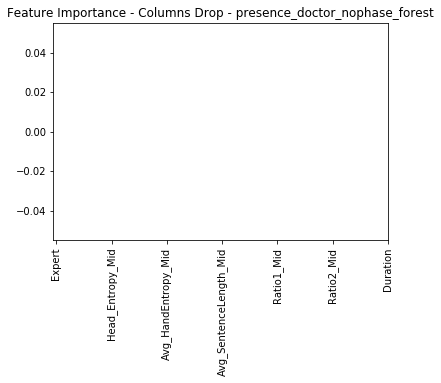

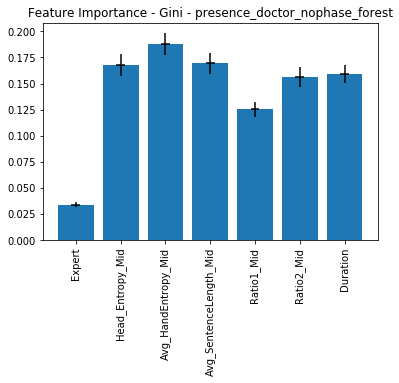

Test 3 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor'}
No phase
prepare_train_data: target_model=copresence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({2L: 43, 3L: 41, 1L: 12}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, modelTarget=presence, param_grid={'n_estimators': [300], 'max_features': [None, 'sqrt', 'log2'], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 5, 10]}, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration'],
      dtype='object'), upsample=True)
(array([1, 2, 3], dtype=int64),

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.4min finished


  Gridsearch evaluated best score 0.6189742643231015
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1} ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.2s finished


iter # 9
      updating scores for presence_doctor_nophase_forest


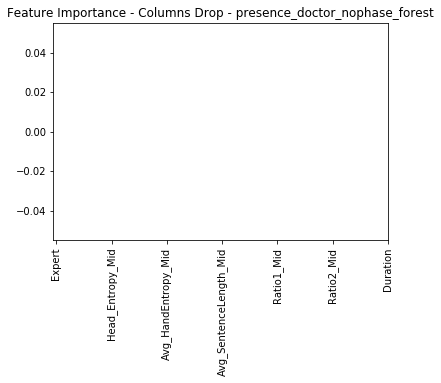

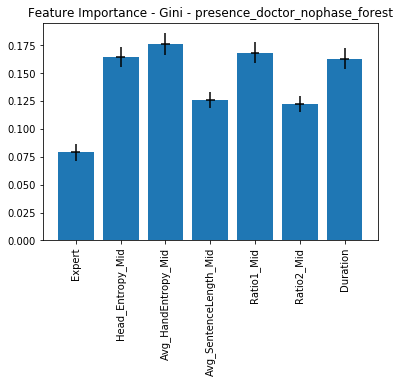

Test 4 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'agent'}
No phase
prepare_train_data: target_model=presence, features=Index([u'Duration', u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({3L: 43, 2L: 35, 1L: 18}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, modelTarget=presence, param_grid={'n_estimators': [300], 'max_features': [None, 'sqrt', 'log2'], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 5, 10]}, features=Index([u'Duration', u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'),

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.5min finished


  Gridsearch evaluated best score 0.5524370117393372
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.2s finished


iter # 9
      updating scores for presence_agent_nophase_forest


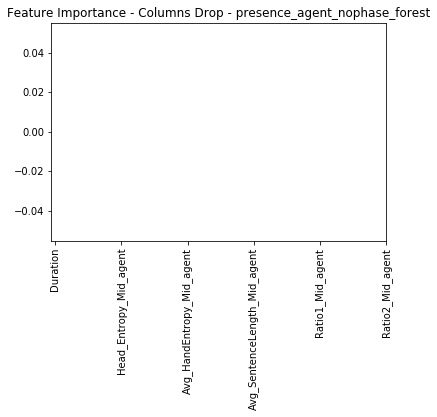

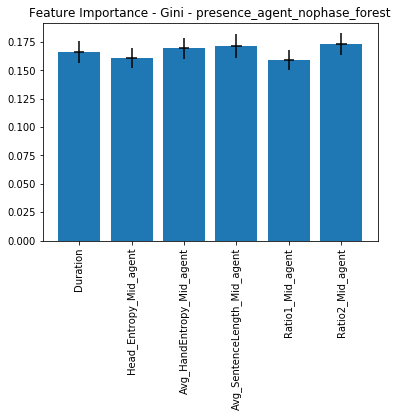

Test 5 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'forest', 'subject': 'agent'}
No phase
prepare_train_data: target_model=copresence, features=Index([u'Duration', u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({2L: 43, 3L: 41, 1L: 12}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, modelTarget=presence, param_grid={'n_estimators': [300], 'max_features': [None, 'sqrt', 'log2'], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 5, 10]}, features=Index([u'Duration', u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='objec

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.4min finished


  Gridsearch evaluated best score 0.6461134042529391
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished


iter # 9
      updating scores for presence_agent_nophase_forest


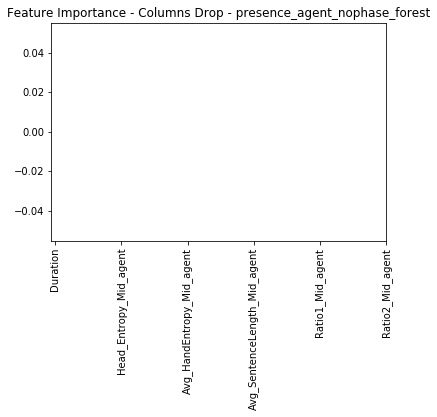

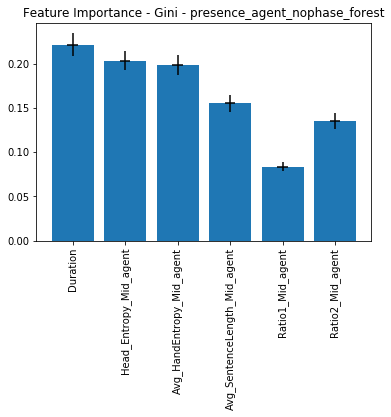

Test 6 : {'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor+agent'}
phases (0.15, 0.7, 0.15)
prepare_train_data: target_model=presence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration', u'Head_Entropy_Start_agent',
       u'Head_Entropy_Mid_agent', u'Head_Entropy_End_agent',
       u'Avg_HandEntropy_Begin_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_HandEntropy_End_agent', u'Avg_SentenceLength_Begin_agent',
       u'Avg_SentenceLength_Mid_agent', u'Avg_SentenceLength_End_agent',
       u'Ratio1_Begin_agent', u'Ratio1_Mid_agent', u'Ratio1_End_agent',
       u'Ratio2_Begin_agent', u'Ratio2_Mid_agent', u'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.7min finished


  Gridsearch evaluated best score 0.6715262773402308
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1} ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.7s finished


iter # 9
      updating scores for presence_doctoragent_157015_forest


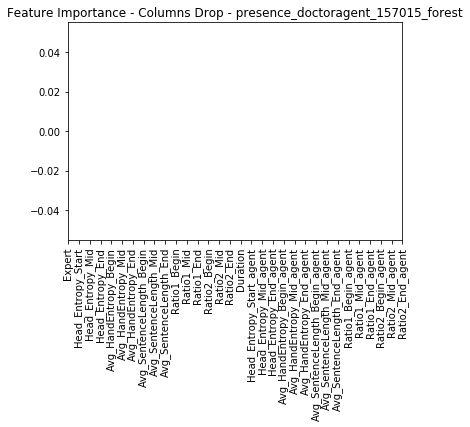

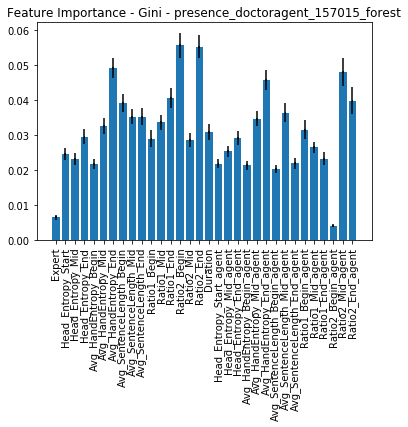

Test 7 : {'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor+agent'}
phases (0.15, 0.7, 0.15)
prepare_train_data: target_model=copresence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration', u'Head_Entropy_Start_agent',
       u'Head_Entropy_Mid_agent', u'Head_Entropy_End_agent',
       u'Avg_HandEntropy_Begin_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_HandEntropy_End_agent', u'Avg_SentenceLength_Begin_agent',
       u'Avg_SentenceLength_Mid_agent', u'Avg_SentenceLength_End_agent',
       u'Ratio1_Begin_agent', u'Ratio1_Mid_agent', u'Ratio1_End_agent',
       u'Ratio2_Begin_agent', u'Ratio2_Mid_agent'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.7min finished


  Gridsearch evaluated best score 0.6232579651184302
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1} ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished


iter # 9
      updating scores for presence_doctoragent_157015_forest


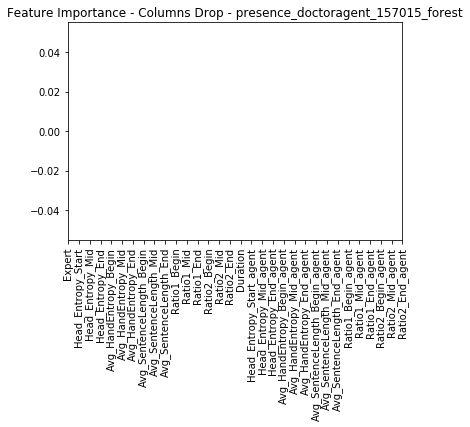

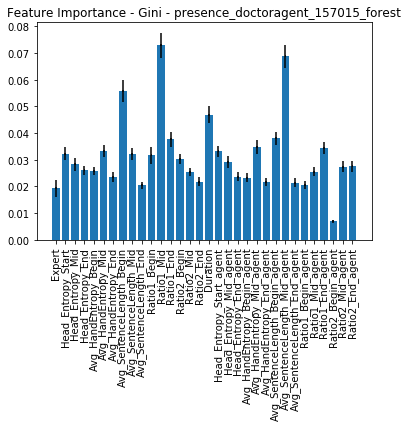

Test 8 : {'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor'}
phases (0.15, 0.7, 0.15)
prepare_train_data: target_model=presence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({3L: 43, 2L: 35, 1L: 18}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, modelTarget=presence, param_grid={'n_estimators': [300], 'max_features': [None, 'sqrt', 'log2'], 'max_depth': [None, 2

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.6min finished


  Gridsearch evaluated best score 0.720256272581854
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 1} ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.8s finished


iter # 9
      updating scores for presence_doctor_157015_forest


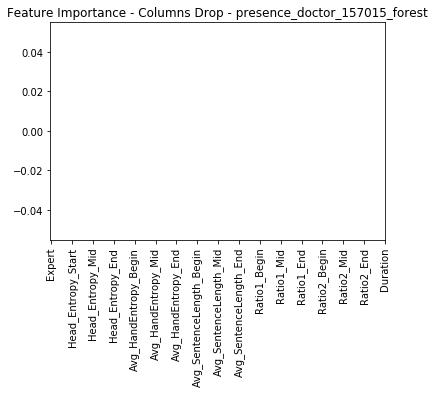

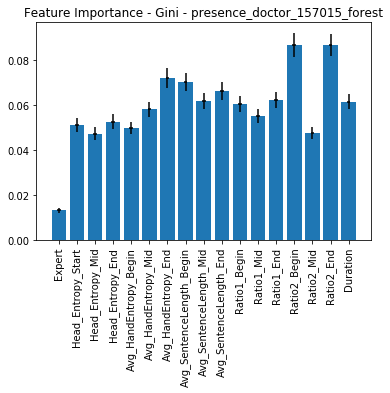

Test 9 : {'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor'}
phases (0.15, 0.7, 0.15)
prepare_train_data: target_model=copresence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({2L: 43, 3L: 41, 1L: 12}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, modelTarget=presence, param_grid={'n_estimators': [300], 'max_features': [None, 'sqrt', 'log2'], 'max_depth': [Non

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.6min finished


  Gridsearch evaluated best score 0.6036755664662641
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 1} ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished


iter # 9
      updating scores for presence_doctor_157015_forest


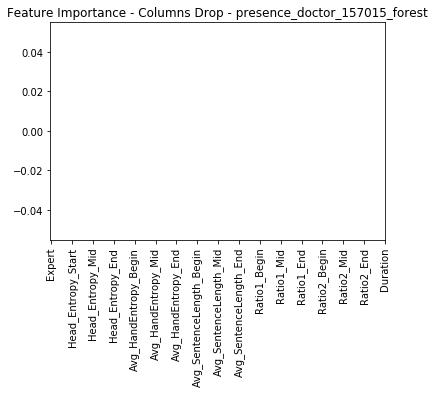

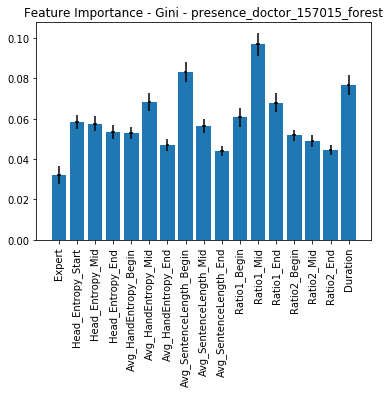

Test 10 : {'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'forest', 'subject': 'agent'}
phases (0.15, 0.7, 0.15)
prepare_train_data: target_model=presence, features=Index([u'Duration', u'Head_Entropy_Start_agent', u'Head_Entropy_Mid_agent',
       u'Head_Entropy_End_agent', u'Avg_HandEntropy_Begin_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_HandEntropy_End_agent',
       u'Avg_SentenceLength_Begin_agent', u'Avg_SentenceLength_Mid_agent',
       u'Avg_SentenceLength_End_agent', u'Ratio1_Begin_agent',
       u'Ratio1_Mid_agent', u'Ratio1_End_agent', u'Ratio2_Begin_agent',
       u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({3L: 43, 2L: 35, 1L: 18}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, modelTarget=presence, param_grid

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.6min finished


  Gridsearch evaluated best score 0.6251163350000559
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.4s finished


iter # 9
      updating scores for presence_agent_157015_forest


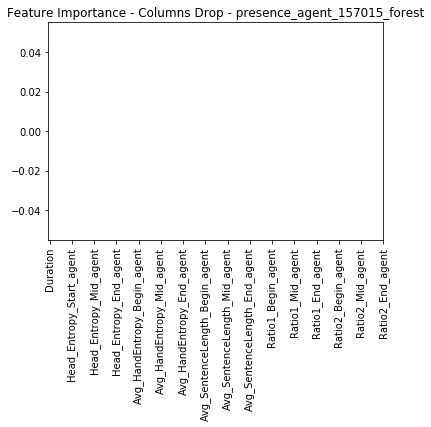

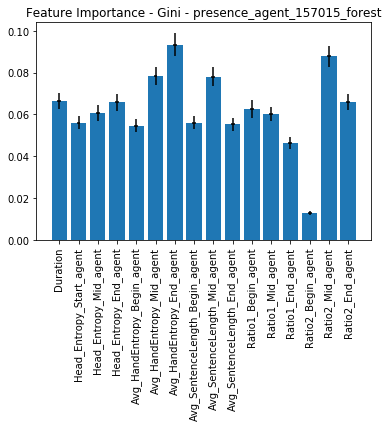

Test 11 : {'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'forest', 'subject': 'agent'}
phases (0.15, 0.7, 0.15)
prepare_train_data: target_model=copresence, features=Index([u'Duration', u'Head_Entropy_Start_agent', u'Head_Entropy_Mid_agent',
       u'Head_Entropy_End_agent', u'Avg_HandEntropy_Begin_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_HandEntropy_End_agent',
       u'Avg_SentenceLength_Begin_agent', u'Avg_SentenceLength_Mid_agent',
       u'Avg_SentenceLength_End_agent', u'Ratio1_Begin_agent',
       u'Ratio1_Mid_agent', u'Ratio1_End_agent', u'Ratio2_Begin_agent',
       u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({2L: 43, 3L: 41, 1L: 12}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, modelTarget=presence, param_

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.6min finished


  Gridsearch evaluated best score 0.6234816002257862
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1} ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    8.1s finished


iter # 9
      updating scores for presence_agent_157015_forest


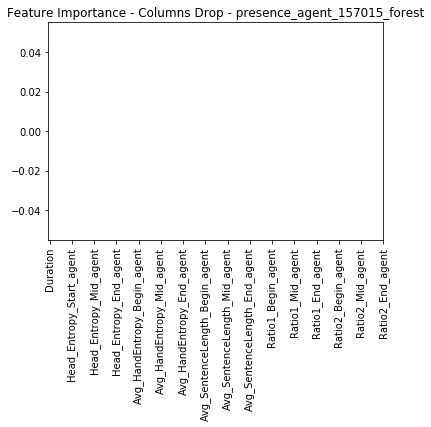

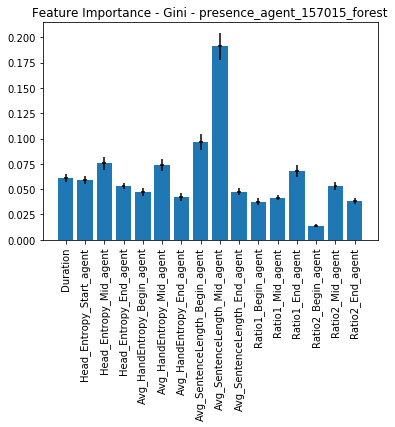

Test 12 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'svm', 'subject': 'doctor+agent'}
No phase
prepare_train_data: target_model=presence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration',
       u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({3L: 43, 2L: 35, 1L: 18}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'svc__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'svc__kernel': ['linear', 'rbf', 'sigmoid'], 'svc__C': array([ 0.01,  0.1 ,  1.  , 10.  ])}, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_Hand

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6147163344837763
    Running 10 iterations on best classifier {'svc__gamma': 1.0, 'svc__kernel': 'rbf', 'svc__C': 10.0} ...
iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 1
iter # 2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 3
iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


iter # 5
iter # 6
iter # 7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


iter # 8
iter # 9
      updating scores for presence_doctoragent_nophase_svm
Test 13 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'svm', 'subject': 'doctor+agent'}
No phase
prepare_train_data: target_model=copresence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration',
       u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({2L: 43, 3L: 41, 1L: 12}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'svc__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'svc__kernel': ['linear', 'rbf', 'sigmoid'], 'svc__C': array([ 0.01,  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.689057239057239
    Running 10 iterations on best classifier {'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__C': 1.0} ...
iter # 0
iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2
iter # 3
iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


iter # 5
iter # 6
iter # 7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


iter # 8
iter # 9
      updating scores for presence_doctoragent_nophase_svm
Test 14 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'svm', 'subject': 'doctor'}
No phase
prepare_train_data: target_model=presence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({3L: 43, 2L: 35, 1L: 18}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'svc__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'svc__kernel': ['linear', 'rbf', 'sigmoid'], 'svc__C': array([ 0.01,  0.1 ,  1.  , 10.  ])}, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Du

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6754732777988591
    Running 10 iterations on best classifier {'svc__gamma': 1.0, 'svc__kernel': 'rbf', 'svc__C': 1.0} ...
iter # 0
iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2
iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4
iter # 5
iter # 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


iter # 7
iter # 8
iter # 9
      updating scores for presence_doctor_nophase_svm
Test 15 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'svm', 'subject': 'doctor'}
No phase
prepare_train_data: target_model=copresence, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid', u'Duration'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({2L: 43, 3L: 41, 1L: 12}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'svc__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'svc__kernel': ['linear', 'rbf', 'sigmoid'], 'svc__C': array([ 0.01,  0.1 ,  1.  , 10.  ])}, features=Index([u'Expert', u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid',
       u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6476988558383907
    Running 10 iterations on best classifier {'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__C': 1.0} ...
iter # 0
iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2
iter # 3
iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 5
iter # 6
iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


iter # 8
iter # 9
      updating scores for presence_doctor_nophase_svm
Test 16 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'svm', 'subject': 'agent'}
No phase
prepare_train_data: target_model=presence, features=Index([u'Duration', u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({3L: 43, 2L: 35, 1L: 18}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'svc__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'svc__kernel': ['linear', 'rbf', 'sigmoid'], 'svc__C': array([ 0.01,  0.1 ,  1.  , 10.  ])}, features=Index([u'Duration', u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_ag

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6458204155878574
    Running 10 iterations on best classifier {'svc__gamma': 1.0, 'svc__kernel': 'rbf', 'svc__C': 1.0} ...
iter # 0
iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2
iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4
iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6
iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 8
iter # 9
      updating scores for presence_agent_nophase_svm


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Test 17 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'svm', 'subject': 'agent'}
No phase
prepare_train_data: target_model=copresence, features=Index([u'Duration', u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({2L: 43, 3L: 41, 1L: 12}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'svc__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'svc__kernel': ['linear', 'rbf', 'sigmoid'], 'svc__C': array([ 0.01,  0.1 ,  1.  , 10.  ])}, features=Index([u'Duration', u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


  Gridsearch evaluated best score 0.6102084823015056
    Running 10 iterations on best classifier {'svc__gamma': 1.0, 'svc__kernel': 'rbf', 'svc__C': 1.0} ...
iter # 0
iter # 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2
iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4
iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6
iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


iter # 8
iter # 9
      updating scores for presence_agent_nophase_svm
Test 18 : {'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'svm', 'subject': 'doctor+agent'}
phases (0.15, 0.7, 0.15)
prepare_train_data: target_model=presence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration', u'Head_Entropy_Start_agent',
       u'Head_Entropy_Mid_agent', u'Head_Entropy_End_agent',
       u'Avg_HandEntropy_Begin_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_HandEntropy_End_agent', u'Avg_SentenceLength_Begin_agent',
       u'Avg_SentenceLength_Mid_agent', u'Avg_SentenceLength_End_agent',
       u'Ratio1_Begin_agent', u'Ratio1_Mid_agent', u'Rat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.7354519726612749
    Running 10 iterations on best classifier {'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__C': 10.0} ...
iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 1
iter # 2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 3
iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 5
iter # 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 7
iter # 8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


iter # 9
      updating scores for presence_doctoragent_157015_svm
Test 19 : {'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'svm', 'subject': 'doctor+agent'}
phases (0.15, 0.7, 0.15)
prepare_train_data: target_model=copresence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration', u'Head_Entropy_Start_agent',
       u'Head_Entropy_Mid_agent', u'Head_Entropy_End_agent',
       u'Avg_HandEntropy_Begin_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_HandEntropy_End_agent', u'Avg_SentenceLength_Begin_agent',
       u'Avg_SentenceLength_Mid_agent', u'Avg_SentenceLength_End_agent',
       u'Ratio1_Begin_agent', u'Ratio1_Mid_agent', u'Rat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.6713894202266295
    Running 10 iterations on best classifier {'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__C': 10.0} ...
iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 1
iter # 2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 3
iter # 4


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 5
iter # 6


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 7
iter # 8


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


iter # 9
      updating scores for presence_doctoragent_157015_svm
Test 20 : {'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'svm', 'subject': 'doctor'}
phases (0.15, 0.7, 0.15)
prepare_train_data: target_model=presence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({3L: 43, 2L: 35, 1L: 18}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'svc__gamma': array([1.e-03, 1.e-02, 1.e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.708493014306968
    Running 10 iterations on best classifier {'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__C': 10.0} ...
iter # 0
iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2
iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4
iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6
iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 8
iter # 9
      updating scores for presence_doctor_157015_svm


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Test 21 : {'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'svm', 'subject': 'doctor'}
phases (0.15, 0.7, 0.15)
prepare_train_data: target_model=copresence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({2L: 43, 3L: 41, 1L: 12}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'svc__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'svc__kernel': ['linear', 'rbf', 'sigmoi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    5.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.7430036802129827
    Running 10 iterations on best classifier {'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__C': 10.0} ...
iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 1
iter # 2


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 3
iter # 4
iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


iter # 6
iter # 7
iter # 8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


iter # 9
      updating scores for presence_doctor_157015_svm
Test 22 : {'phases': (0.15, 0.7, 0.15), 'target': 'presence', 'classifier': 'svm', 'subject': 'agent'}
phases (0.15, 0.7, 0.15)
prepare_train_data: target_model=presence, features=Index([u'Duration', u'Head_Entropy_Start_agent', u'Head_Entropy_Mid_agent',
       u'Head_Entropy_End_agent', u'Avg_HandEntropy_Begin_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_HandEntropy_End_agent',
       u'Avg_SentenceLength_Begin_agent', u'Avg_SentenceLength_Mid_agent',
       u'Avg_SentenceLength_End_agent', u'Ratio1_Begin_agent',
       u'Ratio1_Mid_agent', u'Ratio1_End_agent', u'Ratio2_Begin_agent',
       u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({3L: 43, 2L: 35, 1L: 18}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.pipeline.Pipeli

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    6.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.746118437978903
    Running 10 iterations on best classifier {'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__C': 1.0} ...
iter # 0


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


iter # 1
iter # 2
iter # 3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


iter # 4
iter # 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6
iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 8
iter # 9
      updating scores for presence_agent_157015_svm


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Test 23 : {'phases': (0.15, 0.7, 0.15), 'target': 'copresence', 'classifier': 'svm', 'subject': 'agent'}
phases (0.15, 0.7, 0.15)
prepare_train_data: target_model=copresence, features=Index([u'Duration', u'Head_Entropy_Start_agent', u'Head_Entropy_Mid_agent',
       u'Head_Entropy_End_agent', u'Avg_HandEntropy_Begin_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_HandEntropy_End_agent',
       u'Avg_SentenceLength_Begin_agent', u'Avg_SentenceLength_Mid_agent',
       u'Avg_SentenceLength_End_agent', u'Ratio1_Begin_agent',
       u'Ratio1_Mid_agent', u'Ratio1_End_agent', u'Ratio2_Begin_agent',
       u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Original data 96 / Counter({2L: 43, 3L: 41, 1L: 12}) / unique 96
prepare_train_data: Resampled data 129 / Counter({1: 43, 2: 43, 3: 43}) / unique 129
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'svc__gamma': arra

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  Gridsearch evaluated best score 0.634295420341932
    Running 10 iterations on best classifier {'svc__gamma': 0.1, 'svc__kernel': 'rbf', 'svc__C': 1.0} ...
iter # 0
iter # 1


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 2
iter # 3


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 4
iter # 5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iter # 6
iter # 7


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


iter # 8
iter # 9
      updating scores for presence_agent_157015_svm


In [29]:
forest = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True)
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE))


# parameters
repeat = 10
repeat_dc = 300
cv = 10
fi = False # whether to compute dropcol feature importance or not
upsample='imb_smote'
verbose=1

for idx, test in enumerate(test_plan):
    print("Test %d : %s" % (idx, test))
    
    # make it global because we use them to compute feature importance for forests
    all_feature_importances = []    
    all_dropcol_feature_importances = []

    subject = test['subject']
    target = test['target']
    phases = test['phases']
    classifier = test['classifier']
    clf = forest if classifier == 'forest' else svm
    pgrid = param_grid_rf if classifier == 'forest' else param_grid_svm

    if phases is not None and not phases == (0,1,0):
        print("phases " + str(phases))
        if subject == 'doctor':
            df = subject_p_df
            feats = subject_features
        elif subject == 'agent':
            df = agent_p_df
            feats = agent_features
        elif subject == 'doctor+agent':
            df = all_p_df
            feats=all_features
    else:
        print("No phase")
        if subject == 'doctor':
            df = subject_np_df
            feats = subject_features_nophase
        elif subject == 'agent':
            df = agent_np_df
            feats = agent_features_nophase
        elif subject == 'doctor+agent':
            df = all_np_df
            feats=all_features_nophase   

    start = time.time()
            
    #X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample, verbose=verbose) 
    grid, scores, dropcol_fis, fis, support = run_gridsearch(clf, 
                                                    pgrid, 
                                                    df, feats, 
                                                    target, 
                                                    repeat=repeat, repeat_dc=repeat_dc, 
                                                    upsample=upsample, 
                                                    verbose=verbose)

    elapsed = time.time() - start
    
    isDoc = 'doctor' in subject
    isAgent = 'agent' in subject
    #save_grid(grid, presence=target=='presence', doctor=isDoc, agent=isAgent,
    #         phases=phases, classifier='RF' if test['classifier']=='forest' else 'SVM')

    presidx = 'Presence' if target == 'presence' else 'Co-Presence'
    if subject == 'doctor':
        subjidx = 'Doctor'
    elif subject == 'agent':
        subjidx = 'Agent'
    else:
        subjidx = 'Doctor+Agent'
    phidx = 'No Phase' if phases in [None, (0,1,0)] else '%2d%2d%2d' % ( phases[0]*100, phases[1]*100, phases[2]*100 )
    clfidx = 'Random Forests' if classifier == 'forest' else 'SVM'

    # compute err
    all_scores_ = scores.drop(['fit_time', 'score_time'], axis=1).T
    final = pd.DataFrame(index=all_scores_.index)
    final['means'] = all_scores_.mean(axis=1)
    final['std'] = all_scores_.std(axis=1)

    test_set_name = dh.get_grid_name(target, isDoc, isAgent, phases, classifier)
    print("      updating scores for %s" % test_set_name)
    #print("final" , final)
    scores_df = update_results(scores_df, pd.DataFrame(final.T.loc['means']).T, presidx, subjidx, phidx, clfidx, 'score')
    scores_df = update_results(scores_df, pd.DataFrame(final.T.loc['std']).T, presidx, subjidx, phidx, clfidx, 'err')    
    dh.save_obj(scores_df, 'results', 'scores')
    
    dumpPath = os.path.join(dh.root_path, 'results', 'scores.xlsx')
    scores_df.to_excel(dumpPath, index=True)
    
    ctx = [[upsample, cv, repeat, repeat_dc, grid.best_params_, elapsed, support, feats], [0,0,0,0,0,0,0,0]]
    ctx_df = pd.DataFrame(ctx, columns=['UpSample', 'KFolds K', 'KFolds repetitions', 'Repetitions for features importance',
                     'Best Params', 'Time (s)', 'Support', 'Features'])
    for col in ctx_df.columns:
        if col in ['Best Params', 'Support', 'Features']:
            context_df.loc[(presidx, subjidx, phidx, clfidx, 'score'), col] = str(ctx_df[col][0])
        else:
            #print("col %s" % col)
            context_df.loc[(presidx, subjidx, phidx, clfidx, 'score'), col] = ctx_df[col][0]
    dumpPath = os.path.join(dh.root_path, '.',  'context.csv')
    context_df.to_csv(dumpPath, index=True)
    

    # features importances
    if dropcol_fis is not None:
        final_fi = dropcol_fis.T
        final_fi['means'] = final_fi.mean(axis=1)
        final_fi['std'] = final_fi.std(axis=1)
        final_fi['sem'] = final_fi.sem(axis=1)
        final_fi['confidence'] = final_fi.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)
        plot_importance('Columns Drop - ' + test_set_name, 
                        final_fi['means'],
                        final_fi['confidence'],
                        feats, 
                        sort=False)
        dumpPath = os.path.join(dh.root_path, 'results', 'features_importances_dropcol_%s.xlsx' % test_set_name)
        final_fi.to_excel(dumpPath, index=True)


    if fis is not None:
        final_fi_ = fis.T
        final_fi_['means'] = final_fi_.mean(axis=1)
        final_fi_['std'] = final_fi_.std(axis=1)
        final_fi_['sem'] = final_fi_.sem(axis=1)
        final_fi_['confidence'] = final_fi_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)
        plot_importance('Gini - ' + test_set_name, 
                        final_fi_['means'],
                        final_fi_['confidence'],
                        feats, 
                        sort=False)
        dumpPath = os.path.join(dh.root_path, 'results', 'features_importances_%s.xlsx' % test_set_name)
        final_fi.to_excel(dumpPath, index=True)


### Results summary

In [156]:
clf.fit(X,y)
print(clf.score(X, y))

1.0


# Verbal, non-verbal, multi-modal and multi-modal + duration

In [98]:
# prepare results dataframes

dh = DataHandler('oversampling_method', 'verbal-nonverbal', 0)

scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['Verbal', 'Non-Verbal', 'Multimodal'], 
             ['Random Forests', 'SVM', 'Gaussian Naive Bayes'],
             ['None', 'imb_random', 'imb_smote', 'imb_adasyn', 'imb_smotenc', 'imb_borderlinesmote1', 
                   'imb_borderlinesmote2', 'imb_svmsmote'],
             ['score', 'err']
            ]
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Target', 'Subject', 'Mode', 'Classifier', 'Oversampling', 'Metric'])

scores_df = dh.load_obj('results', 'scores')
print(len(scores_df_multiindex.to_flat_index()))
if scores_df is None:
    scores_df = pd.DataFrame(index=scores_df_multiindex)
    #scores_df = pd.DataFrame(np.zeros((len(scores_df_multiindex.to_flat_index()),4)), 
    #                         index=scores_df_multiindex, 
    #                         columns=scores_df_columns)
    #scores_df['params'] = scores_df['params'].apply(str)
    #scores_df['params'] = ''
    dh.save_obj(scores_df, 'results', 'scores')
    
    
context_df = dh.load_obj('.', 'context')
if context_df is None:
    context_df = pd.DataFrame(index=scores_df_multiindex)
    context_df['Best Params'] = ''
    context_df['Best Params'] = context_df['Best Params'].apply(str)
    dh.save_obj(context_df, '.', 'context')
    
scores_df

file does not yet exist C:\IAAA\TER\_output\oversampling_method\verbal-nonverbal-0\results\scores.pkl
864
file does not yet exist C:\IAAA\TER\_output\oversampling_method\verbal-nonverbal-0\.\context.pkl


Empty DataFrame
Columns: []
Index: [(Presence, Doctor, Verbal, Random Forests, None, score), (Presence, Doctor, Verbal, Random Forests, None, err), (Presence, Doctor, Verbal, Random Forests, imb_random, score), (Presence, Doctor, Verbal, Random Forests, imb_random, err), (Presence, Doctor, Verbal, Random Forests, imb_smote, score), (Presence, Doctor, Verbal, Random Forests, imb_smote, err), (Presence, Doctor, Verbal, Random Forests, imb_adasyn, score), (Presence, Doctor, Verbal, Random Forests, imb_adasyn, err), (Presence, Doctor, Verbal, Random Forests, imb_smotenc, score), (Presence, Doctor, Verbal, Random Forests, imb_smotenc, err), (Presence, Doctor, Verbal, Random Forests, imb_borderlinesmote1, score), (Presence, Doctor, Verbal, Random Forests, imb_borderlinesmote1, err), (Presence, Doctor, Verbal, Random Forests, imb_borderlinesmote2, score), (Presence, Doctor, Verbal, Random Forests, imb_borderlinesmote2, err), (Presence, Doctor, Verbal, Random Forests, imb_svmsmote, score), (Presence, Doctor, Verbal, Random Forests, imb_svmsmote, err), (Presence, Doctor, Verbal, SVM, None, score), (Presence, Doctor, Verbal, SVM, None, err), (Presence, Doctor, Verbal, SVM, imb_random, score), (Presence, Doctor, Verbal, SVM, imb_random, err), (Presence, Doctor, Verbal, SVM, imb_smote, score), (Presence, Doctor, Verbal, SVM, imb_smote, err), (Presence, Doctor, Verbal, SVM, imb_adasyn, score), (Presence, Doctor, Verbal, SVM, imb_adasyn, err), (Presence, Doctor, Verbal, SVM, imb_smotenc, score), (Presence, Doctor, Verbal, SVM, imb_smotenc, err), (Presence, Doctor, Verbal, SVM, imb_borderlinesmote1, score), (Presence, Doctor, Verbal, SVM, imb_borderlinesmote1, err), (Presence, Doctor, Verbal, SVM, imb_borderlinesmote2, score), (Presence, Doctor, Verbal, SVM, imb_borderlinesmote2, err), (Presence, Doctor, Verbal, SVM, imb_svmsmote, score), (Presence, Doctor, Verbal, SVM, imb_svmsmote, err), (Presence, Doctor, Verbal, Gaussian Naive Bayes, None, score), (Presence, Doctor, Verbal, Gaussian Naive Bayes, None, err), (Presence, Doctor, Verbal, Gaussian Naive Bayes, imb_random, score), (Presence, Doctor, Verbal, Gaussian Naive Bayes, imb_random, err), (Presence, Doctor, Verbal, Gaussian Naive Bayes, imb_smote, score), (Presence, Doctor, Verbal, Gaussian Naive Bayes, imb_smote, err), (Presence, Doctor, Verbal, Gaussian Naive Bayes, imb_adasyn, score), (Presence, Doctor, Verbal, Gaussian Naive Bayes, imb_adasyn, err), (Presence, Doctor, Verbal, Gaussian Naive Bayes, imb_smotenc, score), (Presence, Doctor, Verbal, Gaussian Naive Bayes, imb_smotenc, err), (Presence, Doctor, Verbal, Gaussian Naive Bayes, imb_borderlinesmote1, score), (Presence, Doctor, Verbal, Gaussian Naive Bayes, imb_borderlinesmote1, err), (Presence, Doctor, Verbal, Gaussian Naive Bayes, imb_borderlinesmote2, score), (Presence, Doctor, Verbal, Gaussian Naive Bayes, imb_borderlinesmote2, err), (Presence, Doctor, Verbal, Gaussian Naive Bayes, imb_svmsmote, score), (Presence, Doctor, Verbal, Gaussian Naive Bayes, imb_svmsmote, err), (Presence, Doctor, Non-Verbal, Random Forests, None, score), (Presence, Doctor, Non-Verbal, Random Forests, None, err), (Presence, Doctor, Non-Verbal, Random Forests, imb_random, score), (Presence, Doctor, Non-Verbal, Random Forests, imb_random, err), (Presence, Doctor, Non-Verbal, Random Forests, imb_smote, score), (Presence, Doctor, Non-Verbal, Random Forests, imb_smote, err), (Presence, Doctor, Non-Verbal, Random Forests, imb_adasyn, score), (Presence, Doctor, Non-Verbal, Random Forests, imb_adasyn, err), (Presence, Doctor, Non-Verbal, Random Forests, imb_smotenc, score), (Presence, Doctor, Non-Verbal, Random Forests, imb_smotenc, err), (Presence, Doctor, Non-Verbal, Random Forests, imb_borderlinesmote1, score), (Presence, Doctor, Non-Verbal, Random Forests, imb_borderlinesmote1, err), (Presence, Doctor, Non-Verbal, Random Forests, imb_borderlinesmote2, score), (Presence, Doctor, Non-Verbal, Random Forests, imb_borderlinesmote2, err), (Presence, Doctor, N

### Test plan definition

In [100]:
from sklearn.model_selection import ParameterGrid
test_plan_params = {
    'classifier': ['gnb', 'forest', 'svm'],
    'subject': ['doctor', 'agent', 'doctor+agent'],
    'target': ['presence', 'copresence'],
    'modes': ['verbal', 'nonverbal', 'multimodal'],
    'upsampling': [None, 'imb_random', 'imb_smote', 'imb_adasyn', 'imb_smotenc', 'imb_borderlinesmote1', 
                   'imb_borderlinesmote2', 'imb_svmsmote']
}
test_plan = list(ParameterGrid(test_plan_params))
print("%d tests to be performed" % len(test_plan))
for test in test_plan:
    print(test)

432 tests to be performed
{'upsampling': None, 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
{'upsampling': 'imb_random', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
{'upsampling': 'imb_smote', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
{'upsampling': 'imb_adasyn', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
{'upsampling': 'imb_smotenc', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
{'upsampling': 'imb_borderlinesmote1', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
{'upsampling': 'imb_borderlinesmote2', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
{'upsampling': 'imb_svmsmote', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
{'upsampling': None, 'subject': 'doctor', 'target': 'copresence'

### Run

['standardscaler__with_mean', 'standardscaler__copy', 'gaussiannb__var_smoothing', 'gaussiannb', 'gaussiannb__priors', 'steps', 'memory', 'standardscaler__with_std', 'standardscaler']
Test 0 : {'upsampling': None, 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=None
prepare_train_data: unique 95
prepare_train_data: Resampled data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([14, 26, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.23976704879482658
    Running 10 iteration

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


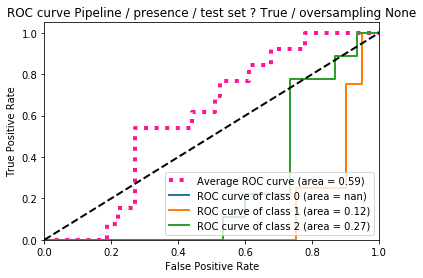

   Elapsed %s seconds0.22200012207
Test 1 : {'upsampling': 'imb_random', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=imb_random
prepare_train_data: unique 95
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.3703869047619048
    Running 10 iterations on best classifier {'gaussian

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


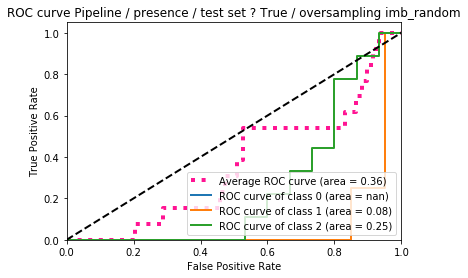

   Elapsed %s seconds0.229000091553
Test 2 : {'upsampling': 'imb_smote', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=imb_smote
prepare_train_data: unique 95
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.4332093253968254
    Running 10 iterations on best classifier {'gaussiannb

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


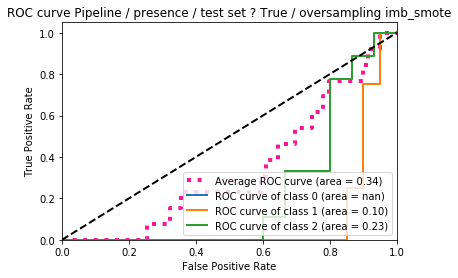

   Elapsed %s seconds0.253999948502
Test 3 : {'upsampling': 'imb_adasyn', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 95
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 4 : {'upsampling': 'imb_smotenc', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=imb_smotenc
prepare_train_data: unique 95
('   Error ', TypeError('__init__() takes at least 2 arguments (2 given)',))
Test 5 : {'upsampling': 'imb_borderlinesmote1', 'subject': 'doctor', 'ta

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


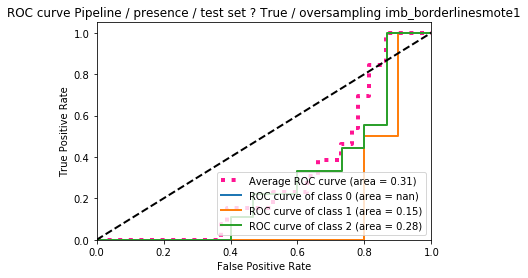

   Elapsed %s seconds0.25
Test 6 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 95
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 95 / Counter({1: 32, 3: 32, 2: 31}) / unique 95
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 31, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.3461152882205514
    Running 10 iterations on best

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


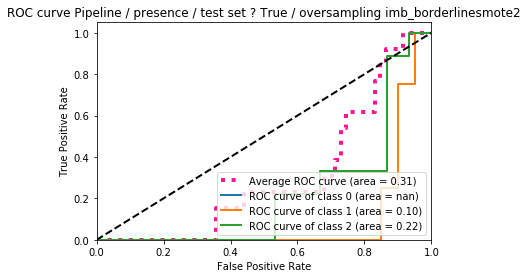

   Elapsed %s seconds0.209999799728
Test 7 : {'upsampling': 'imb_svmsmote', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 95
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 88 / Counter({2: 32, 3: 32, 1: 24}) / unique 88
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([24, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.4016714766714768
    Running 10 iterations on best classifier {'g

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


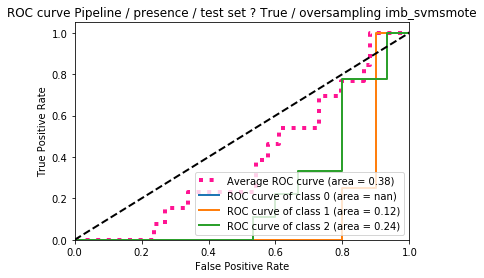

   Elapsed %s seconds0.211000204086
Test 8 : {'upsampling': None, 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=None
prepare_train_data: unique 95
prepare_train_data: Resampled data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 71
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([ 9, 32, 31]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.2422371866816311
    Running 10 iterations on best classifier {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None} ...
Balanced accuracy score: 0
              precision    re

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


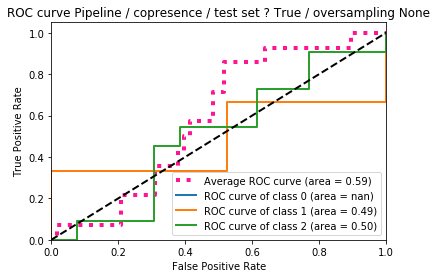

   Elapsed %s seconds0.224999904633
Test 9 : {'upsampling': 'imb_random', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=imb_random
prepare_train_data: unique 95
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 71
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 71
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.3981519059644059
    Running 10 iterations on best classifier {'gaus

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


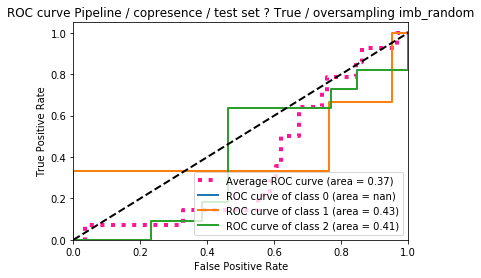

   Elapsed %s seconds0.214999914169
Test 10 : {'upsampling': 'imb_smote', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=imb_smote
prepare_train_data: unique 95
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 71
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 95
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.35290854978354974
    Running 10 iterations on best classifier {'gauss

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


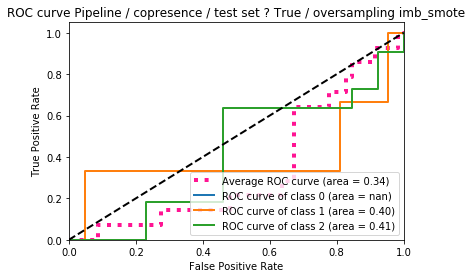

   Elapsed %s seconds0.293999910355
Test 11 : {'upsampling': 'imb_adasyn', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 95
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 71
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 12 : {'upsampling': 'imb_smotenc', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=imb_smotenc
prepare_train_data: unique 95
('   Error ', TypeError('__init__() takes at least 2 arguments (2 given)',))
Test 13 : {'upsampling': 'imb_borderlinesmote1', 'subject': 'do

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


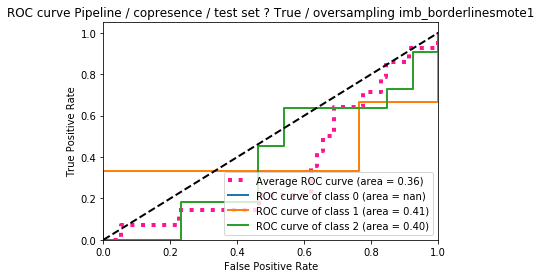

   Elapsed %s seconds0.213000059128
Test 14 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 95
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 71
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 95
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.3748834498834499
    Running 10 iter

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


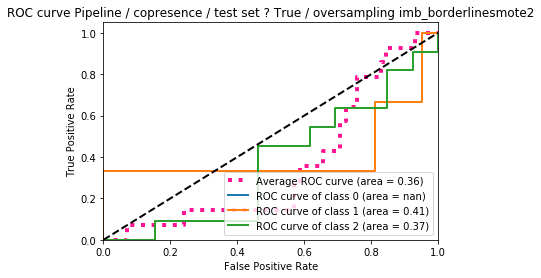

   Elapsed %s seconds0.208000183105
Test 15 : {'upsampling': 'imb_svmsmote', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 95
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 71
prepare_train_data: Resampled data 86 / Counter({2: 32, 3: 32, 1: 22}) / unique 85
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([22, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.347249907715024
    Running 10 iterations on best classifier 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


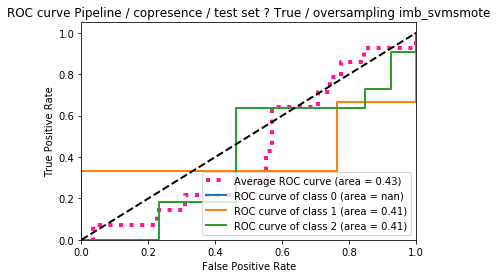

   Elapsed %s seconds0.211999893188
Test 16 : {'upsampling': None, 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=None
prepare_train_data: unique 96
prepare_train_data: Resampled data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([14, 26, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.292526455026455
    Running 10 iterations on best classifier {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None} ..

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


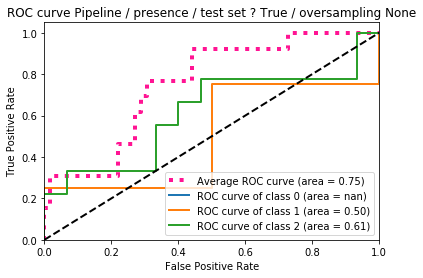

   Elapsed %s seconds0.213000059128
Test 17 : {'upsampling': 'imb_random', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_random
prepare_train_data: unique 96
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.412285052

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


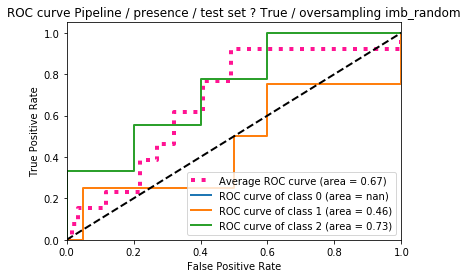

   Elapsed %s seconds0.203000068665
Test 18 : {'upsampling': 'imb_smote', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.339707341269

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


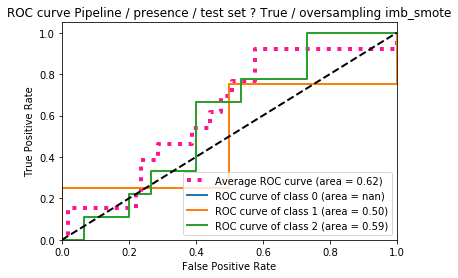

   Elapsed %s seconds0.201999902725
Test 19 : {'upsampling': 'imb_adasyn', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 96
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 20 : {'upsampling': 'imb_smotenc', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
prepare_train_data: unique 96
('   Error ', TypeError('__init__() takes at least 2 arguments (2 given)',))
Test 21 : 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


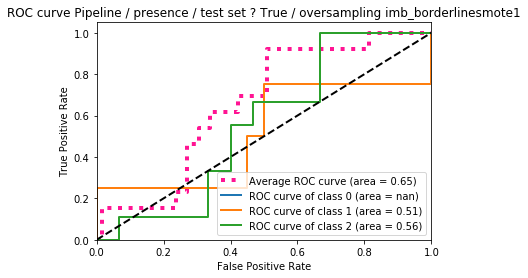

   Elapsed %s seconds0.210000038147
Test 22 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 96
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 95 / Counter({1: 32, 3: 32, 2: 31}) / unique 95
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 31, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


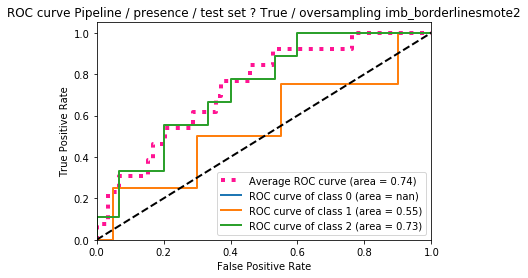

   Elapsed %s seconds0.232999801636
Test 23 : {'upsampling': 'imb_svmsmote', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 96
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 88 / Counter({2: 32, 3: 32, 1: 24}) / unique 88
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([24, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.394

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


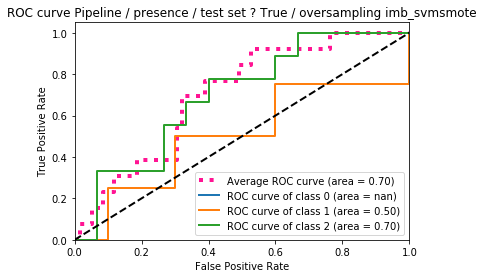

   Elapsed %s seconds0.210000038147
Test 24 : {'upsampling': None, 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=None
prepare_train_data: unique 96
prepare_train_data: Resampled data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([ 9, 32, 31]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.2971524103468548
    Running 10 iterations on best classifier {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


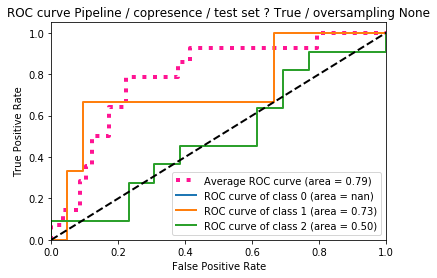

   Elapsed %s seconds0.212999820709
Test 25 : {'upsampling': 'imb_random', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_random
prepare_train_data: unique 96
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.408507

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


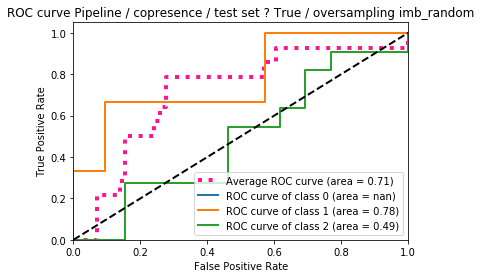

   Elapsed %s seconds0.246999979019
Test 26 : {'upsampling': 'imb_smote', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.384706439

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


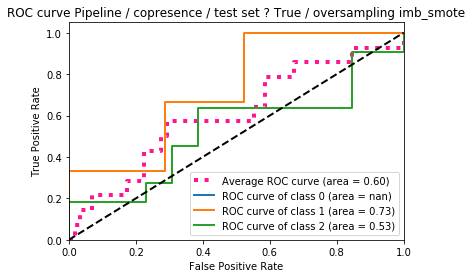

   Elapsed %s seconds0.240000009537
Test 27 : {'upsampling': 'imb_adasyn', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 96
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 28 : {'upsampling': 'imb_smotenc', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
prepare_train_data: unique 96
('   Error ', TypeError('__init__() takes at least 2 arguments (2 given)',))
Tes

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


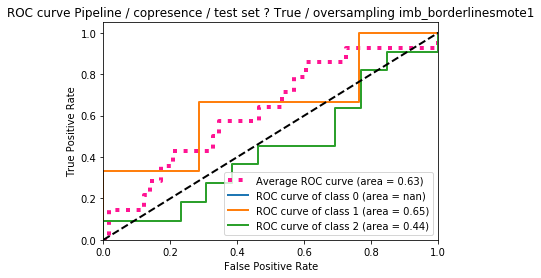

   Elapsed %s seconds0.238000154495
Test 30 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 96
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearc

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


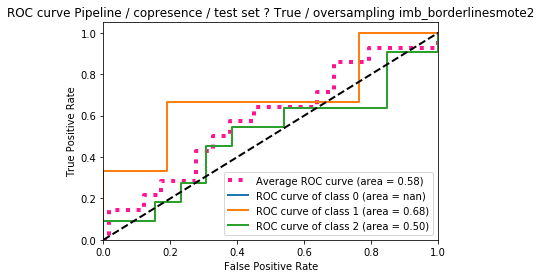

   Elapsed %s seconds0.214999914169
Test 31 : {'upsampling': 'imb_svmsmote', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 96
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 86 / Counter({2: 32, 3: 32, 1: 22}) / unique 86
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([22, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


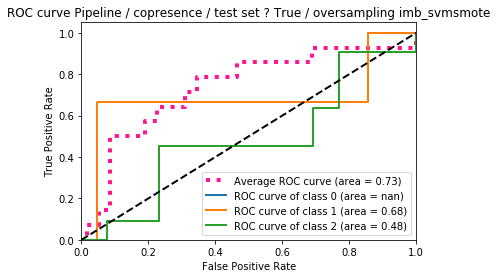

   Elapsed %s seconds0.223999977112
Test 32 : {'upsampling': None, 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=None
prepare_train_data: unique 96
prepare_train_data: Resampled data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([14, 26, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best s

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


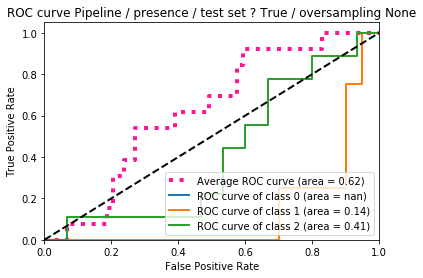

   Elapsed %s seconds0.274999856949
Test 33 : {'upsampling': 'imb_random', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_random
prepare_train_data: unique 96
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


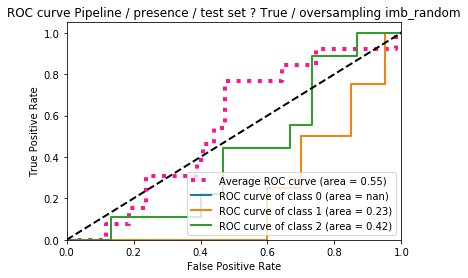

   Elapsed %s seconds0.206000089645
Test 34 : {'upsampling': 'imb_smote', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


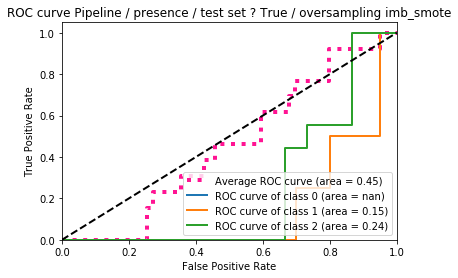

   Elapsed %s seconds0.204999923706
Test 35 : {'upsampling': 'imb_adasyn', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 96
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 36 : {'upsampling': 'imb_smotenc', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


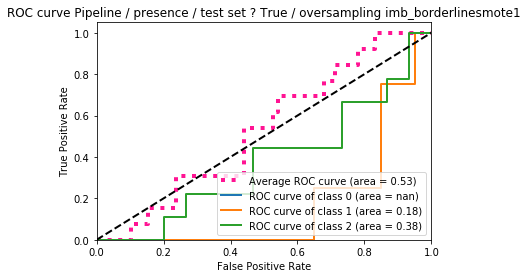

   Elapsed %s seconds0.242999792099
Test 38 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 96
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 95 / Counter({1: 32, 3: 32, 2: 31}) / unique 95
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='obj

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


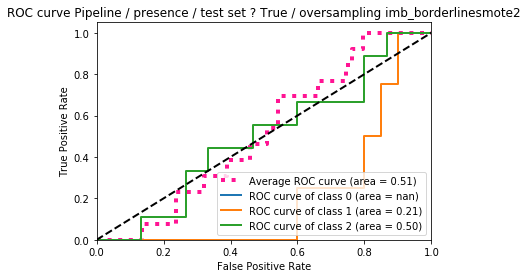

   Elapsed %s seconds0.238000154495
Test 39 : {'upsampling': 'imb_svmsmote', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 96
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 88 / Counter({2: 32, 3: 32, 1: 24}) / unique 88
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


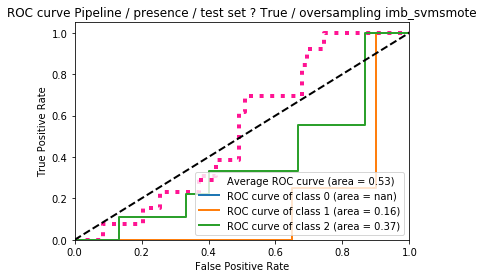

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.210999965668
Test 40 : {'upsampling': None, 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=None
prepare_train_data: unique 96
prepare_train_data: Resampled data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([ 9, 32, 31]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated bes

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


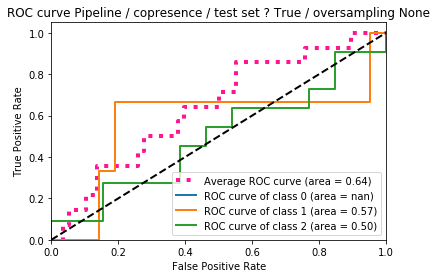

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.263000011444
Test 41 : {'upsampling': 'imb_random', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_random
prepare_train_data: unique 96
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dty

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


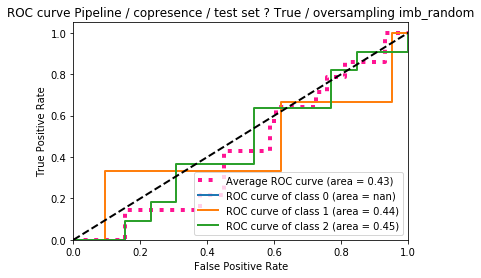

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.209000110626
Test 42 : {'upsampling': 'imb_smote', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


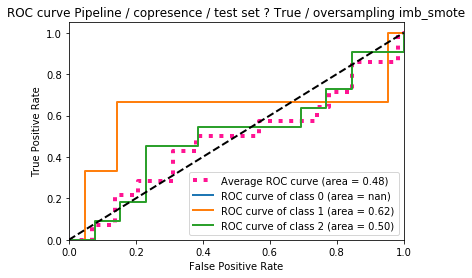

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.216000080109
Test 43 : {'upsampling': 'imb_adasyn', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 96
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 44 : {'upsampling': 'imb_smotenc', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


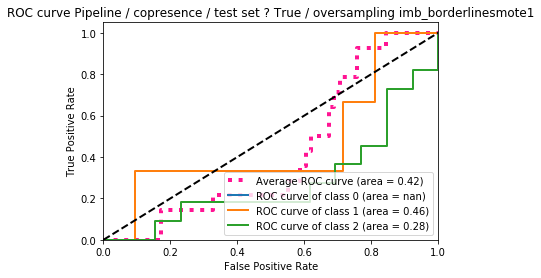

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.217000007629
Test 46 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 96
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


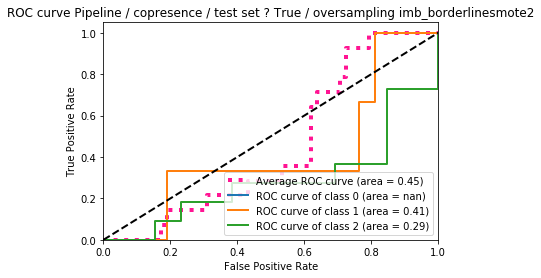

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.216000080109
Test 47 : {'upsampling': 'imb_svmsmote', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'verbal'}
prepare_train_data: target_model=copresence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 96
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 86 / Counter({2: 32, 3: 32, 1: 22}) / unique 86
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


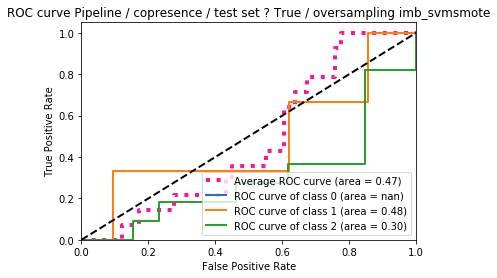

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.213999986649
Test 48 : {'upsampling': None, 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'), upsamples=None
prepare_train_data: unique 96
prepare_train_data: Resampled data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([14, 26, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.3806878306878307
    Running 10 iterations on best classifier {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None} ...
Balanced accuracy score: 0
              precision    recall  f1-score   suppor

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


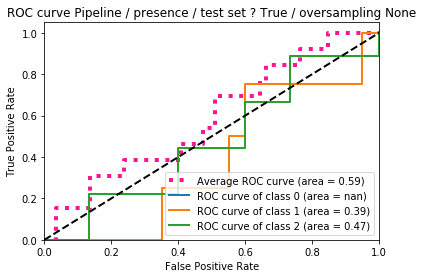

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.220999956131
Test 49 : {'upsampling': 'imb_random', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'), upsamples=imb_random
prepare_train_data: unique 96
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.41591654872904876
    Running 10 iterations on best classifier {'gaussiannb__var_smoothing'

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


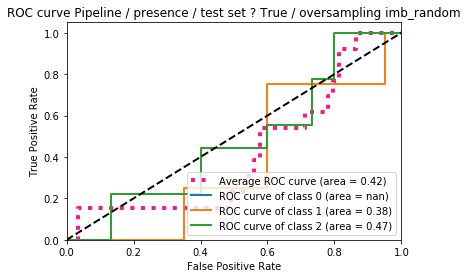

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.210000038147
Test 50 : {'upsampling': 'imb_smote', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.4231586122211122
    Running 10 iterations on best classifier {'gaussiannb__var_smoothing': 1e

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


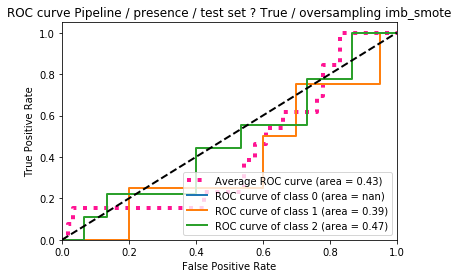

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.218999862671
Test 51 : {'upsampling': 'imb_adasyn', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 96
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 52 : {'upsampling': 'imb_smotenc', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'), upsamples=imb_smotenc
prepare_train_data: unique 96
('   Error ', TypeError('__init__() takes at least 2 arguments (2 given)',))
Test 53 : {'upsampling': 'imb_borderlinesmote1', 'subject': 'doctor', 'target': 'presenc

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


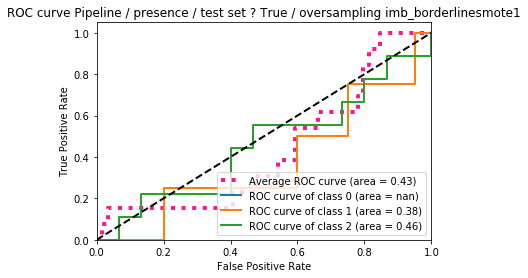

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.221999883652
Test 54 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 96
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 95 / Counter({1: 32, 3: 32, 2: 31}) / unique 95
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 31, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.44602946760841505
    Running 10 iterations on best classifi

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


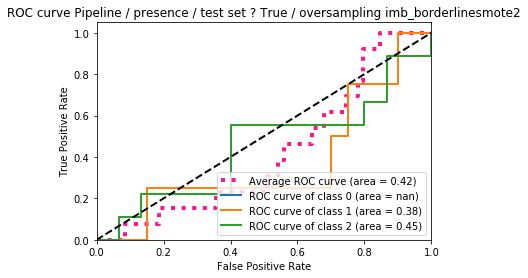

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.216000080109
Test 55 : {'upsampling': 'imb_svmsmote', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 96
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 88 / Counter({2: 32, 3: 32, 1: 24}) / unique 88
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([24, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.3857233044733045
    Running 10 iterations on best classifier {'gaussiannb__var_smoot

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


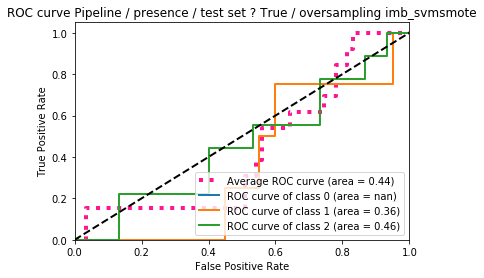

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.263000011444
Test 56 : {'upsampling': None, 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'), upsamples=None
prepare_train_data: unique 96
prepare_train_data: Resampled data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([ 9, 32, 31]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.40606995884773667
    Running 10 iterations on best classifier {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None} ...
Balanced accuracy score: 0
              precision    recall  f1-score   su

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


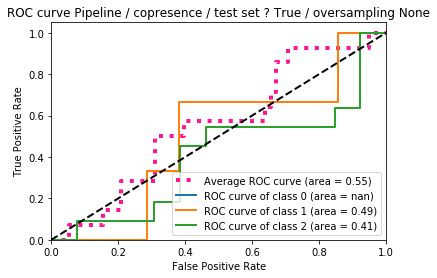

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.22000002861
Test 57 : {'upsampling': 'imb_random', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'), upsamples=imb_random
prepare_train_data: unique 96
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.4588135822510823
    Running 10 iterations on best classifier {'gaussiannb__var_smoothing

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


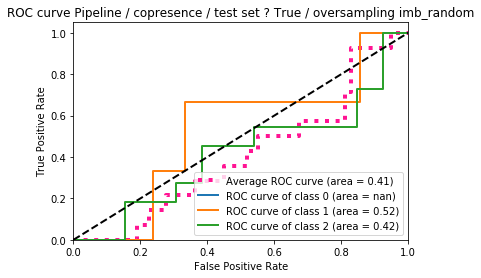

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.210999965668
Test 58 : {'upsampling': 'imb_smote', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.45163765632515634
    Running 10 iterations on best classifier {'gaussiannb__var_smoothing'

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


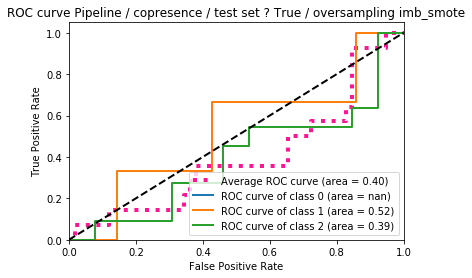

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.210000038147
Test 59 : {'upsampling': 'imb_adasyn', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 96
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 60 : {'upsampling': 'imb_smotenc', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'), upsamples=imb_smotenc
prepare_train_data: unique 96
('   Error ', TypeError('__init__() takes at least 2 arguments (2 given)',))
Test 61 : {'upsampling': 'imb_borderlinesmote1', 'subject': 'doctor', 'target': '

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


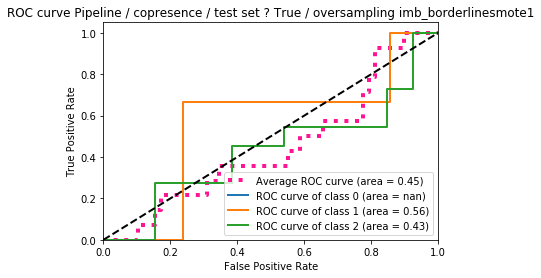

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.216000080109
Test 62 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 96
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.5138317700817702
    Running 10 iterations on best classi

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


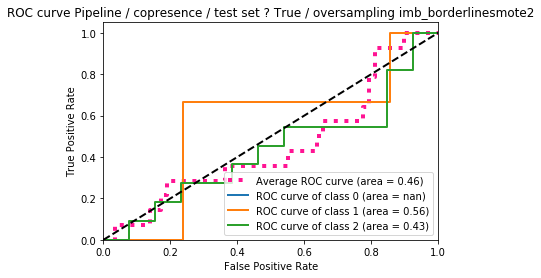

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.223000049591
Test 63 : {'upsampling': 'imb_svmsmote', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 96
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 86 / Counter({2: 32, 3: 32, 1: 22}) / unique 86
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([22, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.44119601328903657
    Running 10 iterations on best classifier {'gaussiannb__var_s

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


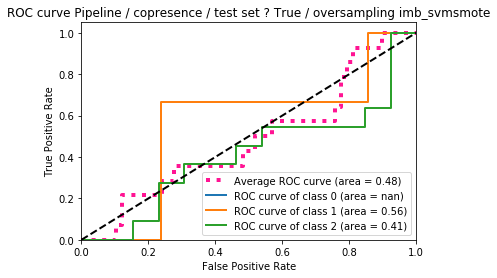

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.231999874115
Test 64 : {'upsampling': None, 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'), upsamples=None
prepare_train_data: unique 96
prepare_train_data: Resampled data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([14, 26, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.3806878306878307
    Running 10 iterations on best classifier {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None} ...
Balanced accuracy score: 0
              precision    re

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


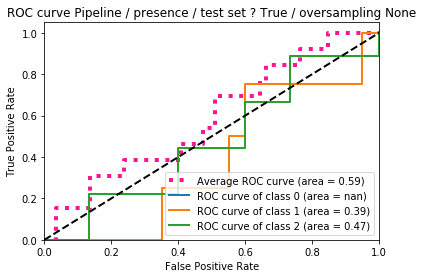

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.230999946594
Test 65 : {'upsampling': 'imb_random', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'), upsamples=imb_random
prepare_train_data: unique 96
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.41591654872904876
    Running 10 iterations on best classifier {'gau

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


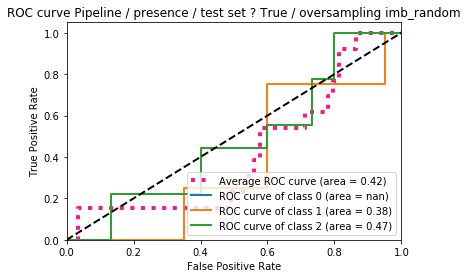

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.213999986649
Test 66 : {'upsampling': 'imb_smote', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.4231586122211122
    Running 10 iterations on best classifier {'gaussia

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


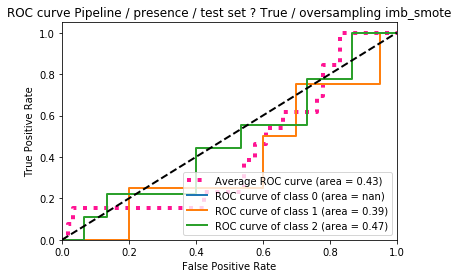

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.214999914169
Test 67 : {'upsampling': 'imb_adasyn', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 96
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 68 : {'upsampling': 'imb_smotenc', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'), upsamples=imb_smotenc
prepare_train_data: unique 96
('   Error ', TypeError('__init__() takes at least 2 arguments (2 given)',))
Test 69 : {'upsampling': 'imb_borderlinesmote1', 'subject': 'agent

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


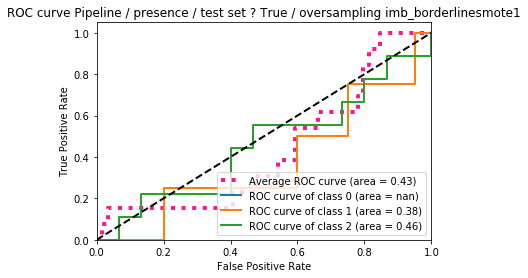

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.213999986649
Test 70 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 96
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 95 / Counter({1: 32, 3: 32, 2: 31}) / unique 95
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 31, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.44602946760841505
    Running 10 iter

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


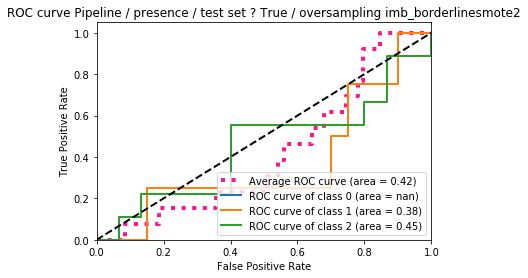

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.269000053406
Test 71 : {'upsampling': 'imb_svmsmote', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 96
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 88 / Counter({2: 32, 3: 32, 1: 24}) / unique 88
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([24, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.3857233044733045
    Running 10 iterations on best classifier 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


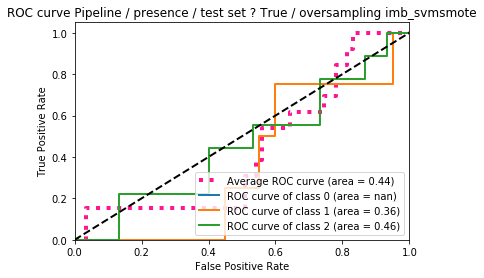

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.249000072479
Test 72 : {'upsampling': None, 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'), upsamples=None
prepare_train_data: unique 96
prepare_train_data: Resampled data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([ 9, 32, 31]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.40606995884773667
    Running 10 iterations on best classifier {'gaussiannb__var_smoothing': 1e-09, 'gaussiannb__priors': None} ...
Balanced accuracy score: 0
              precision  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


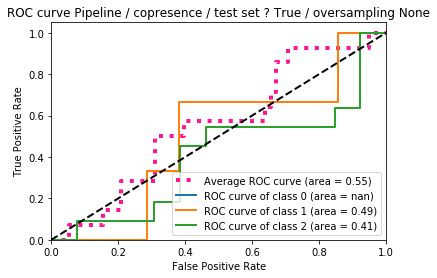

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.249000072479
Test 73 : {'upsampling': 'imb_random', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'), upsamples=imb_random
prepare_train_data: unique 96
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.4588135822510823
    Running 10 iterations on best classifier {'g

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


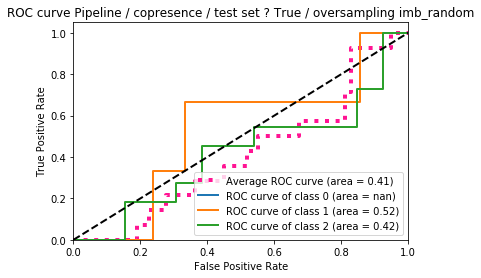

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.259999990463
Test 74 : {'upsampling': 'imb_smote', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.45163765632515634
    Running 10 iterations on best classifier {'gau

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


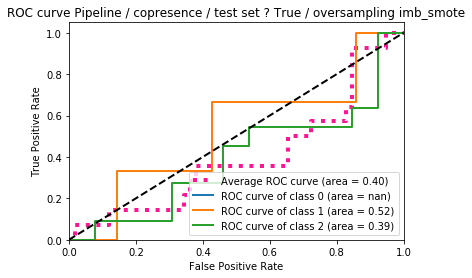

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.250999927521
Test 75 : {'upsampling': 'imb_adasyn', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 96
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 76 : {'upsampling': 'imb_smotenc', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'), upsamples=imb_smotenc
prepare_train_data: unique 96
('   Error ', TypeError('__init__() takes at least 2 arguments (2 given)',))
Test 77 : {'upsampling': 'imb_borderlinesmote1', 'subject':

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


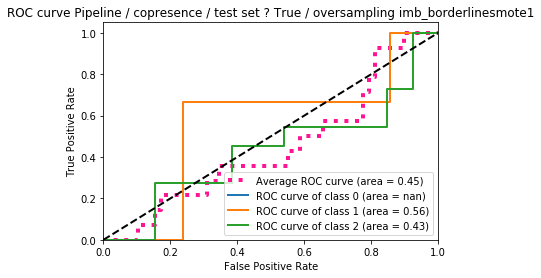

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.251999855042
Test 78 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 96
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.5138317700817702
    Running 10 it

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


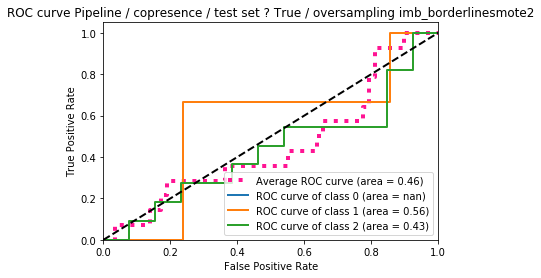

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.258000135422
Test 79 : {'upsampling': 'imb_svmsmote', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 96
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 86 / Counter({2: 32, 3: 32, 1: 22}) / unique 86
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([22, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.44119601328903657
    Running 10 iterations on best classif

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


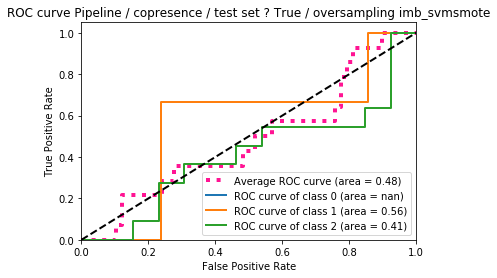

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.243000030518
Test 80 : {'upsampling': None, 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'), upsamples=None
prepare_train_data: unique 96
prepare_train_data: Resampled data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([14, 26, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.31205908289241624
    Running 10 iterations on best classifier {

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


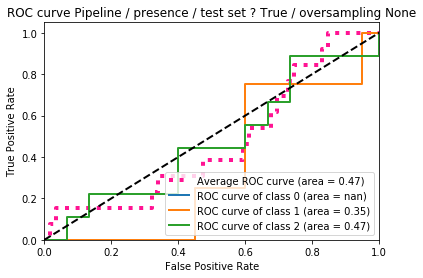

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.259000062943
Test 81 : {'upsampling': 'imb_random', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'), upsamples=imb_random
prepare_train_data: unique 96
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates,

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


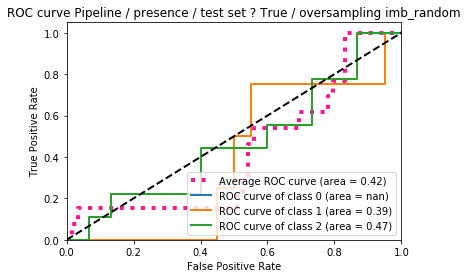

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.21799993515
Test 82 : {'upsampling': 'imb_smote', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, tot

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


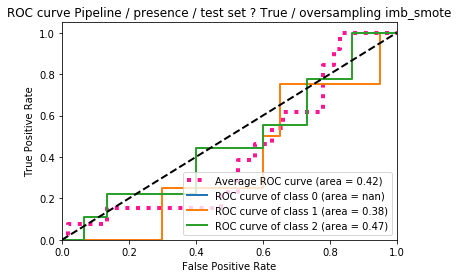

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.219000101089
Test 83 : {'upsampling': 'imb_adasyn', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 96
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 84 : {'upsampling': 'imb_smotenc', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
prepare_train_data: unique 96
('   Error ',

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


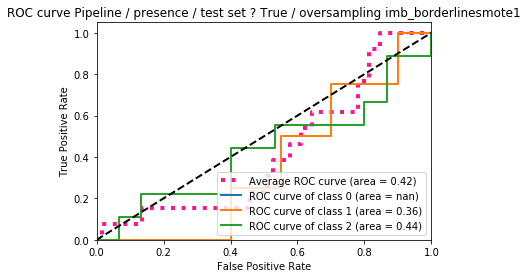

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.259000062943
Test 86 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 96
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 95 / Counter({1: 32, 3: 32, 2: 31}) / unique 95
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 31, 32]))
Fitting 10 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


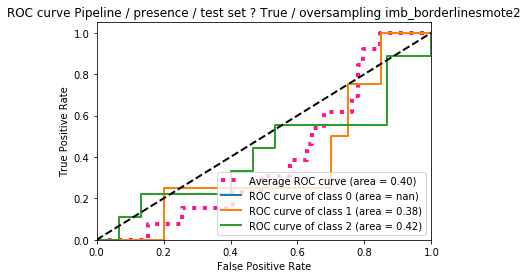

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.214999914169
Test 87 : {'upsampling': 'imb_svmsmote', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 96
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 88 / Counter({2: 32, 3: 32, 1: 24}) / unique 88
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([24, 32, 32]))
Fitting 10 folds for each of 1 candi

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


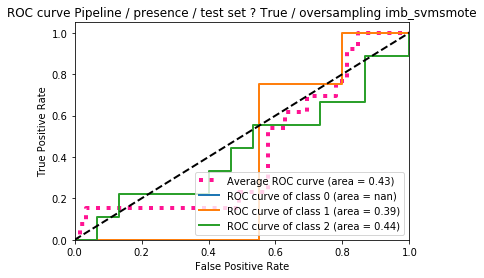

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.211999893188
Test 88 : {'upsampling': None, 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'), upsamples=None
prepare_train_data: unique 96
prepare_train_data: Resampled data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([ 9, 32, 31]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.38554526748971196
    Running 10 iterations on best classifie

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


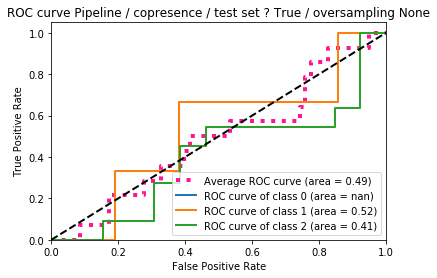

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.234000205994
Test 89 : {'upsampling': 'imb_random', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'), upsamples=imb_random
prepare_train_data: unique 96
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidat

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


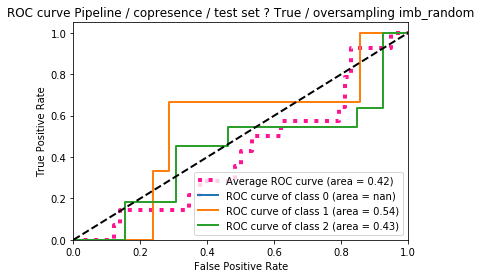

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.229999780655
Test 90 : {'upsampling': 'imb_smote', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates,

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


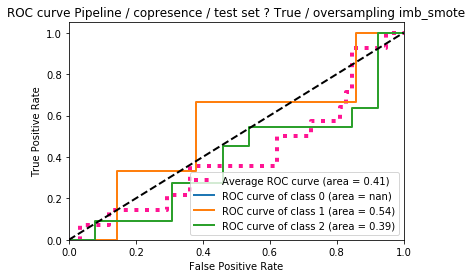

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.214999914169
Test 91 : {'upsampling': 'imb_adasyn', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 96
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 92 : {'upsampling': 'imb_smotenc', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'), upsamples=imb_smotenc
prepare_train_data: unique 96
('   E

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


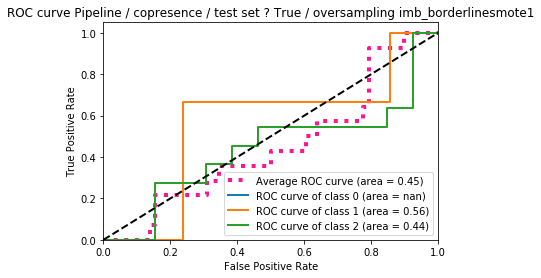

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.219000101089
Test 94 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 96
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


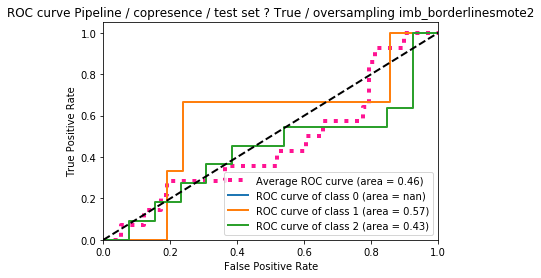

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.217000007629
Test 95 : {'upsampling': 'imb_svmsmote', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'nonverbal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 96
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 86 / Counter({2: 32, 3: 32, 1: 22}) / unique 86
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([22, 32, 32]))
Fitting 10 folds for each of 1 ca

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


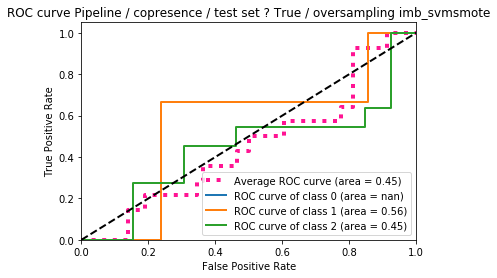

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.21599984169
Test 96 : {'upsampling': None, 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'), upsamples=None
prepare_train_data: unique 96
prepare_train_data: Resampled data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([14, 26, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.302336860670194
    Running 10 iterations on best classifier {'gaussia

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


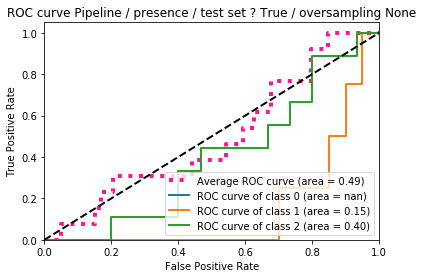

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.234999895096
Test 97 : {'upsampling': 'imb_random', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'), upsamples=imb_random
prepare_train_data: unique 96
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, tota

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


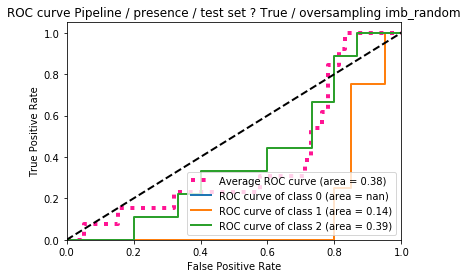

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.243999958038
Test 98 : {'upsampling': 'imb_smote', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, totalli

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


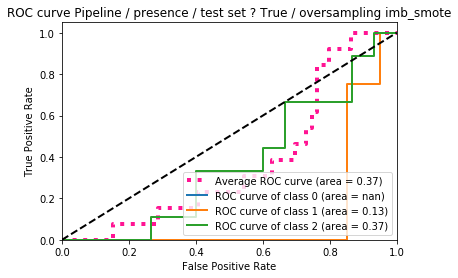

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.269999980927
Test 99 : {'upsampling': 'imb_adasyn', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 96
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 100 : {'upsampling': 'imb_smotenc', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'), upsamples=imb_smotenc
prepare_train_data: unique 96
('   Error ', TypeErro

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


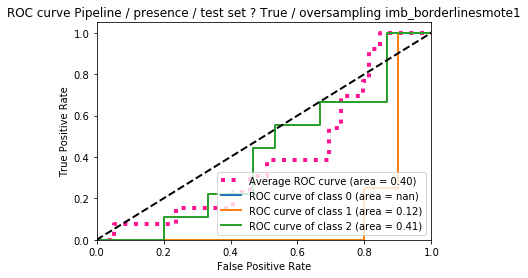

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.256000041962
Test 102 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 96
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 95 / Counter({1: 32, 3: 32, 2: 31}) / unique 95
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 31, 32]))
Fitting 10 fold

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


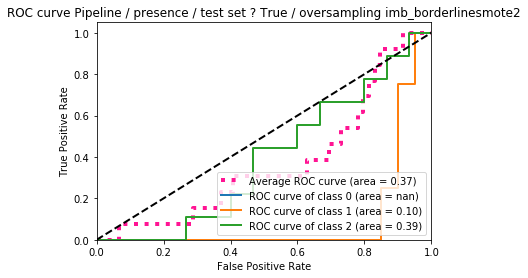

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.214999914169
Test 103 : {'upsampling': 'imb_svmsmote', 'subject': 'doctor', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 96
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidate

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


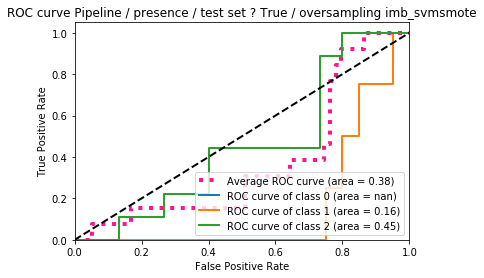

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.212999820709
Test 104 : {'upsampling': None, 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'), upsamples=None
prepare_train_data: unique 96
prepare_train_data: Resampled data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([ 9, 32, 31]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best score 0.3774480920314253
    Running 10 iterations on best classifier {'g

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


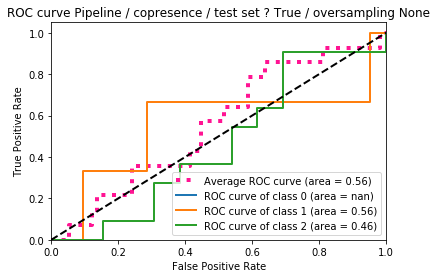

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.226999998093
Test 105 : {'upsampling': 'imb_random', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'), upsamples=imb_random
prepare_train_data: unique 96
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


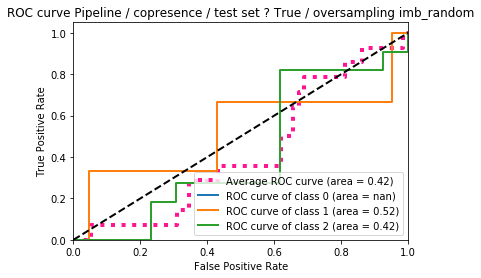

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.206000089645
Test 106 : {'upsampling': 'imb_smote', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 1 candidates, tot

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


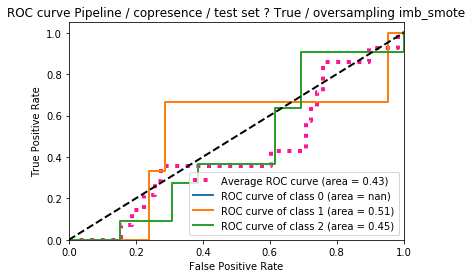

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.236000061035
Test 107 : {'upsampling': 'imb_adasyn', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 96
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 108 : {'upsampling': 'imb_smotenc', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'), upsamples=imb_smotenc
prepare_train_data: unique 96
('   Error ', 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


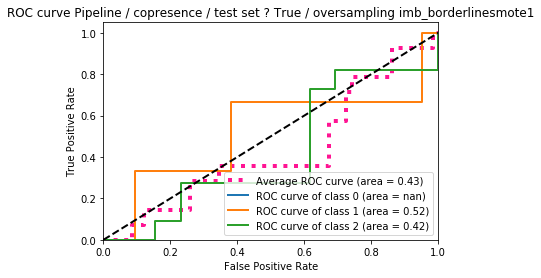

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.25
Test 110 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 96
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for e

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


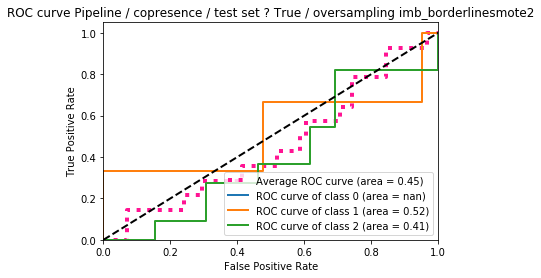

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.241000175476
Test 111 : {'upsampling': 'imb_svmsmote', 'subject': 'doctor', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 96
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 86 / Counter({2: 32, 3: 32, 1: 22}) / unique 86
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([22, 32, 32]))
Fitting 10 folds for each of 1 candid

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


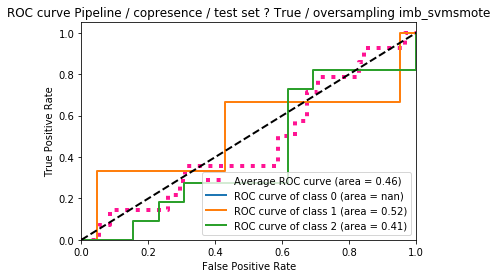

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.261999845505
Test 112 : {'upsampling': None, 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=None
prepare_train_data: unique 96
prepare_train_data: Resampled data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([14, 26, 32]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best sco

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


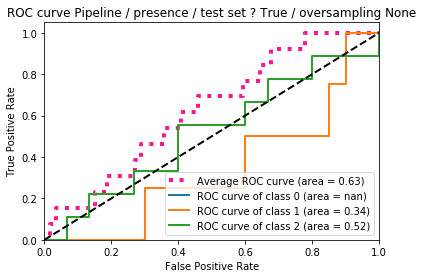

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.255000114441
Test 113 : {'upsampling': 'imb_random', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_random
prepare_train_data: unique 96
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=in

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


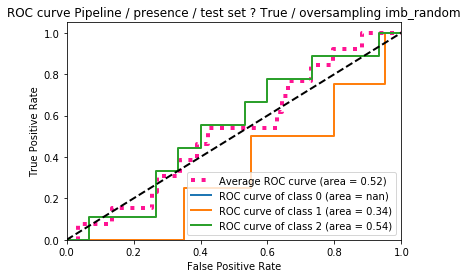

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.299000024796
Test 114 : {'upsampling': 'imb_smote', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


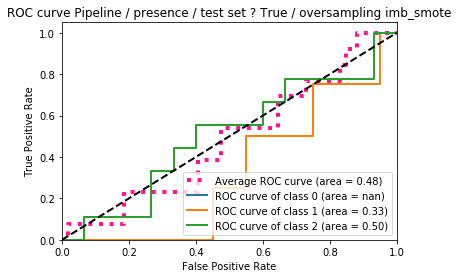

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.204999923706
Test 115 : {'upsampling': 'imb_adasyn', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 96
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 116 : {'upsampling': 'imb_smotenc', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), u

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


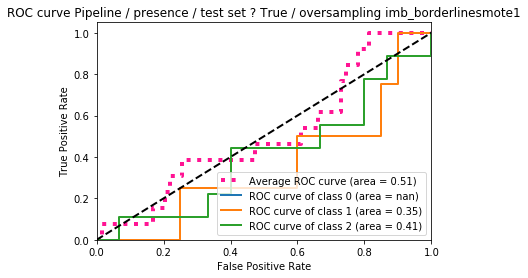

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.240000009537
Test 118 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 96
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 95 / Counter({1: 32, 3: 32, 2: 31}) / unique 95
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='objec

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


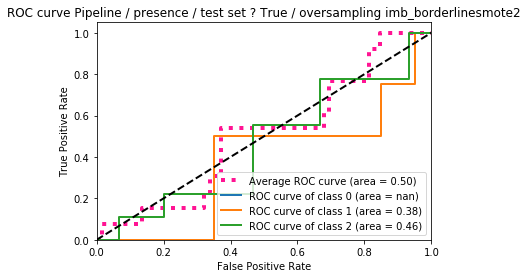

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.246999979019
Test 119 : {'upsampling': 'imb_svmsmote', 'subject': 'agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 96
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dt

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


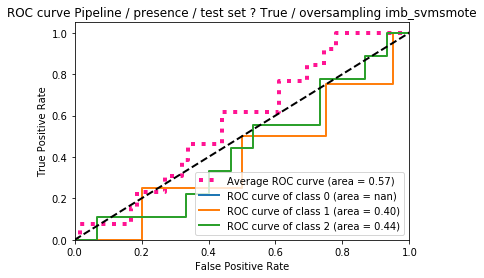

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.230000019073
Test 120 : {'upsampling': None, 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=None
prepare_train_data: unique 96
prepare_train_data: Resampled data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=int64), array([ 9, 32, 31]))
Fitting 10 folds for each of 1 candidates, totalling 10 fits
  Gridsearch evaluated best 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


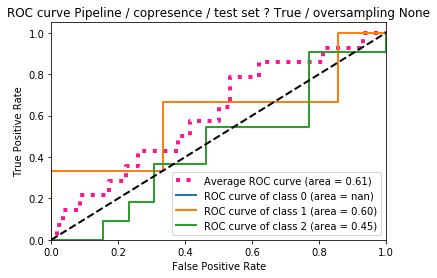

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.236999988556
Test 121 : {'upsampling': 'imb_random', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_random
prepare_train_data: unique 96
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


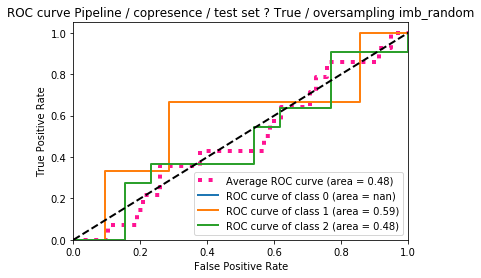

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.210999965668
Test 122 : {'upsampling': 'imb_smote', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3], dtype=in

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


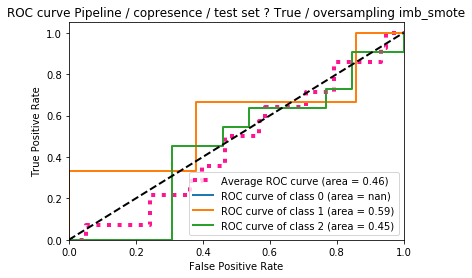

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.226999998093
Test 123 : {'upsampling': 'imb_adasyn', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 96
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 124 : {'upsampling': 'imb_smotenc', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='obje

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


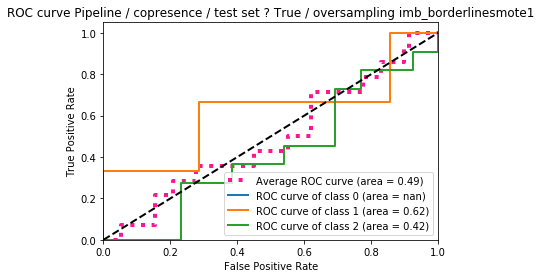

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.221999883652
Test 126 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 96
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='ob

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


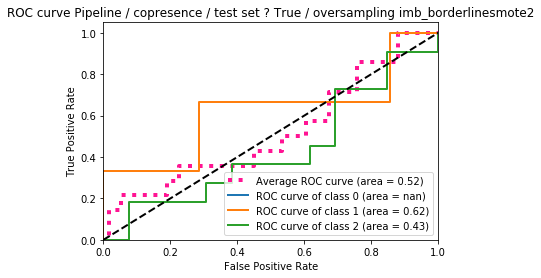

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.226999998093
Test 127 : {'upsampling': 'imb_svmsmote', 'subject': 'agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 96
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 86 / Counter({2: 32, 3: 32, 1: 22}) / unique 86
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_SentenceLength_Mid_agent', u'Ratio1_Mid_agent',
       u'Ratio2_Mid_agent'],
      dtype='object'))
(array([1, 2, 3],

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


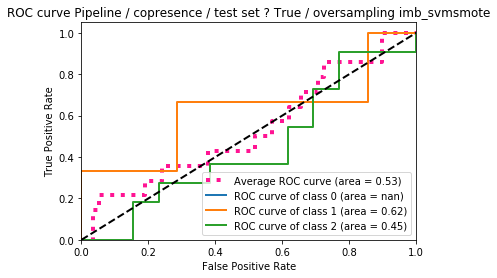

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.219999790192
Test 128 : {'upsampling': None, 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=None
prepare_train_data: unique 96
prepare_train_data: Resampled data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_a

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


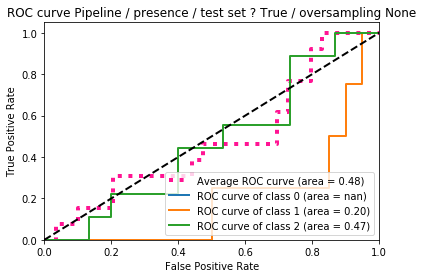

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.278000116348
Test 129 : {'upsampling': 'imb_random', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_random
prepare_train_data: unique 96
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


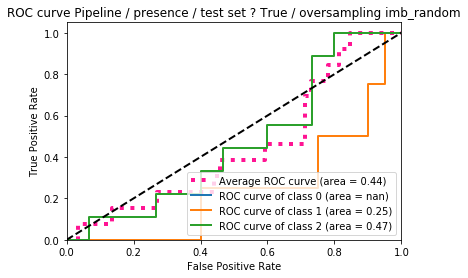

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.216000080109
Test 130 : {'upsampling': 'imb_smote', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ra

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


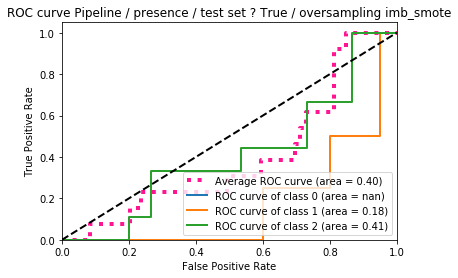

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.226999998093
Test 131 : {'upsampling': 'imb_adasyn', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 96
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 132 : {'upsampling': 'imb_smotenc', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'A

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


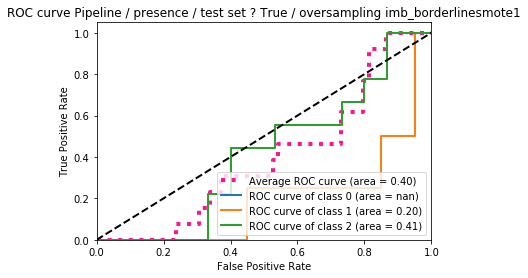

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.227999925613
Test 134 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 96
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 95 / Counter({1: 32, 3: 32, 2: 31}) / unique 95
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Av

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


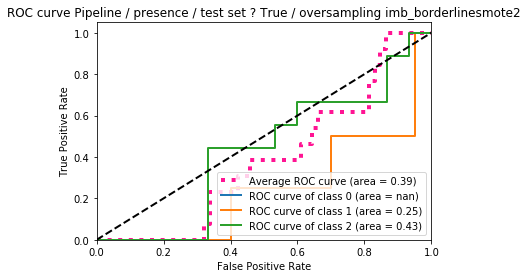

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.232000112534
Test 135 : {'upsampling': 'imb_svmsmote', 'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=presence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 96
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
  

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


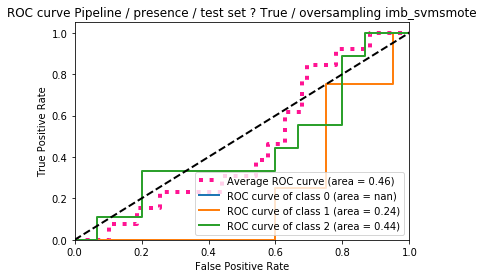

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.210000038147
Test 136 : {'upsampling': None, 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=None
prepare_train_data: unique 96
prepare_train_data: Resampled data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mi

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


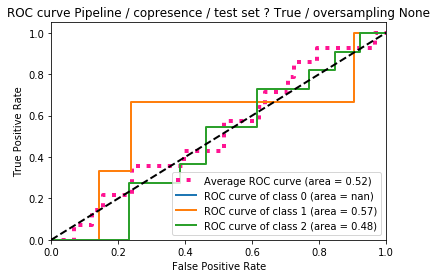

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.237999916077
Test 137 : {'upsampling': 'imb_random', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_random
prepare_train_data: unique 96
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
     

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


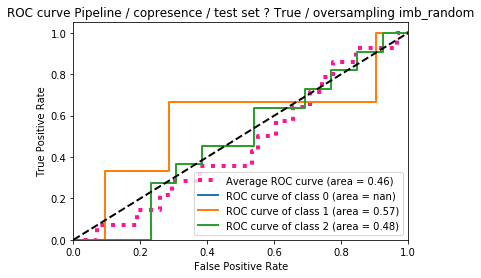

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.210999965668
Test 138 : {'upsampling': 'imb_smote', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 96
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


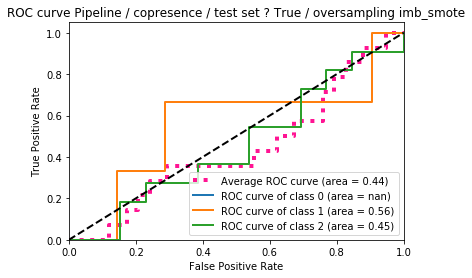

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.227999925613
Test 139 : {'upsampling': 'imb_adasyn', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_adasyn
prepare_train_data: unique 96
prepare_train_data: Applying ADASYN oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
('   Error ', ValueError('No samples will be generated with the provided ratio settings.',))
Test 140 : {'upsampling': 'imb_smotenc', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mi

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


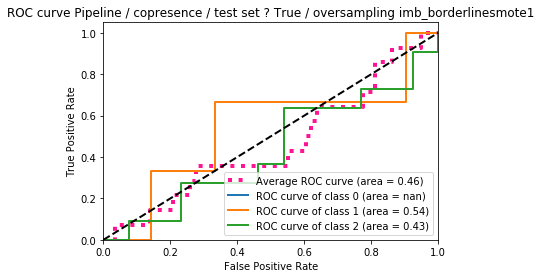

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.226000070572
Test 142 : {'upsampling': 'imb_borderlinesmote2', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_borderlinesmote2
prepare_train_data: unique 96
prepare_train_data: Applying BorderlineSMOTE-2 oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


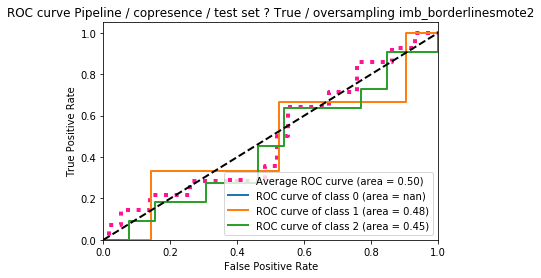

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.223000049591
Test 143 : {'upsampling': 'imb_svmsmote', 'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'gnb', 'modes': 'multimodal'}
prepare_train_data: target_model=copresence, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',
       u'Ratio1_Mid', u'Ratio2_Mid', u'Head_Entropy_Mid_agent',
       u'Avg_HandEntropy_Mid_agent', u'Avg_SentenceLength_Mid_agent',
       u'Ratio1_Mid_agent', u'Ratio2_Mid_agent'],
      dtype='object'), upsamples=imb_svmsmote
prepare_train_data: unique 96
prepare_train_data: Applying SVMSMOTE oversampling to data 72 / Counter({2L: 32, 3L: 31, 1L: 9}) / unique 72
prepare_train_data: Resampled data 86 / Counter({2: 32, 3: 32, 1: 22}) / unique 86
gridsearch(clf=<class 'sklearn.pipeline.Pipeline'>, modelTarget=presence, param_grid={'gaussiannb__var_smoothing': [1e-09], 'gaussiannb__priors': [None]}, features=Index([u'Head_Entropy_Mid', u'Avg_HandEntropy_Mid', u'Avg_SentenceLength_Mid',

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


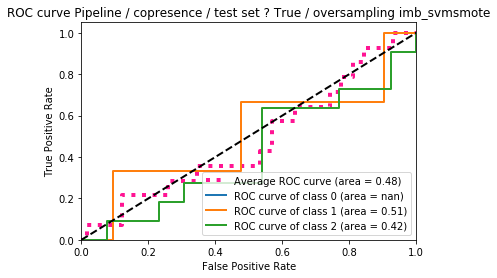

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


   Elapsed %s seconds0.260999917984
Test 144 : {'upsampling': None, 'subject': 'doctor', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=None
prepare_train_data: unique 95
prepare_train_data: Resampled data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
gridsearch(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, modelTarget=presence, param_grid={'n_estimators': [300], 'max_features': [None, 'sqrt', 'log2'], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 5, 10]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([14, 26, 32]))
Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.4min finished


  Gridsearch evaluated best score 0.26679426540537654
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 300, 'max_depth': 2, 'min_samples_leaf': 5} ...
Balanced accuracy score: 0
              precision    recall  f1-score   support

           1       0.50      0.25      0.33         4
           2       0.33      0.11      0.17         9
           3       0.42      0.73      0.53        11

   micro avg       0.42      0.42      0.42        24
   macro avg       0.42      0.36      0.34        24
weighted avg       0.40      0.42      0.36        24



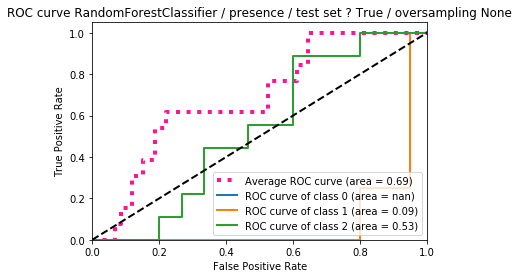

   Elapsed %s seconds203.373000145
Test 145 : {'upsampling': 'imb_random', 'subject': 'doctor', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=imb_random
prepare_train_data: unique 95
prepare_train_data: Applying RANDOM oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 72
gridsearch(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, modelTarget=presence, param_grid={'n_estimators': [300], 'max_features': [None, 'sqrt', 'log2'], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 5, 10]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  3.3min finished


  Gridsearch evaluated best score 0.588558201058201
    Running 10 iterations on best classifier {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1} ...
Balanced accuracy score: 0
              precision    recall  f1-score   support

           1       0.20      0.25      0.22         4
           2       0.33      0.22      0.27         9
           3       0.38      0.45      0.42        11

   micro avg       0.33      0.33      0.33        24
   macro avg       0.31      0.31      0.30        24
weighted avg       0.33      0.33      0.33        24



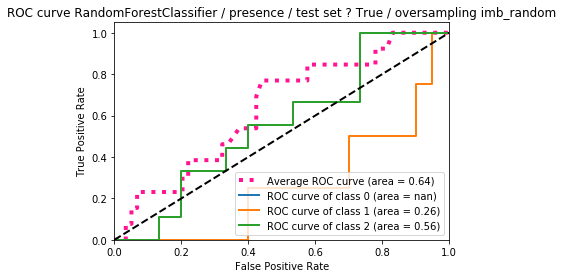

   Elapsed %s seconds197.527999878
Test 146 : {'upsampling': 'imb_smote', 'subject': 'doctor', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
prepare_train_data: target_model=presence, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'), upsamples=imb_smote
prepare_train_data: unique 95
prepare_train_data: Applying SMOTE oversampling to data 72 / Counter({3L: 32, 2L: 26, 1L: 14}) / unique 72
prepare_train_data: Resampled data 96 / Counter({1: 32, 2: 32, 3: 32}) / unique 96
gridsearch(clf=<class 'sklearn.ensemble.forest.RandomForestClassifier'>, modelTarget=presence, param_grid={'n_estimators': [300], 'max_features': [None, 'sqrt', 'log2'], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 5, 10]}, features=Index([u'Avg_SentenceLength_Mid', u'Ratio1_Mid', u'Ratio2_Mid'], dtype='object'))
(array([1, 2, 3], dtype=int64), array([32, 32, 32]))
Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: 

In [108]:
from sklearn.naive_bayes import GaussianNB

forest = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True)
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE))
gnb = make_pipeline(StandardScaler(), GaussianNB())
print (gnb.get_params().keys())

# number of kfolds folds for cross validations
cv = 10
# number of kfold cross validations performed to compute mean scores
repeat = 10
# number of random forest training performed to compute mean features importances
repeat_dc = 300
# whether to apply 'original' upsampling method
#upsample = True
verbose=1

test_set = True

fi = False

for idx, test in enumerate(test_plan):
    print("Test %d : %s" % (idx, test))
    
    try:
    
        # make it global because we use them to compute feature importance for forests
        all_feature_importances = []    
        all_dropcol_feature_importances = []

        subject = test['subject']
        target = test['target']
        modes = test['modes']
        classifier = test['classifier']
        upsample = test['upsampling']
        if classifier == 'forest':
            clf = forest
            pgrid = param_grid_rf
        elif classifier == 'svm':
            clf = svm
            pgrid = param_grid_svm
        elif classifier == 'gnb':
            clf = gnb
            pgrid = param_grid_gnb

        if subject == 'doctor':
            df = subject_np_df
            if modes == 'verbal':
                feats = subject_features_verbal
            elif modes == 'nonverbal':
                feats = subject_features_nonverbal
            elif modes == 'multimodal':
                feats = subject_features_multimodal
            elif modes == 'multimodal+duration':
                feats = subject_features_multimodal_duration
        elif subject == 'agent':
            df = agent_np_df
            if modes == 'verbal':
                feats = agent_features_verbal
            elif modes == 'nonverbal':
                feats = agent_features_nonverbal
            elif modes == 'multimodal':
                feats = agent_features_multimodal
            elif modes == 'multimodal+duration':
                feats = agent_features_multimodal_duration        
        else:
            df = all_np_df
            if modes == 'verbal':
                feats = all_features_verbal
            elif modes == 'nonverbal':
                feats = all_features_nonverbal
            elif modes == 'multimodal':
                feats = all_features_multimodal
            elif modes == 'multimodal+duration':
                feats = all_features_multimodal_duration        

        start = time.time()

        #X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample, test_set=True) 

        grid, scores, dropcol_fis, fis, support = run_gridsearch(clf, 
                                                        pgrid, 
                                                        df, feats, 
                                                        target, 
                                                        repeat=repeat, repeat_dc=repeat_dc, 
                                                        upsample=upsample, 
                                                        test_set=test_set,
                                                        fi=fi,
                                                        verbose=verbose)

        elapsed = time.time() - start
        print("   Elapsed %s seconds" +str(elapsed))

        isDoc = 'doctor' in subject
        isAgent = 'agent' in subject
        #save_grid(grid, presence=target=='presence', doctor=isDoc, agent=isAgent,
        #         phases=phases, classifier='RF' if test['classifier']=='forest' else 'SVM')

        presidx = 'Presence' if target == 'presence' else 'Co-Presence'
        if subject == 'doctor':
            subjidx = 'Doctor'
        elif subject == 'agent':
            subjidx = 'Agent'
        else:
            subjidx = 'Doctor+Agent'
        #phidx = 'No Phase' if phases in [None, (0,1,0)] else '%2d%2d%2d' % ( phases[0]*100, phases[1]*100, phases[2]*100 )
        if modes == 'verbal':
            phidx = 'Verbal'
        elif modes == 'nonverbal':
            phidx = 'Non-Verbal'
        elif modes == 'multimodal':
            phidx = 'Multimodal'
        elif modes == 'multimodal+duration':
            phidx = 'Multimodal+Duration'
        clfidx = 'Random Forests' if classifier == 'forest' else 'SVM'

        osidx = 'None' if upsample is None else upsample

        #TODO: compute scores and fill matrix when using test set
        if not test_set:
            # compute err
            all_scores_ = scores.drop(['fit_time', 'score_time'], axis=1).T
            final = pd.DataFrame(index=all_scores_.index)
            final['means'] = all_scores_.mean(axis=1)
            final['std'] = all_scores_.std(axis=1)

            test_set_name = dh.get_grid_name(target, isDoc, isAgent, modes, classifier)
            print("      updating scores for %s" % test_set_name)
            #print("final" , final)
            scores_df = update_results(scores_df, pd.DataFrame(final.T.loc['means']).T, presidx, subjidx, phidx, clfidx, 'score')
            scores_df = update_results(scores_df, pd.DataFrame(final.T.loc['std']).T, presidx, subjidx, phidx, clfidx, 'err')    
            dh.save_obj(scores_df, 'results', 'scores')

            dumpPath = os.path.join(dh.root_path, 'results', 'scores.xlsx')
            scores_df.to_excel(dumpPath, index=True)


            ctx = [[upsample, cv, repeat, repeat_dc, grid.best_params_, elapsed, support, feats], [0,0,0,0,0,0,0,0]]
            ctx_df = pd.DataFrame(ctx, columns=['UpSample', 'KFolds K', 'KFolds repetitions', 'Repetitions for features importance',
                             'Best Params', 'Time (s)', 'Support', 'Features'])

            for col in ctx_df.columns:
                if col in ['Best Params', 'Support', 'Features']:
                    context_df.loc[(presidx, subjidx, phidx, clfidx, 'score'), col] = str(ctx_df[col][0])
                else:
                    #print("col %s" % col)
                    context_df.loc[(presidx, subjidx, phidx, clfidx, 'score'), col] = ctx_df[col][0]
            dumpPath = os.path.join(dh.root_path, '.',  'context.csv')
            context_df.to_csv(dumpPath, index=True)



            # features importances
            if dropcol_fis is not None:
                final_fi = dropcol_fis.T
                final_fi['means'] = final_fi.mean(axis=1)
                final_fi['std'] = final_fi.std(axis=1)
                final_fi['sem'] = final_fi.sem(axis=1)
                final_fi['confidence'] = final_fi.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)
                plot_importance('Columns Drop - ' + test_set_name, 
                                final_fi['means'],
                                final_fi['confidence'],
                                feats, 
                                sort=False)
                dumpPath = os.path.join(dh.root_path, 'results', 'features_importances_dropcol_%s.xlsx' % test_set_name)
                final_fi.to_excel(dumpPath, index=True)


            if fis is not None:
                final_fi_ = fis.T
                final_fi_['means'] = final_fi_.mean(axis=1)
                final_fi_['std'] = final_fi_.std(axis=1)
                final_fi_['sem'] = final_fi_.sem(axis=1)
                final_fi_['confidence'] = final_fi_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)
                plot_importance('Gini - ' + test_set_name, 
                                final_fi_['means'],
                                final_fi_['confidence'],
                                feats, 
                                sort=False)
                dumpPath = os.path.join(dh.root_path, 'results', 'features_importances_%s.xlsx' % test_set_name)
                final_fi.to_excel(dumpPath, index=True)
                
    except Exception as e:
        print('   Error ', e)


# Visualizations

## Results

### Modes (verbal, non-verbal ...)

First we reload the results.

In [30]:
# Some utilities for plots

from itertools import groupby


def add_line(ax, xpos, ypos):
    line = plt.Line2D([xpos, xpos], [ypos + .1, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df, nlevels=-1):
    ypos = -.1
    scale = 1./df.index.size
    if nlevels == -1:
        nlevels = df.index.nlevels
    for level in range(nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            lxpos = (pos + .5 * rpos)*scale
            ax.text(lxpos, ypos, label, ha='center', transform=ax.transAxes)
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

In [176]:
# Reload results
dh = DataHandler('2-verbal-nonverbal-multimodal-duration', 2)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['Verbal', 'Non-Verbal', 'Multimodal', 'Multimodal+Duration'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Metric', 'Subject', 'Mode', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No results to load !")

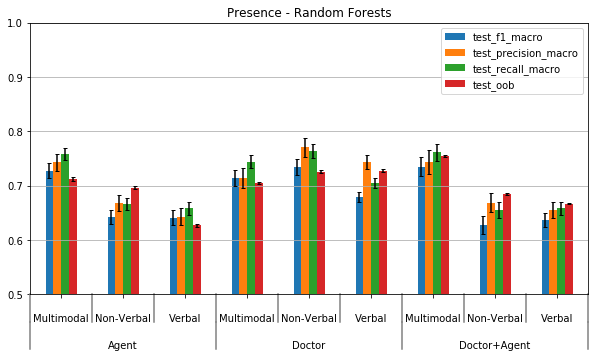

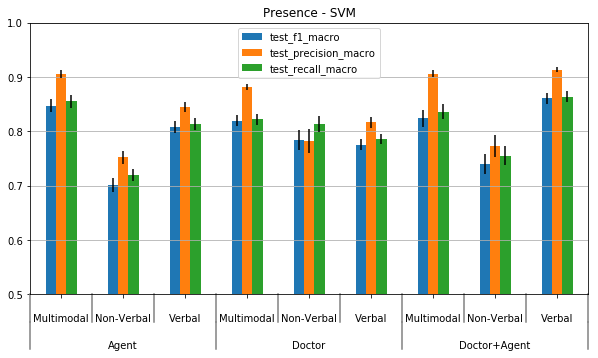

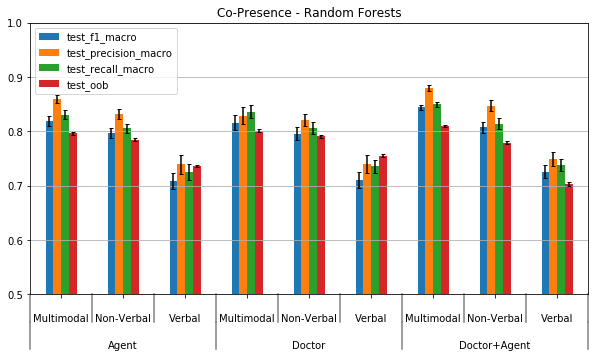

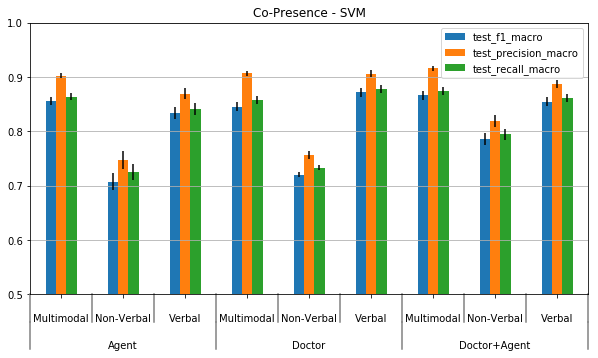

In [177]:
# RF - presence
        
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()
mydf = rear.loc['score', 'Random Forests', 'Presence', :, ['Verbal', 'Non-Verbal', 'Multimodal']]

mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1,
#                   axis='index')
ax = mydf.plot(kind='bar',yerr=rear.loc['err', 'Random Forests', 'Presence'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Presence - Random Forests',
              capsize=2)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_presence_rf.png'), bbox_inches = "tight")
plt.show()

# SVM - presence

mydf = rear.loc['score', 'SVM', 'Presence', :, ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Presence'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_presence_svm.png'), bbox_inches = "tight")
plt.show()


# RF - CO-Presence

mydf = rear.loc['score', 'Random Forests', 'Co-Presence', :, ['Verbal', 'Non-Verbal', 'Multimodal']]

mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1,
#                   axis='index')
ax = mydf.plot(kind='bar',yerr=rear.loc['err', 'Random Forests', 'Co-Presence'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - Random Forests',
              capsize=2)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_rf.png'), bbox_inches = "tight")
plt.show()

# SVM - CO-presence

mydf = rear.loc['score', 'SVM', 'Co-Presence', :, ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_svm.png'), bbox_inches = "tight")
plt.show()


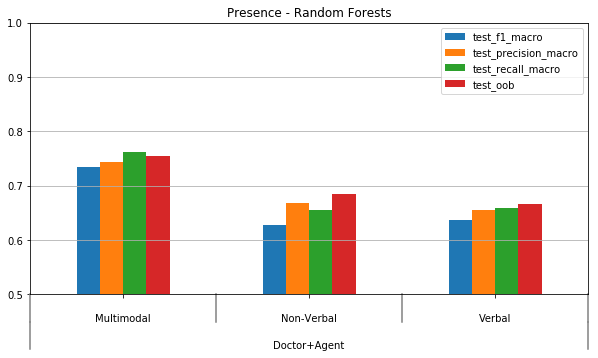

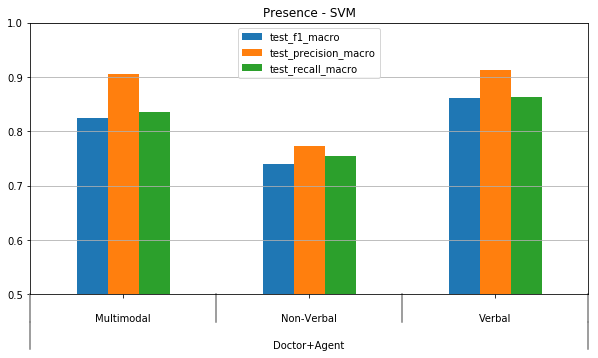

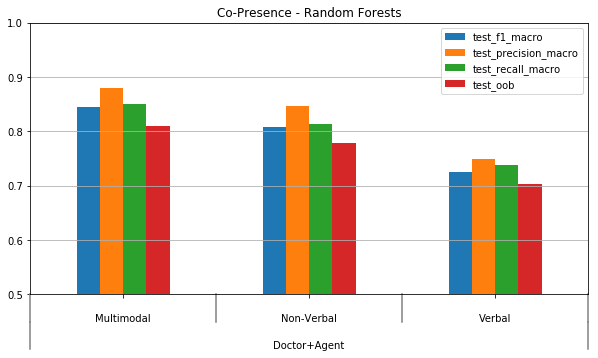

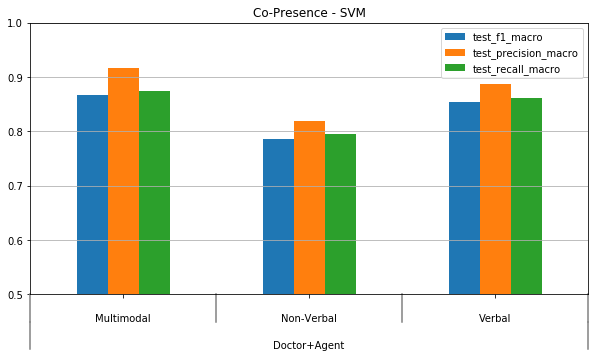

In [178]:
# RF - presence
        
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()
mydf = rear.loc['score', 'Random Forests', 'Presence', 'Doctor+Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]

mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1,
#                   axis='index')
ax = mydf.plot(kind='bar',yerr=rear.loc['err', 'Random Forests', 'Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Presence - Random Forests',
              capsize=2)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_presence_rf_docagent.png'), bbox_inches = "tight")
plt.show()

# SVM - presence

mydf = rear.loc['score', 'SVM', 'Presence', 'Doctor+Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_presence_svm_docagent.png'), bbox_inches = "tight")
plt.show()


# RF - CO-Presence

mydf = rear.loc['score', 'Random Forests', 'Co-Presence', 'Doctor+Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]

mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1,
#                   axis='index')
ax = mydf.plot(kind='bar',yerr=rear.loc['err', 'Random Forests', 'Co-Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - Random Forests',
              capsize=2)
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_rf_docagent.png'), bbox_inches = "tight")
plt.show()

# SVM - CO-presence

mydf = rear.loc['score', 'SVM', 'Co-Presence', 'Doctor+Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_svm_docagent.png'), bbox_inches = "tight")
plt.show()

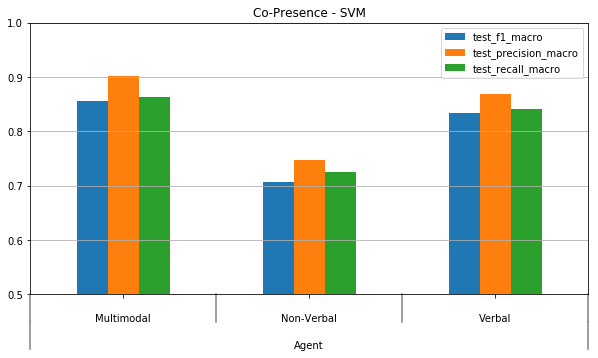

In [179]:
# RF - presence
        
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()
mydf = rear.loc['score', 'Random Forests', 'Presence', 'Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]


# SVM - CO-presence - Agent

mydf = rear.loc['score', 'SVM', 'Co-Presence', 'Agent', ['Verbal', 'Non-Verbal', 'Multimodal']]
mydf.index = mydf.index.remove_unused_levels()
mydf.index = mydf.index.droplevel([0,1,2])
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
#mydf = mydf.rename({'Verbal': 'V', 'Non-Verbal': 'NV', 'Multimodal': 'M', 'Multimodal+Duration': 'M+D'}, 
#                   level=1, 
#                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence', 'Doctor+Agent'] / 10,
               stacked=False, 
               figsize=(10,5),
               title='Co-Presence - SVM')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_modalities_copresence_svm_agent.png'), bbox_inches = "tight")
plt.show()

## Phases vs no phase

In [37]:
# Graphs for SVM phases vs no phase, Presence and Co-Presence

dh = DataHandler('1-subject-agent_phases-nophase_imb-random', 1)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['No Phase', '157015'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_columns = ['precision', 'f1', 'recall', 'params']
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Metric', 'Subject', 'Phases', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No data to load, nothing to draw")
    
scores_df

test_f1_macro  \
Target      Subject      Phases   Classifier     Metric                  
Presence    Doctor       No Phase Random Forests score        0.527435   
                                                 err          0.139692   
                                  SVM            score        0.680211   
                                                 err          0.119242   
                         157015   Random Forests score        0.724507   
                                                 err          0.123291   
                                  SVM            score        0.714163   
                                                 err          0.127807   
            Agent        No Phase Random Forests score        0.558518   
                                                 err          0.099202   
                                  SVM            score        0.643868   
                                                 err          0.136048   
                         157015   Random Forests score        0.633419   
                                                 err          0.122877   
                                  SVM            score        0.746854   
                                                 err          0.087283   
            Doctor+Agent No Phase Random Forests score        0.611910   
                                                 err          0.117109   
                                  SVM            score        0.615946   
                                                 err          0.163411   
                         157015   Random Forests score        0.678592   
                                                 err          0.138833   
                                  SVM            score        0.738095   
                                                 err          0.136869   
Co-Presence Doctor       No Phase Random Forests score        0.620942   
                                                 err          0.116538   
                                  SVM            score        0.650386   
                                                 err          0.086620   
                         157015   Random Forests score        0.601401   
                                                 err          0.108398   
                                  SVM            score        0.742443   
                                                 err          0.100669   
            Agent        No Phase Random Forests score        0.647302   
                                                 err          0.117230   
                                  SVM            score        0.602470   
                                                 err          0.161172   
                         157015   Random Forests score        0.621981   
                                                 err          0.100024   
                                  SVM            score        0.629972   
                                                 err          0.107658   
            Doctor+Agent No Phase Random Forests score        0.708713   
                                                 err          0.113875   
                                  SVM            score        0.689882   
                                                 err          0.135071   
                         157015   Random Forests score        0.619559   
                                                 err          0.131289   
                                  SVM            score        0.678379   
                                                 err          0.090006   

                                                         test_f1_macro_class_1  \
Target      Subject      Phases   Classifier     Metric                          
Presence    Doctor       No Phase Random Forests score                0.732222   
                                                 err                  0.190591   
                            

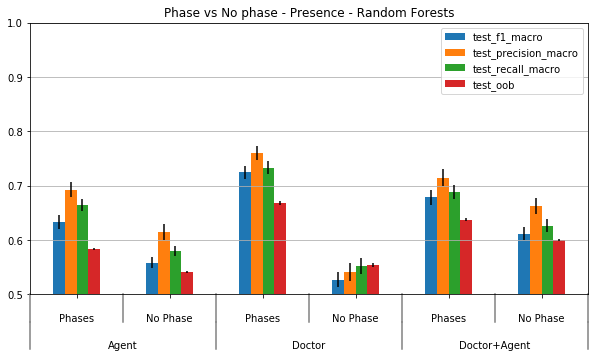

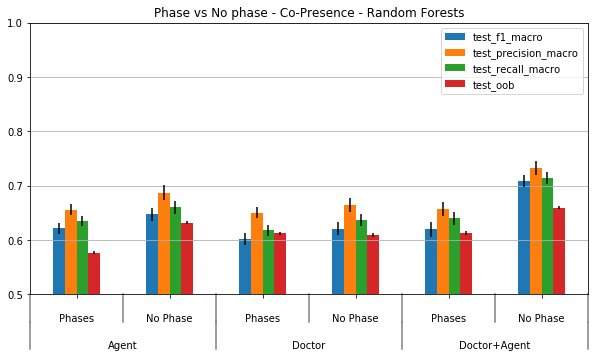

In [38]:
        
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()


# SVM - presence

mydf = rear.loc['score', 'Random Forests', 'Presence']
mydf.index = mydf.index.remove_unused_levels()
#mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
mydf = mydf.rename({'157015': 'Phases'}, 
                   level=1, 
                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'Random Forests', 'Presence'].rename({'157015': 'Phases'}, 
                   level=1, 
                   axis='index') / 10,
               stacked=False, 
               figsize=(10,5),
               title='Phase vs No phase - Presence - Random Forests')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_phases_presence_rf.png'), bbox_inches = "tight")
plt.show()


# SVM - CO-presence

mydf = rear.loc['score', 'Random Forests', 'Co-Presence']
mydf.index = mydf.index.remove_unused_levels()
#mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
mydf = mydf.rename({'157015': 'Phases'}, 
                   level=1, 
                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'Random Forests', 'Co-Presence'].rename({'157015': 'Phases'}, 
                   level=1, 
                   axis='index') / 10,
               stacked=False, 
               figsize=(10,5),
               title='Phase vs No phase - Co-Presence - Random Forests')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 2)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_phases_copresence_rf.png'), bbox_inches = "tight")
plt.show()

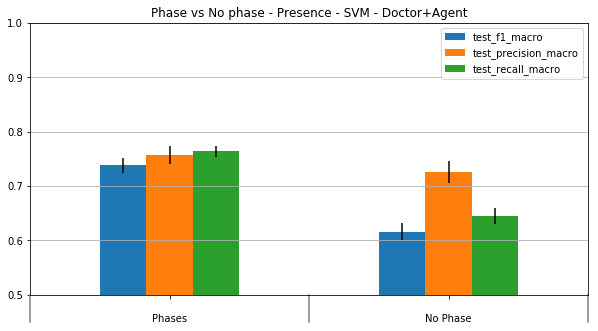

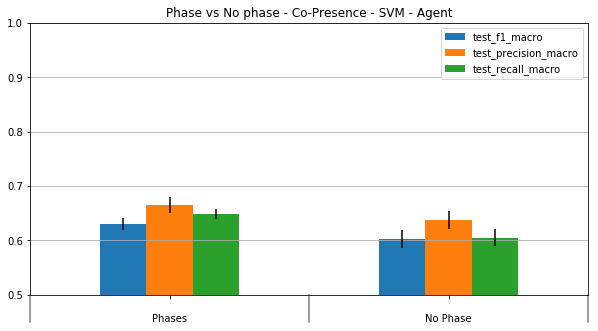

In [39]:
rear = scores_df[['test_f1_macro', 'test_precision_macro', 'test_recall_macro', 'test_oob']].reorder_levels([4,3,0,1,2], axis=0).sort_index()


# SVM - presence - doctor + agent

mydf = rear.loc['score', 'SVM', 'Presence', 'Doctor+Agent']
#mydf.index = mydf.index.remove_unused_levels()
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
mydf = mydf.rename({'157015': 'Phases'}, 
                   level=0, 
                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Presence', 'Doctor+Agent'].rename({'157015': 'Phases'}, 
                   level=0, 
                   axis='index') / 10,
               stacked=False, 
               figsize=(10,5),
               title='Phase vs No phase - Presence - SVM - Doctor+Agent')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 1)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_phases_presence_svm_docagent.png'), bbox_inches = "tight")
plt.show()


# SVM - CO-presence

mydf = rear.loc['score', 'SVM', 'Co-Presence', 'Agent']
#mydf.index = mydf.index.remove_unused_levels()
mydf = mydf.drop(['test_oob'], axis=1)
mydf.sort_index()
mydf = mydf.rename({'157015': 'Phases'}, 
                   level=0, 
                   axis='index')
ax = mydf.plot(kind='bar',
               yerr=rear.loc['err', 'SVM', 'Co-Presence', 'Agent'].rename({'157015': 'Phases'}, 
                   level=0, 
                   axis='index') / 10,
               stacked=False, 
               figsize=(10,5),
               title='Phase vs No phase - Co-Presence - SVM - Agent')
#Below 2 lines remove default labels
ax.set_xticklabels('')
ax.set_xlabel('')
ax.set_ylim([0.5, 1])
ax.grid(axis='y')
label_group_bar_table(ax, mydf, 1)
plt.savefig(os.path.join(dh.root_path, 'scores_bar_phases_copresence_svm_agent.png'), bbox_inches = "tight")
plt.show()

## Exploring learnt classifiers
### Verbal / non-verbal


In [161]:

# reload best params found

dh = DataHandler('2-verbal-nonverbal-multimodal-duration', 2)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['Verbal', 'Non-Verbal', 'Multimodal', 'Multimodal+Duration'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Metric', 'Subject', 'Mode', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No results to load !")
 
context_df = pd.read_csv(os.path.join(dh.root_path, 'context.csv'))
if context_df is None:
    print("missing contextual info context.pkl")
    
context_df.index = scores_df_multiindex
context_df


Metric  \
Metric      Subject      Mode                Classifier     Metric                
Presence    Doctor       Verbal              Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Non-Verbal          Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Multimodal          Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Multimodal+Duration Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
            Agent        Verbal              Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Non-Verbal          Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Multimodal          Random Forests score      Presence   
                                                            err        Presence   
                                             SVM            score      Presence   
                                                            err        Presence   
                         Multimodal+Duration Random Forests score      Presence   
                                                            err        Presence   
...                                                                         ...   
Co-Presence Agent        Verbal              SVM            score   Co-Presence   
                                                            err     Co-Presence   
                         Non-Verbal          Random Forests score   Co-Presence   
                                                            err     Co-Presence   
                                             SVM            score   Co-Presence   
                                                            err     Co-Presence   
                         Multimodal          Random Forests score   Co-Presence   
                                                            err     Co-Presence   
                                             SVM            score   Co-Presence   
                                                            err     Co-Presence   
                         Multimodal+Duration Random Forests score   Co-Presence   
                                                            err     Co-Presence   
                                             SVM            score   Co-Presence   
                                                            err     Co-Presence   
            Doctor+Agent Verbal              Random Forests score   Co-Presence   
                                                            err     Co-Presence   
      

In [309]:
print(str([scorer for scorer in sklearn.metrics.SCORERS.keys() if scorer.endswith('loss')]))

['neg_log_loss', 'brier_score_loss']


Test 0 : {'subject': 'doctor+agent', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
  Computing learning curve for best params : {'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1}
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
Test 1 : {'subject': 'doctor+agent', 'target': 'copresence', 'classifier': 'forest', 'modes': 'verbal'}
  Computing learning curve for best params : {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1}
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
Test 2 : {'subject': 'doctor', 'target': 'presence', 'classifier': 'forest', 'modes': 'verbal'}
  Computing learning curve for best params : {'max_features': 's

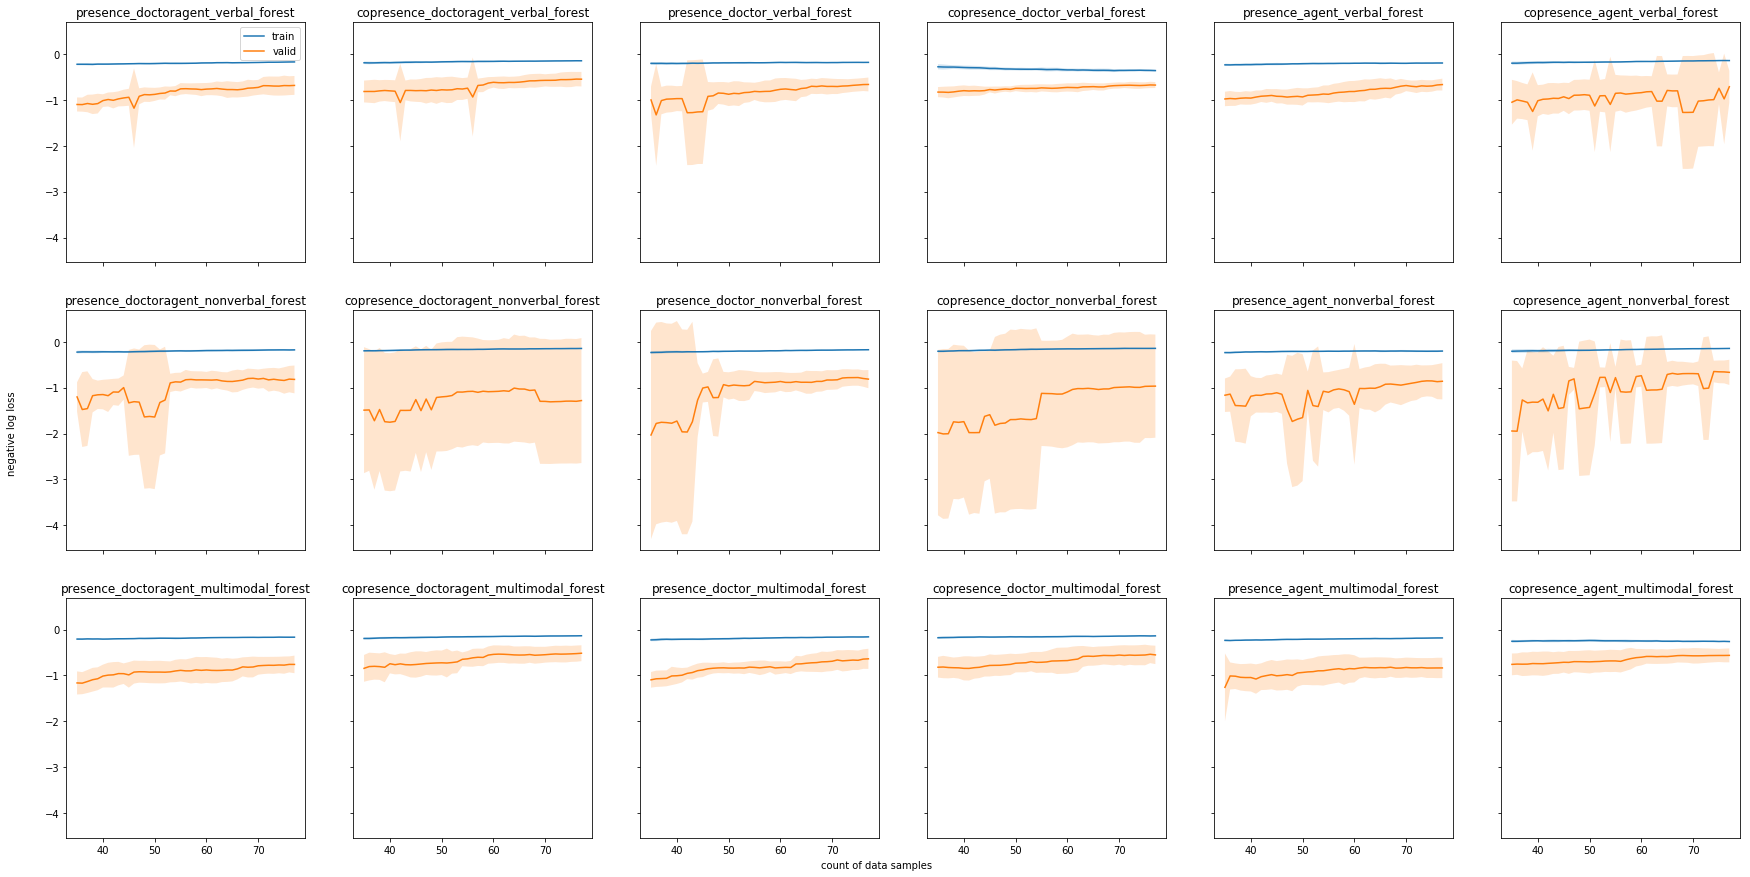

In [162]:
from sklearn.model_selection import learning_curve

test_plan_params = {
    'classifier': ['forest'],
    'subject': ['doctor+agent', 'doctor', 'agent'],
    'target': ['presence', 'copresence'],
    'modes': ['verbal', 'nonverbal', 'multimodal']
}
test_plan = list(ParameterGrid(test_plan_params))

forest = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True)
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE, probability=True))

# whether to apply 'original' upsampling method
upsample = True

cols= 6
fig, ax = plt.subplots(int(len(test_plan)/cols), cols, sharex=True, sharey=True, figsize=(30,15))

results = {}

for idx, test in enumerate(test_plan):
    print("Test %d : %s" % (idx, test))
    

    subject = test['subject']
    target = test['target']
    modes = test['modes']
    classifier = test['classifier']
    clf = forest if classifier == 'forest' else svm

    if subject == 'doctor':
        df = subject_np_df
        if modes == 'verbal':
            feats = subject_features_verbal
        elif modes == 'nonverbal':
            feats = subject_features_nonverbal
        elif modes == 'multimodal':
            feats = subject_features_multimodal
        elif modes == 'multimodal+duration':
            feats = subject_features_multimodal_duration
    elif subject == 'agent':
        df = agent_np_df
        if modes == 'verbal':
            feats = agent_features_verbal
        elif modes == 'nonverbal':
            feats = agent_features_nonverbal
        elif modes == 'multimodal':
            feats = agent_features_multimodal
        elif modes == 'multimodal+duration':
            feats = agent_features_multimodal_duration        
    else:
        df = all_np_df
        if modes == 'verbal':
            feats = all_features_verbal
        elif modes == 'nonverbal':
            feats = all_features_nonverbal
        elif modes == 'multimodal':
            feats = all_features_multimodal
        elif modes == 'multimodal+duration':
            feats = all_features_multimodal_duration        
    
    X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample) 
    
    isDoc = 'doctor' in subject
    isAgent = 'agent' in subject
    presidx = 'Presence' if target == 'presence' else 'Co-Presence'
    if subject == 'doctor':
        subjidx = 'Doctor'
    elif subject == 'agent':
        subjidx = 'Agent'
    else:
        subjidx = 'Doctor+Agent'
    if modes == 'verbal':
        phidx = 'Verbal'
    elif modes == 'nonverbal':
        phidx = 'Non-Verbal'
    elif modes == 'multimodal':
        phidx = 'Multimodal'
    elif modes == 'multimodal+duration':
        phidx = 'Multimodal+Duration'
    clfidx = 'Random Forests' if classifier == 'forest' else 'SVM'

    test_set_name = dh.get_grid_name(target=='presence', isDoc, isAgent, modes, classifier)
    
    # create classifier from best params found previously
    best_params = context_df.loc[presidx, subjidx, phidx, clfidx, 'score']['Best Params']
    clf.set_params(**eval(best_params))
    print("  Computing learning curve for best params : %s" % str(best_params))

    train_sizes = np.arange(35, len(df))
    print(train_sizes)
    print(np.unique(y, return_counts=True))
    train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                            X, y, 
                                                            train_sizes=train_sizes, 
                                                            cv=10, 
                                                            scoring='neg_log_loss',
                                                            shuffle=True)

    results[test_set_name] = {}
    results[test_set_name]['train'] = train_scores
    results[test_set_name]['test'] = test_scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    cur_ax = ax[int(idx / cols), (idx) % cols]
    cur_ax.plot(train_sizes, train_scores_mean, label='train')
    cur_ax.fill_between(train_sizes, train_scores_mean + train_scores_std,
                    train_scores_mean - train_scores_std, alpha=0.2)

    cur_ax.plot(train_sizes, test_scores_mean, label='valid')
    cur_ax.fill_between(train_sizes, test_scores_mean + test_scores_std,
                    test_scores_mean - test_scores_std, alpha=0.2)
    cur_ax.set_title(test_set_name)
    #cur_ax.xlabel("Count of samples")
    #cur_ax.ylabel("Negative log loss")
    if idx == 0: cur_ax.legend()
fig.text(0.5, 0.1, 'count of data samples', ha='center', va='center')
fig.text(0.1, 0.5, 'negative log loss', ha='center', va='center', rotation='vertical')
dh.save_fig('learning_curves_verbal-nonverbal_forest.png') 
plt.show()

In [163]:
dh.save_obj(results, 'learning_curves', 'forest')

True

For non-verbal case we only have 2 features, we have then a chance to vizualize the classification results for some classifiers.

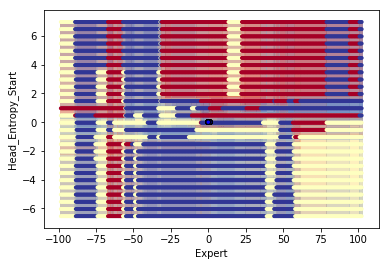

In [11]:
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA


df = subject_np_df
feats = all_features
target = 'presence'

n_classes = 3
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses

#best_params = context_df.loc['Presence', 'Doctor', 'Non-Verbal', 'Random Forests', 'score']['Best Params']
#forest.set_params(**eval(best_params))
forest = RandomForestClassifier(n_estimators=10)
X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=True)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
forest.fit(X_reduced,y)

model = forest
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

# alpha blend the
# decision surfaces of the ensemble of classifiers

# Choose alpha blend level with respect to the number
# of estimators
# that are in use (noting that AdaBoost can use fewer estimators
# than its maximum if it achieves a good enough fit early on)
estimator_alpha = 1.0 / len(model.estimators_)
for tree in model.estimators_:
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha=estimator_alpha, cmap=cmap)

# Build a coarser grid to plot a set of ensemble classifications
# to show how these are different to what we see in the decision
# surfaces. These points are regularly space and do not have a
# black outline
xx_coarser, yy_coarser = np.meshgrid(
    np.arange(x_min, x_max, plot_step_coarser),
    np.arange(y_min, y_max, plot_step_coarser))
Z_points_coarser = model.predict(np.c_[xx_coarser.ravel(),
                                 yy_coarser.ravel()]
                                 ).reshape(xx_coarser.shape)
cs_points = plt.scatter(xx_coarser, yy_coarser, s=15,
                        c=Z_points_coarser, cmap=cmap,
                        edgecolors="none")

# Plot the training points, these are clustered together and have a
# black outline
plt.scatter(X[:, 0], X[:, 1], c=y,
            cmap=ListedColormap(['r', 'y', 'b']),
            edgecolor='k', s=20)
plt.xlabel(feats[0])
plt.ylabel(feats[1])
plt.show()

prepare_train_data: target_model=presence, features=Index([u'Expert', u'Head_Entropy_Start', u'Head_Entropy_Mid',
       u'Head_Entropy_End', u'Avg_HandEntropy_Begin', u'Avg_HandEntropy_Mid',
       u'Avg_HandEntropy_End', u'Avg_SentenceLength_Begin',
       u'Avg_SentenceLength_Mid', u'Avg_SentenceLength_End', u'Ratio1_Begin',
       u'Ratio1_Mid', u'Ratio1_End', u'Ratio2_Begin', u'Ratio2_Mid',
       u'Ratio2_End', u'Duration', u'Head_Entropy_Start_agent',
       u'Head_Entropy_Mid_agent', u'Head_Entropy_End_agent',
       u'Avg_HandEntropy_Begin_agent', u'Avg_HandEntropy_Mid_agent',
       u'Avg_HandEntropy_End_agent', u'Avg_SentenceLength_Begin_agent',
       u'Avg_SentenceLength_Mid_agent', u'Avg_SentenceLength_End_agent',
       u'Ratio1_Begin_agent', u'Ratio1_Mid_agent', u'Ratio1_End_agent',
       u'Ratio2_Begin_agent', u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object'), upsamples=imb_smote
prepare_train_data: unique 78
prepare_train_data: Original data 78 / Count

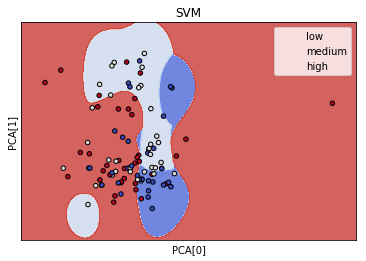

In [107]:
from sklearn.decomposition import PCA

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, **params)
    

df = subject_np_df
feats = all_features
target = 'presence'

n_classes = 3
cmap = plt.cm.RdYlBu
plot_step = 0.02  # fine step width for decision surface contours
plot_step_coarser = 0.5  # step widths for coarse classifier guesses

#best_params = context_df.loc['Presence', 'Doctor', 'Non-Verbal', 'SVM', 'score']['Best Params']
#svm.set_params(**eval(best_params))
X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample='imb_smote', verbose=1) 
svm = SVC(C=1.0, gamma=1.0, kernel='rbf')
scaler = StandardScaler()
X_ = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_)
svm.fit(X_reduced,y)

# Set-up 2x2 grid for plotting.
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X_reduced[:, 0], X_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(svm, xx, yy,
              cmap=plt.cm.coolwarm, alpha=0.8)
sct = plt.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('PCA[0]')
plt.ylabel('PCA[1]')
plt.xticks(())
plt.yticks(())
plt.legend(['low', 'medium', 'high'])
plt.title('SVM')

plt.show()

In [65]:
print(all_p_df.columns)
all_p_df.loc[:, all_features]

Index([u'Candidate', u'Environment', u'Expert', u'Head_Entropy_Start',
       u'Head_Entropy_Mid', u'Head_Entropy_End', u'LeftWrist_Entropy_Start',
       u'LeftWrist_Entropy_Mid', u'LeftWrist_Entropy_End',
       u'RightWrist_Entropy_Start',
       ...
       u'Avg_SentenceLength_End_agent', u'Avg_IPUlen_Begin_agent',
       u'Avg_IPUlen_Middle_agent', u'Avg_IPUlen_End_agent',
       u'Ratio1_Begin_agent', u'Ratio1_Mid_agent', u'Ratio1_End_agent',
       u'Ratio2_Begin_agent', u'Ratio2_Mid_agent', u'Ratio2_End_agent'],
      dtype='object', length=120)


Expert  Head_Entropy_Start  Head_Entropy_Mid  Head_Entropy_End  \
0        0            1.770542          2.765996          2.104357   
1        0            1.040199          2.647328          0.678702   
2        0            1.362497          2.637082          0.769758   
3        0            2.209341          2.992258          1.963007   
4        0            1.961198          3.231085          1.580330   
5        0            1.326662          2.690200          1.128224   
6        0            1.661062          2.855386          1.725241   
7        0            1.378208          3.691843          2.027476   
8        1            1.379823          3.031654          1.986499   
9        1            1.690235          3.447273          1.786774   
10       1            1.878206          3.011313          2.369097   
11       0            1.990006          2.632804          1.507926   
12       0            1.578103          2.818099          1.516759   
13       0            1.208405          2.840889          1.755899   
14       0            1.421695          2.512235          1.215964   
15       1            1.392788          2.917328          1.784952   
16       0            1.545873          2.095857          1.507039   
17       0            2.024160          3.074972          1.666493   
18       0            2.205668          3.200841          1.964720   
19       1            1.623980          2.976929          1.563208   
20       0            0.979124          3.196197          1.359236   
21       1            1.276543          2.872077          1.350792   
22       1            1.910153          3.241893          1.306040   
23       0            2.188167          3.015454          1.586718   
24       0            2.451596          3.394367          2.307885   
25       1            1.498004          3.381121          1.328122   
26       0            1.751946          2.529488          2.031863   
27       0            0.655394          2.551128          0.955392   
28       0            2.089517          3.468680          1.894534   
29       0            1.990573          2.409542          1.845275   
..     ...                 ...               ...               ...   
48       0            1.919272          2.720983          1.447719   
49       0            1.675078          2.902079          1.783700   
50       0            1.894657          3.235629          1.760955   
51       0            1.662336          2.856660          0.928306   
52       0            1.533976          2.614855          0.898953   
53       1            1.534420          4.207910          1.431115   
54       0            1.294436          2.383149          0.473673   
55       0            1.418676          1.909247          1.337212   
56       0            0.698051          3.414939          0.853041   
57       0            1.444610          2.915876          1.371956   
58       0            1.602321          2.833371          1.835899   
59       1            1.623980          0.062355          1.563208   
60       0            2.017806          3.063422          1.881305   
61       0            2.158885          3.161219          1.675367   
62       0            1.625948          2.560776          0.981046   
63       0            1.348172          2.258025          1.228402   
64       1            0.683144          3.232834          2.235459   
65       0            0.622721          3.535678          2.166749   
66       0            1.205576          2.745344          1.128501   
67       0            2.000054          2.574184          1.505569   
68       1            1.490295          3.401611          1.405501   
69       0            1.322853          1.890334          0.871971   
70       0            2.034527          3.074675          2.190054   
71       1            1.321650          2.674797          1.322462   
72       0            1.936003          3.083564          2.061574   
73       0    

In [22]:
from collections import Counter

samples = all_p_df.loc[:, all_features]
print('Original dataset shape %d: %s' % (len(samples), Counter(y)))
print(len(samples))
print(len(np.unique(samples, return_counts=True, axis=0)[1]))
resamples = resample(samples, n_samples=len(all_p_df)+10)
print(len(resamples))
print(len(np.unique(resamples, return_counts=True, axis=0)[1]))


from imblearn.over_sampling import RandomOverSampler

NameError: name 'y' is not defined

### phase / no phase

In [10]:
# Graphs for SVM phases vs no phase, Presence and Co-Presence

dh = DataHandler('1-subject-agent_phases-nophase', 2)
scores_df_index = [['Presence', 'Co-Presence'], 
             ['Doctor', 'Agent', 'Doctor+Agent'], 
             ['No Phase', '157015'], 
             ['Random Forests', 'SVM'],
             ['score', 'err']
            ]
scores_df_columns = ['precision', 'f1', 'recall', 'params']
scores_df_multiindex = pd.MultiIndex.from_product(scores_df_index, 
                                                  names=['Target', 'Subject', 'Phases', 'Classifier', 'Metric'])
scores_df = dh.load_obj('results', 'scores')
if scores_df is None:
    print("No data to load, nothing to draw")

context_df = pd.read_csv(os.path.join(dh.root_path, 'context.csv'))
if context_df is None:
    print("missing contextual info context.pkl")
    
context_df.index = scores_df_multiindex
context_df

ValueError: Length mismatch: Expected axis has 9 elements, new values have 48 elements

Test 0 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor+agent'}
No phase
  Computing learning curve for best params : {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1}
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
(array([1, 2, 3], dtype=int64), array([35, 35, 35]))
Test 1 : {'phases': (0, 1, 0), 'target': 'copresence', 'classifier': 'forest', 'subject': 'doctor+agent'}
No phase
  Computing learning curve for best params : {'max_features': 'sqrt', 'n_estimators': 300, 'max_depth': 5, 'min_samples_leaf': 1}
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77]
(array([1, 2, 3], dtype=int64), array([36, 36, 36]))
Test 2 : {'phases': (0, 1, 0), 'target': 'presence', 'classifier': 'forest', 'subject': 'doctor'}
No phase
  Computing learning curve for best

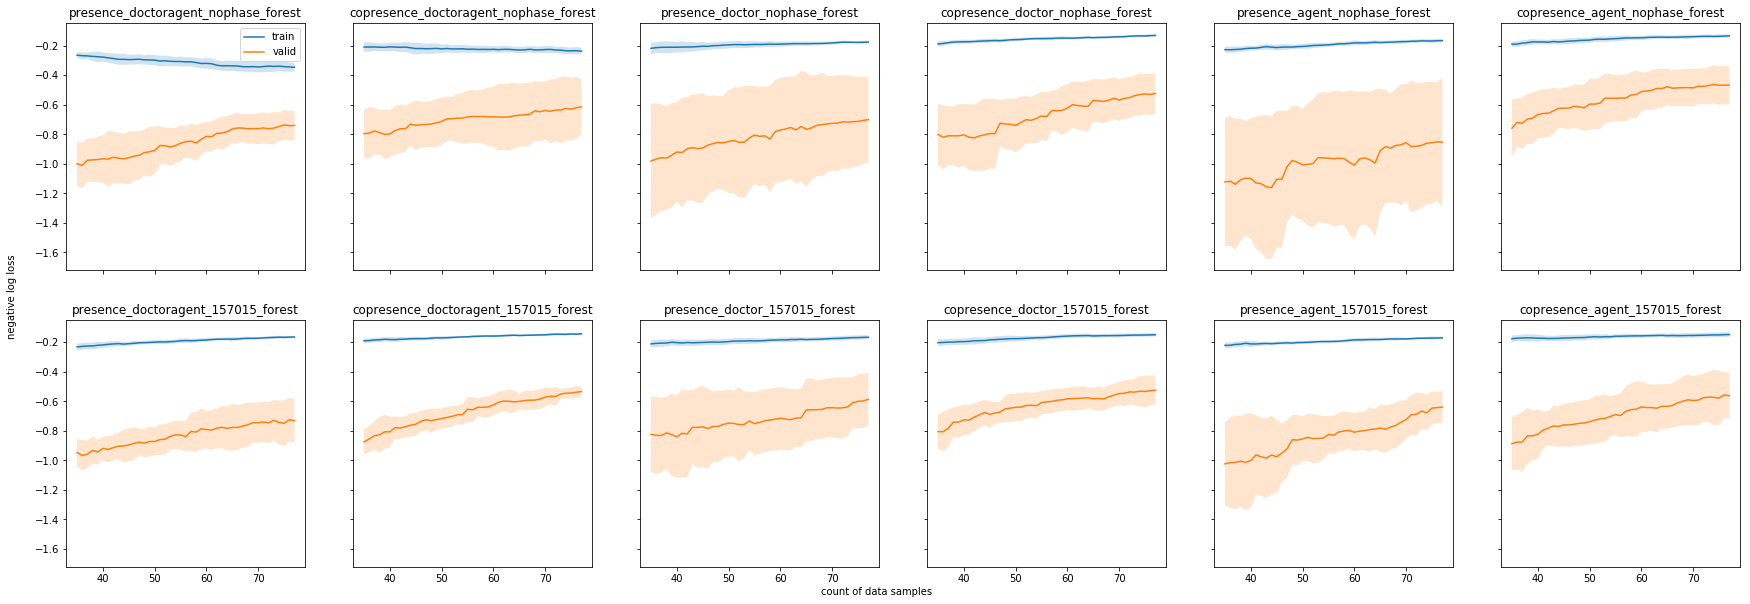

In [172]:
test_plan_params = {
    'classifier': ['forest'],
    'subject': ['doctor+agent', 'doctor', 'agent'],
    'target': ['presence', 'copresence'],
    'phases': [(0,1,0), (0.15,0.70,0.15)]
}
test_plan = list(ParameterGrid(test_plan_params))

forest = RandomForestClassifier(random_state=RANDOM_STATE, oob_score=True)
svm = make_pipeline(StandardScaler(), SVC(random_state=RANDOM_STATE, probability=True))

# whether to apply 'original' upsampling method
upsample = True

cols= 6
fig, ax = plt.subplots(int(len(test_plan)/cols), cols, sharex=True, sharey=True, figsize=(30,10))

results = {}

for idx, test in enumerate(test_plan):
    print("Test %d : %s" % (idx, test))
    

    subject = test['subject']
    target = test['target']
    phases = test['phases']
    classifier = test['classifier']
    clf = forest if classifier == 'forest' else svm
    pgrid = param_grid_rf if classifier == 'forest' else param_grid_svm

    if phases is not None and not phases == (0,1,0):
        print("phases " + str(phases))
        if subject == 'doctor':
            df = subject_p_df
            feats = subject_features
        elif subject == 'agent':
            df = agent_p_df
            feats = agent_features
        elif subject == 'doctor+agent':
            df = all_p_df
            feats=all_features
    else:
        print("No phase")
        if subject == 'doctor':
            df = subject_np_df
            feats = subject_features_nophase
        elif subject == 'agent':
            df = agent_np_df
            feats = agent_features_nophase
        elif subject == 'doctor+agent':
            df = all_np_df
            feats=all_features_nophase        
    
    X, y = prepare_train_data(samples=df, features=feats, target_model=target, upsample=upsample) 
    
    isDoc = 'doctor' in subject
    isAgent = 'agent' in subject
    presidx = 'Presence' if target == 'presence' else 'Co-Presence'
    if subject == 'doctor':
        subjidx = 'Doctor'
    elif subject == 'agent':
        subjidx = 'Agent'
    else:
        subjidx = 'Doctor+Agent'
    phidx = 'No Phase' if phases in [None, (0,1,0)] else '%02d%02d%02d' % ( phases[0]*100, phases[1]*100, phases[2]*100 )
    clfidx = 'Random Forests' if classifier == 'forest' else 'SVM'

    test_set_name = dh.get_grid_name(target=='presence', isDoc, isAgent, phases, classifier)
    
    # create classifier from best params found previously
    best_params = context_df.loc[presidx, subjidx, phidx, clfidx, 'score']['Best Params']
    clf.set_params(**eval(best_params))
    print("  Computing learning curve for best params : %s" % str(best_params))

    train_sizes = np.arange(35, len(df))
    print(train_sizes)
    print(np.unique(y, return_counts=True))
    train_sizes, train_scores, test_scores = learning_curve(clf, 
                                                            X, y, 
                                                            train_sizes=train_sizes, 
                                                            cv=10, 
                                                            scoring='neg_log_loss',
                                                            shuffle=True)

    results[test_set_name] = {}
    results[test_set_name]['train'] = train_scores
    results[test_set_name]['test'] = test_scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    cur_ax = ax[int(idx / cols), (idx) % cols]
    cur_ax.plot(train_sizes, train_scores_mean, label='train')
    cur_ax.fill_between(train_sizes, train_scores_mean + train_scores_std,
                    train_scores_mean - train_scores_std, alpha=0.2)

    cur_ax.plot(train_sizes, test_scores_mean, label='valid')
    cur_ax.fill_between(train_sizes, test_scores_mean + test_scores_std,
                    test_scores_mean - test_scores_std, alpha=0.2)
    cur_ax.set_title(test_set_name)
    #cur_ax.xlabel("Count of samples")
    #cur_ax.ylabel("Negative log loss")
    if idx == 0: cur_ax.legend()
fig.text(0.5, 0.09, 'count of data samples', ha='center', va='center')
fig.text(0.1, 0.5, 'negative log loss', ha='center', va='center', rotation='vertical')
dh.save_fig('learning_curves_phase-nophase_forest.png') 
plt.show()

In [174]:
dh.save_obj(results, 'learning_curves', 'forest')

True

In [96]:
plt.show()

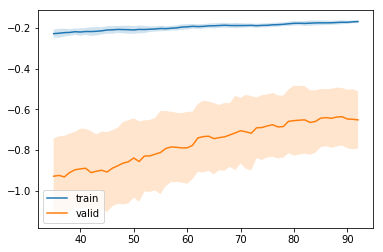

In [313]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label='train')
plt.fill_between(train_sizes, train_scores_mean + train_scores_std,
                train_scores_mean - train_scores_std, alpha=0.2)

plt.plot(train_sizes, test_scores_mean, label='valid')
plt.fill_between(train_sizes, test_scores_mean + test_scores_std,
                test_scores_mean - test_scores_std, alpha=0.2)
plt.legend()
plt.show()

In [304]:
from sklearn.model_selection import validation_curve

train_scores, valid_scores = validation_curve(clf, X, y, "n_estimators",
                                               np.arange(1, 300, 10),
                                               cv=10)

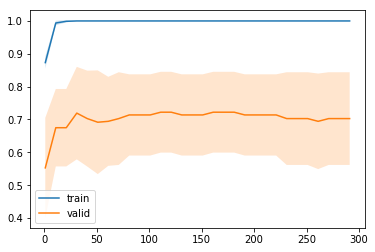

In [306]:
test_scores = valid_scores
x_range = np.arange(1,300,10)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(x_range, train_scores_mean, label='train')
plt.fill_between(x_range, train_scores_mean + train_scores_std,
                train_scores_mean - train_scores_std, alpha=0.2)

plt.plot(x_range, test_scores_mean, label='valid')
plt.fill_between(x_range, test_scores_mean + test_scores_std,
                test_scores_mean - test_scores_std, alpha=0.2)
plt.legend()
plt.show()

In [ ]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X=X, y=y, clf=clf, legend=2)
plt.xlabel("x", size=5)
plt.ylabel("y", size=5)
plt.title('SVM Decision Region Boundary', size=6)
plt.show()

## Specific tests on 'Expert' feature

In [42]:
# specific test on expert importance

subject_features = ("Expert", "Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

subject_noexpert_features = ("Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

# not using "Expert" feature for agent features
agent_features = ("Head_Entropy_Start", "Head_Entropy_Mid", "Head_Entropy_End", "Avg_HandEntropy_Begin",
             "Avg_HandEntropy_Mid", "Avg_HandEntropy_End", "Avg_SentenceLength_Begin", "Avg_SentenceLength_Mid",
             "Avg_SentenceLength_End",  "Ratio1_Begin", "Ratio1_Mid", "Ratio1_End", "Ratio2_Begin", "Ratio2_Mid", 
                    "Ratio2_End", "Duration")

In [43]:
grid1 = gridsearch(forest, subject_p_df, 'presence', param_grid=param_grid, features=subject_features, upsample=True)
df = pd.DataFrame(grid1.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_1 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val1 = df_best_1.iloc[0]
df_best_1 = pd.DataFrame(df_best_val1.values, columns=['Doctor / Expert'], index=df_best_1.columns).T
df_best_1

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  6.1min finished


ValueError: Shape of passed values is (2, 83), indices imply (1, 83)

In [62]:
grid2 = gridsearch(forest, subject_p_df, 'presence', param_grid=param_grid, features=subject_noexpert_features, upsample=True)
df = pd.DataFrame(grid2.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_ = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val2 = df_best_2.iloc[0]
df_best_2 = pd.DataFrame(df_best_val2.values, columns=['Doctor / No Expert'], index=df_best_2.columns).T
df_best_2

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  5.1min finished


In [63]:
grid3 = gridsearch(forest, agent_p_df, 'presence', param_grid=param_grid, features=agent_features, upsample=True)
df = pd.DataFrame(grid3.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_3 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val3 = df_best_3.iloc[0]
df_best_3 = pd.DataFrame(df_best_val3.values, columns=['Agent / No Expert'], index=df_best_3.columns).T
df_best_3

Fitting 10 folds for each of 84 candidates, totalling 840 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 840 out of 840 | elapsed:  5.0min finished


ValueError: Shape of passed values is (6, 83), indices imply (1, 83)

In [64]:
df = pd.DataFrame(grid3.cv_results_)
best_precision = df.mean_test_precision_macro.max()
df_best_3 = pd.DataFrame(df.loc[df['mean_test_precision_macro'] == best_precision])
df_best_val3 = df_best_3.iloc[0]
df_best_3 = pd.DataFrame(df_best_val3.values, columns=['Agent / No Expert'], index=df_best_3.columns).T
df_best_3

mean_fit_time mean_score_time mean_test_f1_macro  \
Agent / No Expert        0.0141      0.00369997           0.773156   

                  mean_test_precision_macro mean_test_recall_macro  \
Agent / No Expert                  0.831852               0.780952   

                  mean_train_f1_macro mean_train_precision_macro  \
Agent / No Expert            0.997849                   0.997917   

                  mean_train_recall_macro param_class_weight  \
Agent / No Expert                0.997849               None   

                  param_max_features  ... split9_train_precision_macro  \
Agent / No Expert               auto  ...                            1   

                  split9_train_recall_macro std_fit_time std_score_time  \
Agent / No Expert                         1   0.00418211     0.00414847   

                  std_test_f1_macro std_test_precision_macro  \
Agent / No Expert          0.118873                0.0914799   

                  std_test_recall_macro std_train_f1_macro  \
Agent / No Expert               0.11225         0.00430219   

                  std_train_precision_macro std_train_recall_macro  
Agent / No Expert                0.00416667             0.00430108  

[1 rows x 83 columns]

In [65]:
df_best_all = pd.concat([df_best_1, df_best_2, df_best_3])
df_best_all[['mean_test_precision_macro', 'mean_test_f1_macro', 'mean_test_recall_macro', 'params']]

mean_test_precision_macro mean_test_f1_macro  \
Doctor / Expert                     0.814921           0.746969   
Doctor / No Expert                  0.836531           0.793405   
Agent / No Expert                   0.831852           0.773156   

                   mean_test_recall_macro  \
Doctor / Expert                  0.761905   
Doctor / No Expert                    0.8   
Agent / No Expert                0.780952   

                                                               params  
Doctor / Expert     {u'max_features': None, u'n_estimators': 50, u...  
Doctor / No Expert  {u'max_features': None, u'n_estimators': 100, ...  
Agent / No Expert   {u'max_features': u'auto', u'n_estimators': 10...

In [68]:
df = pd.DataFrame(grid1.cv_results_)
cols = [col for col in df.columns if 'std' in col]
df[cols]

std_fit_time  std_score_time  std_test_f1_macro  std_test_precision_macro  \
0       0.002871        0.002256           0.132134                  0.165828   
1       0.003661        0.001814           0.133546                  0.166498   
2       0.034886        0.003231           0.143855                  0.179382   
3       0.007099        0.004826           0.115380                  0.097104   
4       0.005590        0.002193           0.109027                  0.079613   
5       0.008237        0.003716           0.130162                  0.124520   
6       0.035410        0.018779           0.133596                  0.128389   
7       0.003807        0.003873           0.084147                  0.073661   
8       0.008453        0.002764           0.110407                  0.116601   
9       0.009600        0.004331           0.117534                  0.126775   
10      0.004468        0.001908           0.110440                  0.090709   
11      0.005800        0.003807           0.136320                  0.132022   
12      0.009456        0.001911           0.145617                  0.138653   
13      0.028111        0.015740           0.125663                  0.128901   
14      0.004605        0.004069           0.084147                  0.073661   
15      0.004206        0.003382           0.110407                  0.116601   
16      0.004454        0.003208           0.117534                  0.126775   
17      0.006848        0.002579           0.110440                  0.090709   
18      0.004928        0.003002           0.136320                  0.132022   
19      0.013497        0.004792           0.145617                  0.138653   
20      0.062058        0.019393           0.125663                  0.128901   
21      0.004253        0.003499           0.084147                  0.073661   
22      0.005143        0.003905           0.110407                  0.116601   
23      0.003341        0.003429           0.117534                  0.126775   
24      0.005108        0.002655           0.110440                  0.090709   
25      0.005693        0.003066           0.136320                  0.132022   
26      0.008075        0.001900           0.145617                  0.138653   
27      0.057628        0.012464           0.125663                  0.128901   
28      0.002532        0.002586           0.132134                  0.165828   
29      0.002800        0.003555           0.133546                  0.166498   
..           ...             ...                ...                       ...   
54      0.013589        0.003736           0.145617                  0.138653   
55      0.101283        0.016242           0.125663                  0.128901   
56      0.003544        0.003768           0.167014                  0.210353   
57      0.004674        0.003600           0.120550                  0.176845   
58      0.003910        0.005381           0.104046                  0.135741   
59      0.017304        0.005065           0.107917                  0.135997   
60      0.016117        0.004477           0.105020                  0.117366   
61      0.019586        0.004406           0.141573                  0.151115   
62      0.040515        0.028023           0.136354                  0.148026   
63      0.004750        0.002191           0.117917                  0.126316   
64      0.006450        0.003931           0.112843                  0.097814   
65      0.006344        0.003487           0.123512                  0.102862   
66      0.006034        0.002532           0.129254                  0.111541   
67      0.014127        0.002166           0.133994                  0.127645   
68      0.005546        0.002685           0.146913                  0.142563   
69      0.233796        0.029742           0.124730                  0.125555   
70      0.002993        0.002600           0.117917                  0.126316   
71      0.003040        0.002926   

In [249]:
import numpy as np, scipy.stats as st

def confint(a):
    return st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a))

a = [1, 1.1, 0.9, 1.15, 0.8, 1.03, 0.99]
print(confint(a))

(0.8866952590268444, 1.1047333124017271)


In [40]:
rdf.index = rdf.index.swaplevel(2,3)
rdf.sort_index(inplace=True)

In [71]:
rdf

precision        f1  \
Classifier     Metric      Phases   Subject                             
Random Forests Co-Presence 157015   Agent          0.857977  0.843006   
                                    Doctor         0.843895  0.775644   
                                    Doctor+Agent   0.891758  0.857478   
                           No Phase Agent          0.916809  0.893617   
                                    Doctor         0.821652  0.798101   
                                    Doctor+Agent   0.868091  0.827934   
               Presence    157015   Agent          0.810794  0.754127   
                                    Doctor         0.778753  0.723586   
                                    Doctor+Agent   0.782381  0.747407   
                           No Phase Agent          0.763946  0.733961   
                                    Doctor         0.816032  0.776039   
                                    Doctor+Agent   0.844444  0.808904   
SVM            Co-Presence 157015   Agent          0.919678  0.882360   
                                    Doctor         0.881481  0.855305   
                                    Doctor+Agent   0.891209  0.858275   
                           No Phase Agent          0.920391  0.870184   
                                    Doctor         0.897212  0.821709   
                                    Doctor+Agent   0.890761  0.862064   
               Presence    157015   Agent          0.883039  0.793964   
                                    Doctor         0.927302  0.892880   
                                    Doctor+Agent   0.913515  0.862339   
                           No Phase Agent          0.818995  0.784713   
                                    Doctor         0.843900  0.801139   
                                    Doctor+Agent   0.898753  0.843911   

                                                    recall  \
Classifier     Metric      Phases   Subject                  
Random Forests Co-Presence 157015   Agent         0.846154   
                                    Doctor        0.794872   
                                    Doctor+Agent  0.863248   
                           No Phase Agent         0.897436   
                                    Doctor        0.803419   
                                    Doctor+Agent  0.837607   
               Presence    157015   Agent         0.771429   
                                    Doctor        0.742857   
                                    Doctor+Agent  0.752381   
                           No Phase Agent         0.742857   
                                    Doctor        0.780952   
                                    Doctor+Agent  0.819048   
SVM            Co-Presence 157015   Agent         0.888889   
                                    Doctor        0.871795   
                                    Doctor+Agent  0.871795   
                           No Phase Agent         0.880342   
                                    Doctor        0.837607   
                                    Doctor+Agent  0.880342   
               Presence    157015   Agent         0.800000   
                                    Doctor        0.895238   
                                    Doctor+Agent  0.866667   
                           No Phase Agent         0.809524   
                                    Doctor        0.809524   
                                    Doctor+Agent  0.847619   

                                                                                             params  
Classifier     Metric      Phases   Subject                                                          
Random Forests Co-Presence 157015   Agent         {'max_features': None, 'n_estimators': 40, 'cl...  
                                    Doctor        {'max_features': None, 'n_estimators': 10, 'cl...  
                                    Doctor+Agent  {'max_features': 'auto', 'n_estimators': 100, ...  
                           N

# Features importance experiments

We would like to check variance and quality of this estimator.
For this we first experiment cross validations with searching also n_estimators, or fixing it with a high value, and check if and how best parameters vary.
Then we will check for a specific set of params, how results and feature importance vary upon repeated runs.
Depending on results, we will compute feature importance for all test plan.

In [211]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import scipy.stats as st


def scoreForest(estimator, X, y):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    We add to this the 
    """
    all_feature_importances.append(estimator.feature_importances_)
    score = estimator.oob_score_
    #print "oob_score_:", score
    return score

def run_cross_val_score(clf, X, y, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    scoring = {
        'oob' : scoreForest,
        'f1_macro' : 'f1_macro',
        'f1_macro_class_1': make_scorer(f1_score, labels=[1], average='macro'),
        'f1_macro_class_2': make_scorer(f1_score, labels=[2], average='macro'),
        'f1_macro_class_3': make_scorer(f1_score, labels=[3], average='macro'),
        'precision_macro' : 'precision_macro',
        'precision_macro_class_1': make_scorer(precision_score, labels=[1], average='macro'),
        'precision_macro_class_2': make_scorer(precision_score, labels=[2], average='macro'),
        'precision_macro_class_3': make_scorer(precision_score, labels=[3], average='macro'),
        'recall_macro' : 'recall_macro',
        'recall_macro_class_1': make_scorer(recall_score, labels=[1], average='macro'),
        'recall_macro_class_2': make_scorer(recall_score, labels=[2], average='macro'),
        'recall_macro_class_3': make_scorer(recall_score, labels=[3], average='macro')           
    }
    
    return cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False, verbose=verbose)



# random forests
param_grid =  {
    'n_estimators' : [300],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    "max_depth": [None, 2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}

# n : number of repeated runs performed to compute averages and confidence intervals
n = 10

def run_gridsearch_with_feature_importances(dataframe, target_model, features_names, upsample=True):

    scores = []

    X, y = prepare_train_data(subject_np_df, 'presence', subject_features_nophase, upsample=True)

    # first evaluate best params through grid search for this particular test
    grid = gridsearch(forest, 
                      X, y, 
                      'presence', 
                      param_grid=param_grid, 
                      features=subject_features, 
                      upsample=True, 
                      verbose=0)
    best_params = grid.best_params_
    single_best_score = grid.best_score_

    print('  Gridsearch evaluated best score %s' % (single_best_score))
    print('    Running %d iterations on best classifier %s ...' % (n, best_params))

    all_scores = []
    all_feature_importances = []
    all_dropcol_feature_importances = []
    for i in np.arange(n):
        forest = RandomForestClassifier(oob_score=True)
        forest.set_params(**best_params)

        scores = run_cross_val_score(forest, 
                          X, y,  
                          verbose=0)
    #    print(scores)
        scores_df = pd.DataFrame(scores)
        #print(scores_df)
        #print(scores_df.columns)
        all_scores.append(scores_df)

    X_ = pd.DataFrame(X, columns=subject_features_nophase)
    y_ = pd.DataFrame(y)
    for i in np.arange(300):
        # alternative computation for feature importance
        all_dropcol_feature_importances.append(dropcol_importances(forest, X_, y_, RANDOM_STATE+i))

    all_scores = pd.concat(all_scores)
    all_feature_importances = pd.DataFrame(all_feature_importances, columns=subject_features_nophase)
    all_dropcol_features_importances = pd.DataFrame(all_dropcol_feature_importances, columns=subject_features_nophase)

(array([1, 2, 3], dtype=int64), array([37, 37, 37]))
  Gridsearch evaluated best score 0.7525343525343525
    Running 10 iterations on best classifier {'max_features': None, 'n_estimators': 30, 'max_depth': None, 'min_samples_leaf': 1} ...


In [ ]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import scipy.stats as st


def score_forest(estimator, X, y):
    """
    Custom scoring function for hyperparameter optimization. In this case, we want to print out the oob score.
    estimator was fitted on train data, X and y here are validation data.
    For OOB we don't need validation data - OOB is inherent to tree building.
    Same for feature importances (with default gini impurity measure done by sklearn).
    """
    all_feature_importances.append(estimator.feature_importances_)
    score = estimator.oob_score_
    #print "oob_score_:", score
    return score

def run_cross_val_score(clf, X, y, verbose=1):
    #print("gridsearch(clf=%s, modelTarget=%s, param_grid=%s, features=%s, upsample=%s)" 
    #      % (type(clf), modelTarget, param_grid, features, upsample))

    scoring = {
        'oob' : score_forest,
        'f1_macro' : 'f1_macro',
        'f1_macro_class_1': make_scorer(f1_score, labels=[1], average='macro'),
        'f1_macro_class_2': make_scorer(f1_score, labels=[2], average='macro'),
        'f1_macro_class_3': make_scorer(f1_score, labels=[3], average='macro'),
        'precision_macro' : 'precision_macro',
        'precision_macro_class_1': make_scorer(precision_score, labels=[1], average='macro'),
        'precision_macro_class_2': make_scorer(precision_score, labels=[2], average='macro'),
        'precision_macro_class_3': make_scorer(precision_score, labels=[3], average='macro'),
        'recall_macro' : 'recall_macro',
        'recall_macro_class_1': make_scorer(recall_score, labels=[1], average='macro'),
        'recall_macro_class_2': make_scorer(recall_score, labels=[2], average='macro'),
        'recall_macro_class_3': make_scorer(recall_score, labels=[3], average='macro')           
    }
    
    return cross_validate(clf, X, y, scoring=scoring, cv=10, return_train_score=False, verbose=verbose)



# random forests
param_grid =  {
    'n_estimators' : [300],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    "max_depth": [None, 2, 5, 10],
    "min_samples_leaf": [1, 5, 10]
}

# n : number of repeated runs performed to compute averages and confidence intervals
n = 10

def run_gridsearch_with_feature_importances(clf, param_grid, dataframe, target_model, repeat=10, upsample=True):

    scores = []

    X, y = prepare_train_data(dataframe, target_model, dataframe.columns, upsample=True)

    # first evaluate best params through grid search for this particular test
    grid = gridsearch(clf, 
                      X, y, 
                      'presence', 
                      param_grid=param_grid, 
                      features=subject_features, 
                      upsample=True, 
                      verbose=0)
    best_params = grid.best_params_
    single_best_score = grid.best_score_

    print('  Gridsearch evaluated best score %s' % (single_best_score))
    print('    Running %d iterations on best classifier %s ...' % (repeat, best_params))

    all_scores = []
    all_feature_importances = []
    all_dropcol_feature_importances = []
    for i in np.arange(repeat):
        forest = RandomForestClassifier(oob_score=True)
        forest.set_params(**best_params)

        scores = run_cross_val_score(forest, 
                          X, y,  
                          verbose=0)
    #    print(scores)
        scores_df = pd.DataFrame(scores)
        #print(scores_df)
        #print(scores_df.columns)
        all_scores.append(scores_df)

    X_ = pd.DataFrame(X, columns=subject_features_nophase)
    y_ = pd.DataFrame(y)
    for i in np.arange(300):
        # alternative computation for feature importance
        all_dropcol_feature_importances.append(dropcol_importances(forest, X_, y_, RANDOM_STATE+i))

    all_scores = pd.concat(all_scores)
    all_feature_importances = pd.DataFrame(all_feature_importances, columns=dataframe.columns)
    all_dropcol_features_importances = pd.DataFrame(all_dropcol_feature_importances, columns=dataframe.columns)

forest = RandomForestClassifier()
run_gridsearch_with_feature_importances('rf', 
                                        param_grid, 
                                        subject_np_df[subject_features_nophase], 
                                        'presence', 
                                        upsample=True)

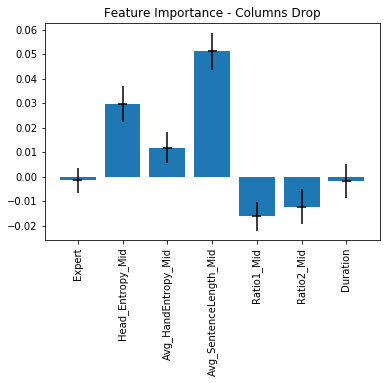

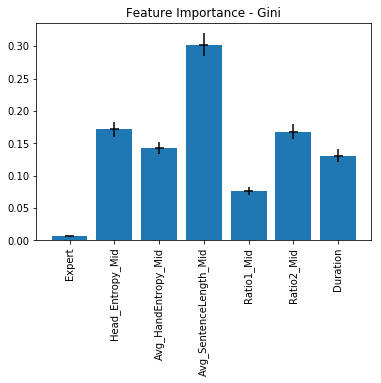

In [212]:

#print(all_scores)
all_scores_ = all_scores.drop(['fit_time', 'score_time'], axis=1).T
final = pd.DataFrame(index=all_scores_.index)

final['means'] = all_scores_.mean(axis=1)
final['std'] = all_scores_.std(axis=1)
final['sem'] = all_scores_.sem(axis=1)
final['confidence'] = all_scores_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)



final_fi = all_dropcol_features_importances.T
final_fi['means'] = final_fi.mean(axis=1)
final_fi['std'] = final_fi.std(axis=1)
final_fi['sem'] = final_fi.sem(axis=1)
final_fi['confidence'] = final_fi.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)


plot_importance('Columns Drop', 
                final_fi['means'],
                final_fi['confidence'],
                subject_features_nophase, 
                sort=False)


final_fi_ = all_feature_importances.T
final_fi_['means'] = final_fi_.mean(axis=1)
final_fi_['std'] = final_fi_.std(axis=1)
final_fi_['sem'] = final_fi_.sem(axis=1)
final_fi_['confidence'] = final_fi_.apply(lambda row : 2*(np.mean(row) - st.t.interval(0.95, len(row)-1, loc=np.mean(row), scale=st.sem(row))[0]) , axis = 1)


plot_importance('Gini', 
                final_fi_['means'],
                final_fi_['confidence'],
                subject_features_nophase, 
                sort=False)


In [24]:
best_params = context_df[context_df['Metric.1'] == 'score']['Best Params']
print(best_params[0])
print(type(eval(best_params[0])))
print(eval(best_params[0]).keys())
unpacked = [[p[key] for p in best_params] for key in eval(best_params[0]).keys()]
df = pd.DataFrame(data=np.vstack((scores, unpacked))).T
df.columns=['score', 'max_features', 'n_estimators', 'max_depth', 'min_samples_leaf']
print(df.sort_values(by=['score'], ascending=False))

{'max_features': None, 'n_estimators': 300, 'max_depth': None, 'min_samples_leaf': 1}
<type 'dict'>
['max_features', 'n_estimators', 'max_depth', 'min_samples_leaf']


TypeError: string indices must be integers, not str